 Project 4
---

## Executive Summary

The motivation of this project was to identify the factors that affected the salary of data-related job postings. This was primarily achieved through scraping job listings posted within the job aggregator site “Indeed.com” and analysing the text in both the job title and job summary to draw insights through various machine learning techniques.

Although we are based in Australia, the scraping was performed on data science jobs within America. This is due to the fact that while the data science scene in Australia is growing at an astounding rate, we have yet to find stable and agreeable differences between the different roles in data related fields. As such from a preliminary analysis there is an implicit confusion and a tendency to use certain data terms interchangeably within job descriptions and titles leading to a summary that may not necessarily be too insightful as Australia develops its understanding of Data Science. As such American Data Science Jobs are used for its more developed state of understanding in data science and machine learning fields. 

Regarding our findings on the keywords used in data scientist titles, it was more or less intuitive and expected. Keywords such as “data scientist”, “senior” or “machine learning” and various combinations were the three words that most often contributed to a higher salary, while conversely jobs that referenced “research”, “analyst” or “associate” were more likely to be lower paying jobs. In fact there is such a clear distinction between even the keywords used in titles that, if given just a title or summary we are able to predict whether the job is high or low paying to a 91% accuracy. 

There are however more interesting results obtained from analysis of job summaries. It was found that higher paying data scientist jobs in America were largely focused on hard skills. It was especially clear that almost all employers who referenced a specific advanced skill in data science was almost guaranteed to be a high paying job. This included references to pipelines, NLP or deep learning. Conversely amongst lower paying jobs, there was a much confusion where keywords didn’t refer to specific skillsets but rather referred to them as a whole. As an example, instead of referencing to machine learning or neural networks, they would instead refer to the “Ability Required” or “skills demonstrated”. Further exploring  the hard skills required in both categories revealed that python and R where most widely used among high paying jobs whereas excel dominated the low.


---

## Import Dependencies

---

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests
import pprint

from bs4 import BeautifulSoup

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Scraping

Unfortunately since I'm not too familiar with scrapy and jupyter notebook, I dont know how to integrate the scrapy spider into the notebook. However, the below cell contains the code for spider scraper.

The datasets were scraped within the scrapy shell and taken as .csv files for analysis. Below is an example of one of such of these spiders.

In [3]:
import scrapy, requests
from scrapy.crawler import CrawlerProcess
from scrapy.utils.project import get_project_settings
from bs4 import BeautifulSoup
from scrapy.spiders import CrawlSpider, Rule
from scrapy.linkextractors import LinkExtractor


class IndeedSpider(CrawlSpider):
    name = 'global'
    allowed_domains = ['indeed.com']
    start_urls = ['https://www.indeed.com/jobs?q=Data+Scientist+$120,000']

    rules = (
        Rule(LinkExtractor("start=.*"), callback='parse_item', follow = True),
        )
    
    def parse_item(self, response):
        
        print("-----------------------------------------------------")
        print("I just visited the url: " + response.url)
        print("-----------------------------------------------------")

        soup = BeautifulSoup(response.text, 'lxml')
        divs = soup.find_all("div", class_ = ["row", "result"])
        
        for job in divs:
            
            # Empty List to store details
            item = {}
            
            # Scrapes the id of the job
            item["id"] = job.get("id")
            
            # Scrapes the company name
            try:
                item["company"] = job.find("span", class_ = "company").text.strip("\n").strip()
            except AttributeError:
                item["company"] = None

            # Scrapes the title of the job
            item["title"] = job.a.get("title")

            # Scrapes the location of the job
            item["loc"]= job.find("span", class_ ="location").text
            
            # Extracts the full job summary page to be parsed and scraped
            job_summ_page = job.get("data-jk")
            next_page_url = "https://www.indeed.com/viewjob?jk={}".format(job_summ_page)
            yield scrapy.Request(url = next_page_url, callback = self.parse_summ, meta=dict(item=item))
    
    # Function to parse full job page
    def parse_summ(self, response):
        
        # Obtains the item dictionary to add on the full summary
        item = response.meta['item']
        
        soup = BeautifulSoup(response.text, 'lxml')
        item["summary"] = soup.find("span", class_ = "summary").text.replace("\n", " ")
        yield item
    ...

process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(IndeedSpider)
process.start(); # the script will block here until the crawling is finished

2018-01-13 01:10:25 [scrapy.utils.log] INFO: Scrapy 1.4.0 started (bot: scrapybot)
2018-01-13 01:10:25 [scrapy.utils.log] INFO: Overridden settings: {'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}
2018-01-13 01:10:26 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.logstats.LogStats']
2018-01-13 01:10:26 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 'scrapy.downloadermiddlewares.downloadtimeout.DownloadTimeoutMiddleware',
 'scrapy.downloadermiddlewares.defaultheaders.DefaultHeadersMiddleware',
 'scrapy.downloadermiddlewares.useragent.UserAgentMiddleware',
 'scrapy.downloadermiddlewares.retry.RetryMiddleware',
 'scrapy.downloadermiddlewares.redirect.MetaRefreshMiddleware',
 'scrapy.downloadermiddlewares.httpcompression.HttpCompressionMiddleware',
 'scrapy.downloadermiddlewares.redirect.Redirec

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=10
-----------------------------------------------------


2018-01-13 01:10:28 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=91667aeecfe78747> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=10)
2018-01-13 01:10:28 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=91667aeecfe78747>
{'id': 'p_91667aeecfe78747', 'company': 'Litmus', 'title': 'Data Scientist (Contractor)', 'loc': 'United States', 'summary': "At Litmus we build best-in-class tools and applications to empower marketers, designers, and agencies to achieve high levels of personalization, engagement, and ROI with every email they send. Over 250,000 major global brands across every industry and vertical trust Litmus to help them confidently deliver a superior subscriber experience, including 9 of the top 10 eCommerce brands, 8 of the top 10 retailers, 7 of the top 10 tech companies, and 23 of the top 25 US ad agencies.  We also have partnerships with more than 250 industry-leading email service 

2018-01-13 01:10:28 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6bb0caa08ee02e87> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=10)
2018-01-13 01:10:28 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8f92b89dd8d82d4d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=10)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=20
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=40
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=30
-----------------------------------------------------


2018-01-13 01:10:28 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=366625b9003e7ed5> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=10)
2018-01-13 01:10:28 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8d32210ba37f36b7> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=10)
2018-01-13 01:10:28 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6bb0caa08ee02e87>
{'id': 'p_6bb0caa08ee02e87', 'company': 'Centers for Disease Control and Prevention', 'title': 'Mathematical Statistician', 'loc': 'Atlanta, GA', 'summary': 'What exciting career opportunities await you at CDC?   The Centers for Disease Control and Prevention (CDC) is the agency Americans trust with their lives. As a global leader in public health, CDC is the nation\'s premier health promotion, prevention, and preparedness agency. Whether we are protecting the American people from p

2018-01-13 01:10:28 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8f92b89dd8d82d4d>
{'id': 'p_8f92b89dd8d82d4d', 'company': 'Booz Allen Hamilton', 'title': 'A&M Data Scientist, Junior', 'loc': 'Washington, DC', 'summary': "Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years. Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. A&M Data Scientist, Junior Key Role: Work as an impactful and motivated data scientist developing technical solutions to complex problems. Analyze data to identify trends and support the development of mission-related 

2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=0c97dea4f7b7bb22> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=10)
2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ce66c1653d61c9dd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=10)
2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ea688da375e32d96> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=10)
2018-01-13 01:10:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8d32210ba37f36b7>
{'id': 'p_8d32210ba37f36b7', 'company': 'Comcast', 'title': 'Data Scientist 4106', 'loc': 'New York, NY 10001 (Chelsea area)', 'summary': "Comcast brings together the best in media and technology. We drive innovation to create the world's best entertainment and online experiences. As a For

{'id': 'p_0c97dea4f7b7bb22', 'company': 'LG Electronics', 'title': 'Director of Artificial Intelligence and Machine Learning - Toronto Canada', 'loc': 'Field', 'summary': 'At LG we make products and services that make lives better, easier and happier through increased functionality and fun. Put simply, we offer the latest innovations to make “Life Good” – from home appliances, consumer electronics, vehicle components and mobile communications to business innovations in digital signage, air conditioning, solar and LED lighting. As a global leader, we strive for greatness in product leadership, market leadership and people leadership to realize our growth strategies.   Talk about a mantra. Life’s Good with LG!   Director of Artificial Intelligence and Machine Learning- Toronto Canada   LG’s is looking for passionate and talented AI / Machine Learning scientists and engineers to work closely with the LG Silicon valley lab and Korea AI lab on novel and disruptive solutions that will shape 

2018-01-13 01:10:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ea688da375e32d96>
{'id': 'p_ea688da375e32d96', 'company': 'Groupon', 'title': 'Data Scientist - Groupon Goods', 'loc': 'Seattle, WA', 'summary': 'At Groupon, data drives our decisions. We are looking for a Data Scientist who will join an influential team to guide the Groupon Goods product roadmap by deriving meaningful insights from the wealth of data we have from our customers, logistics networks and suppliers. You will be testing hypotheses against the data, giving critical opinions about next actions, and communicating your findings to your team. We need an analytics expert the team can count and you will get to see your work rapidly feed back into the evolution of our products.   The ideal candidate will:  Synthesize raw data into recommendations on how products should evolve   Quantify the potential value of new product hypotheses   Design and support large-scale multivariate tests

{'id': 'p_b0f9a69b91da8294', 'company': 'IBM', 'title': 'Data Scientist: Advanced Analytics', 'loc': 'California', 'summary': 'Job Description IBM Global Business Services: Join a Leader. Consult with us.  IBM Global Business Services helps top-tier clients solve their most complex business and technical issues. As a Data Scientist, you will deliver innovative business consulting, business process design, systems integration, and application design and management to leading sector organizations in 17 industries worldwide. With access to resources that only a global leader can provide, you will learn valuable skills, gain access to a vast and diverse network of talented professionals, and enjoy unparalleled career, training, and educational opportunities.  Visit http://www.ibm.com/ca/ for more information  The Data Scientist will be familiar with key internal and external data sources and how they are gathered and retrieved; experience with manipulation large volumes of data leveraging 

2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9221d6dc42dcd27d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=20)
2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d74e08c2e1a68cd2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=20)
2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=02ecc871f377f959> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=20)
2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=70d5a1eaaee30f42> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=20)
2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=b5c1a9cb69b18fda> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=30)
2018-01-13 01:1

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=50
-----------------------------------------------------


2018-01-13 01:10:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9221d6dc42dcd27d>
{'id': 'p_9221d6dc42dcd27d', 'company': 'McKinsey & Company', 'title': 'Data Scientist - New Ventures Campus', 'loc': 'Atlanta, GA 30318 (Rockdale area)', 'summary': "Qualifications Be currently enrolled in an academic program and looking for a full time job in 2018 Exceptional numerical and statistical ability, with excitement for applying analytics to client challenges and significant experience using analytic / database software and languages such as SAS, SQL, SPSS, R, Python, etc. Superior critical thinking and creative problem solving skillss Basic business intuition and clear expertise in analyses with the ability to describe analytic processes, including when and why specific approaches are favored Strong oral and written communication skills, including the ability to communicate effectively to non-technical audiences Ability to deliver in deadline-driven enviro

2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=40)
2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=70> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=40)
2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=adc4c13dcf95db81> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=30)
2018-01-13 01:10:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=70d5a1eaaee30f42>
{'id': 'p_70d5a1eaaee30f42', 'company': 'Catasys', 'title': 'Sr. Data Scientist', 'loc': 'Home Based', 'summary': "Data Analytics Senior Data Scientist Catasys works with major health insurers to solve the hidden problem of high-cost untreated behavioral hea

2018-01-13 01:10:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f9bd2700b6127c5f>
{'id': 'p_f9bd2700b6127c5f', 'company': 'Cognizant', 'title': 'Senior Data Scientist', 'loc': 'Plano, TX 75024', 'summary': 'Gartner has defined Advanced Analytics & Data Science expert, as the ‘sexiest job’ in the 21st Century. Advanced Analytics & Data Science experts need to have the right amalgamation of statistical, mathematical, predictive modeling as well as business strategy skills.   The Advanced Analytics & Data Science expert will apply their knowledge of advanced analytics, data mining and statistical techniques on a variety of industries and using a diverse set of tools to bring insights out of complex data. The Advanced Analytics & Data Science expert will assess information from a range of data stored in disparate systems, integrating data and providing data mining to answer specific business questions as well as identifying unknown trends and relationsh

{'id': 'p_28da1d75ed92231f', 'company': 'OUTFRONT media', 'title': 'Data Scientist / Engineer', 'loc': 'New York, NY', 'summary': "The Data Scientist / Engineer role is responsible for modeling complex business problems, discovering insights and identifying opportunities through the use of statistical, algorithmic, mining and visualization techniques. In addition to advanced analytic skills, this role is also proficient at integrating and preparing large, varied datasets, architecting specialized database and computing environments, and communicating results. In this role, you will work closely with vendors, clients, data analysts, project/program managers, and IT teams to turn data into critical information and knowledge that can be used to make sound organizational decisions. Other responsibilities include providing data that is congruent and reliable. You need to be a creative thinker and propose innovative ways to look at problems by using data mining (the process of discovering ne

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=70
-----------------------------------------------------


2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=cf4b4728bb53d9ac> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=50)
2018-01-13 01:10:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=040b51a4c851b9f2>
{'id': 'p_040b51a4c851b9f2', 'company': 'General Electric', 'title': 'Senior Associate – Machine Learning and Data Analytics', 'loc': 'United States', 'summary': 'About Us: General Electric (NYSE: GE) Ventures’ New Business Creation(NBC) Unit is a multi-disciplinary entrepreneurial team that creates new businesses that are strategic to GE. We actively research unmet customer needs, seek new ideas, and experiment with new disruptive concepts with the sole purpose of prospecting good incubation opportunities. We do early market validation and rapidly scale the concept by leveraging a network of entrepreneur-in-residence, agile development resources, and unmatched access to actu

2018-01-13 01:10:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=90> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=50)
2018-01-13 01:10:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=80bd6a69aa7625fe>
{'id': 'p_80bd6a69aa7625fe', 'company': 'General Electric', 'title': 'Data Scientist', 'loc': 'Evendale, OH', 'summary': "About Us: GE is the world's Digital Industrial Company, transforming industry with software-defined machines and solutions that are connected, responsive and predictive. Through our people, leadership development, services, technology and scale, GE delivers better outcomes for global customers by speaking the language of industry. GE offers a great work environment, professional development, challenging careers, and competitive compensation. GE is an Equal Opportunity Employer . Employment decisions are made without regard to race, color, r

{'id': 'p_cf4b4728bb53d9ac', 'company': "Moody's Investors Service", 'title': 'Quantitative Analyst', 'loc': 'New York, NY 10007 (Financial District area)', 'summary': 'The Role / Responsibilities: We are looking for a Quantitative Analyst to join our modelling team. Our team is responsible for developing all models and scorecards used in the rating process. Key Responsibilities: Build and develop complex cash flow models using Moody’s fixed income software Develop in-depth knowledge of our Rating Agency models and scorecards Assisting with ad-hoc quantitative projects to update and improve the rating process (structured finance simulations, macroeconomic projects, etc.). Publish research and participate in professional training for the analytical staff Perform back-tests and develop analytical projects to confirm the ability of financial models to assess credit risk. Assist developers in the creation of models and scorecards Act as a key point of contact to provide guidance to rating 

2018-01-13 01:10:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=a61eb4819ec8276d>
{'id': 'p_a61eb4819ec8276d', 'company': 'Bristol-Myers Squibb', 'title': 'Data Science Scientific Programmer', 'loc': 'Hopewell, NJ', 'summary': 'Description We are seeking an innovative scientist to join our Data Science team in the Translational Bioinformatics group. This group of computational scientists is responsible for advancing Bristol-Myers Squibb’s industry-leading pipeline in multiple therapeutic areas (including Immuno-Oncology, Cardiovascular, Fibrosis and Immunoscience) through the strategic application of cutting-edge bioinformatics approaches. As a member of this team, you will integrate data from diverse clinical trial and real-world data sources using SAS, R and other data mining programming tools and create powerful visualizations of this data. You will lead translational, clinical and biomarker teams in the exploration of clinical data using visuali

2018-01-13 01:10:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=b6b2da1302e3af34> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=40)
2018-01-13 01:10:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=be0f9547af3099ec> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=50)
2018-01-13 01:10:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=485cdad23c74881c> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=50)
2018-01-13 01:10:30 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=2ee30bdb1a824775>
{'id': 'p_2ee30bdb1a824775', 'company': 'OSSCube', 'title': 'Data Scientist -Analytics and Big Data', 'loc': 'United States', 'summary': 'Sr. Developer – Machine Learning/Deep Learning – 2 Positions  Design, Architect and build ML/DL applications for various requirements and use cases Expe

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=90
-----------------------------------------------------



2018-01-13 01:10:30 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d2d076ff649411ac>
{'id': 'p_d2d076ff649411ac', 'company': 'Redfin', 'title': 'Senior Data Scientist', 'loc': 'Seattle, WA', 'summary': 'Redfin is a well-funded technology startup that\'s revolutionizing the $75 billion real estate industry in consumers\' favor. At Redfin, you\'ll be able to unleash your brilliance to help us make sure the world knows there\'s a better way to buy and sell homes. As a part of Redfin\'s Analytics team, you\'ll query, filter, and group your way to the truth, crushing biases and side-stepping anomalies to guide the organization on decisions large and small. If you\'ve got fire in your belly to do work that matters, we want to hear from you.   As a Senior Data Scientist, focused on marketing, you\'ll help Redfin make big and crucial decisions about how to use our marketing firepower as efficiently as we can to help Redfin grow as fast as we can. You\'ll part

2018-01-13 01:10:30 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b6b2da1302e3af34>
{'id': 'p_b6b2da1302e3af34', 'company': 'Facebook', 'title': 'Data Scientist, Analytics (Instagram)', 'loc': 'New York, NY', 'summary': '(Menlo Park, CA - New York, NY) Careers at Instagram A Facebook Company Over 800 million people use Instagram, which means jobs here offer countless ways to make an impact in a fast growing organization. Instagram was built to strengthen relationships through shared experiences. Our app has played a critical part in forming meaningful communities where people can connect with each other and share what matters most to them. We’re looking for Data Scientists to work on our core and business products across Instagram, who are passionate about using data to help drive informed product decisions for the company. You will enjoy working with one of the richest data sets in the world, cutting edge technology, and the ability to see your insig

2018-01-13 01:10:30 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=485cdad23c74881c>
{'id': 'p_485cdad23c74881c', 'company': 'Pandora Media, Inc.', 'title': 'Sr. Data Engineer', 'loc': 'Boulder, CO', 'summary': 'At Pandora, we\'re a unique collection of engineers, musicians, designers, marketers, and world-class sellers with a common goal: to enrich lives by delivering effortless personalized music enjoyment and discovery. People—the listeners, the artists, and our employees—are at the center of our mission and everything we do. Actually, employees at Pandora are a lot like the service itself: bright, eclectic, and innovative. Collaboration is the foundation of our workforce, and we’re looking for smart individuals who are self-motivated and passionate to join us. Be a part of the engine that creates the soundtrack to life.  Discover your future at Pandora.  Job Details: Data engineers at Pandora are responsible for the services and infrastructure capa

{'id': 'p_48b1374620fb5440', 'company': 'Zendesk', 'title': 'Data Scientist, Product Analytics', 'loc': 'San Francisco, CA 94103 (South Of Market area)', 'summary': 'Our business supports multiple products, each generating its own unique data. Product owners, engineers, and analysts throughout the company rely on this data to help make informed decisions. Our business partners also rely on other customer touch point data that reside in a multitude of functional specific applications (sales, marketing, finance, etc). We’ve built an Enterprise Data Warehouse (EDW) platform dedicated to support disparate internal and external data sources. The platform has been built leveraging mostly open-source tools on Google Cloud Platform.   This position is part of the Enterprise Data & Analytics team, a high-performance group chartered with delivering a beautifully simple analytics foundation and service that allows Zendesk to scale to a $1 Billion company with clearly defined, consistent metrics a

2018-01-13 01:10:30 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=81be643befd98e36>
{'id': 'p_81be643befd98e36', 'company': 'City & County of San Francisco', 'title': 'Technology Expert I - Data Scientist', 'loc': 'San Francisco, CA 94103 (South Of Market area)', 'summary': "Introduction   THIS ANNOUNCEMENT HAS BEEN REISSUED FOR ADDITIONAL RECRUITMENT. APPLICANTS WHO PREVIOUSLY SUBMITTED AN APPLICATION NEED NOT RE-APPLY. THIS POSITION MAY CLOSE ANY TIME, BUT NO EARLIER THAN JULY 31, 2017.   Salary range: $124,228 - $168,298. Salary upon appointment will be based on candidate’s documented and substantiated exceptional skills and experience.   Appointment Type: Permanent-Exempt. This position is exempt from Civil Service Commission rules pursuant to the City and County of San Francisco, Charter Section 10.104, and incumbents serve at the discretion of the Appointing Officer.   SFO is a world-class, award-winning airport that served more than 53 million 

2018-01-13 01:10:30 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=4310bee14ee72e48>
{'id': 'p_4310bee14ee72e48', 'company': 'Upstart', 'title': 'Data Scientist', 'loc': 'Palo Alto, CA', 'summary': "Upstart is solving a problem that can have tremendous impact on people's financial health. Over 80% of people do not default on loans; however, only 45% of people have access to credit. Our Data Science team is figuring out how to bridge that gap by applying machine learning techniques to better predict credit and give more people access to fair and easy credit.  Data Science and predictive modeling is at the core of our success. Underwriting more accurately and using variables that no other lender considers are what allow us to give people the rates they deserve, which in turn gives our business its biggest competitive advantage. That means that your role at Upstart will drastically impact our company's success. Joining Upstart in our Data Science team mea

{'id': 'p_adb7436da495b8f9', 'company': 'McKinsey & Company', 'title': 'Data Scientist Intern - Digital McKinsey', 'loc': 'New York, NY 10022 (Midtown area)', 'summary': "Qualifications Currently enrolled in a Bachelor's or Master’s degree in Data Science, Data Analytics or similar degree programs, graduating between December 2018 and June 2019 Deep understanding of statistical and predictive modeling concepts, machine-learning approaches, clustering and classification techniques, and recommendation and optimization algorithms Ability to easily understand the complex algorithm and logic to process data Experience working with a large volume of data with ability to solve performance issues Practitioner of statistical data quality procedures or test driven approach for quality assurance High learning agility, at the same time be a good mentor who inspire peers and more junior team members to learn and expand their skill set Excellent communication and presentation skills with a high degr

{'id': 'p_d2613938af4bbcd4', 'company': 'Abbott Laboratories', 'title': 'Data Scientist', 'loc': 'Santa Clara, CA', 'summary': "At Abbott, we're committed to helping you live your best possible life through the power of health. For more than 125 years, we've brought new products and technologies to the world -- in nutrition, diagnostics, medical devices and branded generic pharmaceuticals -- that create more possibilities for more people at all stages of life. Today, 94,000 of us are working to help people live not just longer, but better, in the more than 150 countries we serve. Please note that candidates need to be eligible to work in the U.S. without Abbott sponsorship. The Data Scientist will be part of new product features from conception through deployment. The candidate will apply knowledge and expertise of statistics and strong analytical skills to mine data and develop large-scale machine learning models to reveal customer value in data. The individual will support feature pr

2018-01-13 01:10:30 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9365103d93cdd088>
{'id': 'p_9365103d93cdd088', 'company': 'Uber', 'title': 'Data Scientist - Applied Machine Learning', 'loc': 'San Francisco, CA 94105 (Financial District area)', 'summary': "About Uber We’re changing the way people think about transportation. Not that long ago we were just an app to request premium black cars in a few metropolitan areas. Now we’re a part of the logistical fabric of more than 600 cities around the world. Whether it’s a ride, a sandwich, or a package, we use technology to give people what they want, when they want it.  For the people who drive with Uber, our app represents a flexible new way to earn money. For cities, we help strengthen local economies, improve access to transportation, and make streets safer. And that’s just what we’re doing today. We’re thinking about the future, too.  With teams working on autonomous trucking and self-driving cars, we

2018-01-13 01:10:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=95886be8d3e0deca> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=90)
2018-01-13 01:10:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=110> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=120> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:30 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=100> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:30 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=691406c1965478e4>
{'id': 'p_691406c1965478e4', 'company': 'F

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=130
-----------------------------------------------------


2018-01-13 01:10:30 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7efe33d6388ee124>
{'id': 'p_7efe33d6388ee124', 'company': 'IBM', 'title': '2018 Data Scientist Internship', 'loc': 'United States', 'summary': "Job Description START AND END DATES FOR THIS INTERNSHIP ARE SPRING 2018 (6 Months), SUMMER 2018 (3 Months) and FALL 2018 (6 Months)  At IBM we have an amazing opportunity to transform the world with cognitive technology. By using the vast amounts of information available today to identify new patterns and make new discoveries, we are helping cities become smarter, hospitals transform patient care, financial institutions minimize risk, and pharmaceuticals find cures for rare diseases. Join the forward-thinking teams at IBM solving some of the world’s most complex problems – there is no better place to grow your career!  Data Scientist Interns extract knowledge or insights from structured or unstructured data. They draw upon the practice of data a

2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8357fb3854ccd76f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=52c0390e5e39fe55> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=2c7d83da3dd4559e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d42134064816f118> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=30a808c0768fc686> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=110
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=120
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=100
-----------------------------------------------------


2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=28678e53cab5f83e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=661a23cdc4450155> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ab71fdb9b6c297d0> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=80)
2018-01-13 01:10:31 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8357fb3854ccd76f>
{'id': 'p_8357fb3854ccd76f', 'company': 'SAP', 'title': 'Data Scientist', 'loc': 'Palo Alto, CA', 'summary': "Requisition ID: 159082 Work Area: Software-Development Operations Expected Travel: 0 - 10% Career Status: Early Talent Employment Type: Regular Full Time COMPANY DESCRIPTION As mar

2018-01-13 01:10:31 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=2c7d83da3dd4559e>
{'id': 'p_2c7d83da3dd4559e', 'company': 'Bosch Group', 'title': 'Data Scientist, Manufacturing Analytics', 'loc': 'Sunnyvale, CA', 'summary': 'Job Description  Robert Bosch is a world-class manufacturer with over 200 plants and thousands of assembly lines world-wide. Our products impact hundreds of millions of people every day, many in safety critical systems. We rely on data for every aspect of our manufacturing operations and we collect a lot of it.  Our team is responsible for streaming Bosch manufacturing data to centralized analytics platforms and building data-based services for a wide variety of Bosch engineering teams.  We are looking for a talented engineer who is passionate about building fault-tolerant data services and analytics tools. Your work will be used by hundreds of Bosch engineers and have global impact by improving the quality and value of Bosch pr

2018-01-13 01:10:31 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=28678e53cab5f83e>
{'id': 'p_28678e53cab5f83e', 'company': 'FICO', 'title': 'Analytic Science-Scientist', 'loc': 'San Jose, CA 95110 (Downtown area)', 'summary': 'What you will do at FICO: Join a highly talented team of data scientists within FICO’s Product & Technology Organization. Build and evaluate advanced predictive models for a variety of real-world problems. Apply advanced machine learning algorithms and big data technologies. Use and develop internal analytic toolkits. Through your experiences within FICO, you will have ample opportunity for growth through development and refinement of your analytic and software skills. Job Description Roles and Responsibilities: Build and tune machine learning models Build and evaluate predictive and decision models to be deployed in production systems, or for research. This includes participating in analysis of large amounts of historical data

{'id': 'p_661a23cdc4450155', 'company': 'BP', 'title': 'Lead Data Scientist', 'loc': 'Denver, CO', 'summary': "Job category Operations Countries (State/Region) Colorado Location United States - Colorado - Denver bp.com #tag #lower48req Apply now Role synopsis Data and Analytics Organization at BP Lower 48   The data and analytics organization are teams of highly experienced data scientists, data engineers, data management and quality experts, reporting and visualization professionals, and strategy and integration analysts. With core capabilities in data, analytics, solution implementation and strategy execution, we create data, analytical solutions, and actionable insights to drive towards the overall objective of intelligent operations and the Path to Premier at BP Lower 48.   Description of the position:   Overview   Data scientist at BP L48 is a rare breed of computer programmer, mathematician, and business innovator. She/he manages a high level of complexity and leads rapid but man

2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=adca7bb5e5aa5038> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=130)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9f3146044ac269f3> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=130)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d28ecff2c5faf3fb> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=130)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1c352c459472886e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=130)
2018-01-13 01:10:31 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=160> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&star

2018-01-13 01:10:31 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d28ecff2c5faf3fb>
{'id': 'p_d28ecff2c5faf3fb', 'company': 'Invoca', 'title': 'Data Scientist', 'loc': 'Santa Barbara, CA 93101', 'summary': 'Job Description  Invoca is looking for a Data Scientist to capitalize on the rich unstructured data set captured by our platform, including 100s of millions of customer conversations every year.  Essential Functions: Analyze data sets across industries, seasons, and other boundaries Recommend machine learning algorithms including feature extraction Work with the engineering team to regularly deploy models to production Team and Technical ownership of Data Sciences Publish and present Invoca’s Data Science technologies at technical conferences Qualifications  Masters or PhD in Data Science (or similar) with relevant experience TensorFlow Python and related tools such as Anaconda, Jupyter, iPython, numpy vectorization Neural Networks such as Recurren

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=160
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=150
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=140
-----------------------------------------------------


2018-01-13 01:10:31 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=4934158d694637c4>
{'id': 'p_4934158d694637c4', 'company': 'Mitre Corporation', 'title': 'DATA SCIENTISTS - ALL LEVELS', 'loc': 'McLean, VA', 'summary': 'DATA SCIENTISTS - ALL LEVELS\xa0-\xa0(00047447) Description \xa0 Data Science. Data Analytics. Big Data. Data touches everything in our lives. At MITRE, we use data science to help the Federal Government solve some of their toughest problems. Whether it’s using predictive analytics to solve fraud cases with the Center for Medicaid Services or the IRS. Using analytics to help the federal government in spending smarter and being a better steward of the taxpayers’ money.\xa0 Predicting terrorism events using big data. These are just a few of the challenges that MITRE advises the government daily using data science and analytics. Exciting work programs which have an impact on the country and the lives of everyday citizens. \xa0 When you com

2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=4f8be436cff78d1a>
{'id': 'p_4f8be436cff78d1a', 'company': 'McKinsey & Company', 'title': 'Data Scientist - QuantumBlack', 'loc': 'Boston, MA', 'summary': "Qualifications MSc or PhD in the field of Computer Science, Machine Learning, Applied Statistics or Mathematics preffered 0 - 4 years of professional experience in programming; experience applied to business problems is a plus Programming experience in at least 2 of the following language: R, Python, Scala Data treatment/Data mining: SQL, AWK, Access, Spark, Excel (valued) Deep experience in statistical modelling, machine learning and deep learning techniques/frameworks Statistical knowledge is a plus Demonstrated aptitude for analytics Proven record of leadership in a work setting and/or through extracurricular activities Ability to work collaboratively in a team environment and effectively with people at all levels in an organizatio

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=170
-----------------------------------------------------


2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=14bf65269f8924d6> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=100)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=376af67f1347b4bf> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=100)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=17edf4f45397c435> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=100)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=da10d5cce8bc8a7a> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=100)
2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8c2b7f1a281b5f52>
{'id': 'p_8c2b7f1a281b5f52', 'company': 'Walmart eCommerce', 'title': 'Data Scientist', '

2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f243c0521cdf4c0d>
{'id': 'p_f243c0521cdf4c0d', 'company': 'Tesla', 'title': 'Sr Data Scientist', 'loc': 'Fremont, CA', 'summary': 'Sr. Data Scientist   The Role:   We are looking for a motivated data analyst to help us advance different functions in remanufacturing team. The ideal candidate is self-driven, excited to learn new technologies, and interested in solving challenging problems.   The main role will be to use different types of data gathered from our test equipment and fleet of vehicles to diagnose different failures. The candidate will work on our state-of-the-art equipment and design machine learning algorithms to automate and enhance our diagnosis process and remanufacturing process.   Responsibilities:  Design and implement scalable algorithms and data models that automate our diagnosis and remanufacturing process Design and implement big data workflows using Python, SQL, H

2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=41656e529be0833c>
{'id': 'p_41656e529be0833c', 'company': 'Penn Schoen Berland', 'title': 'Data Scientist', 'loc': 'Washington, DC', 'summary': 'We are seeking a qualified Data Scientist to join our team in Washington, DC, for an exciting opportunity to work on data analytics and research as part of the 2020 Census Integrated Communications Campaign. The 2020 Census Integrated Communications Campaign team supports all outreach and marketing for the 2020 Decennial Census. PSB is the research agency on the Integrated Communications Contract Team, working with our partners to develop, refine and test the marketing and communications strategy used to ensure as many Americans as possible are reached during the critical, every-ten-year Census. The Data Scientist will be based in PSB’s offices in Washington, DC, but may work at times from the client site in Prince George’s County, MD. S/he wil

2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=376af67f1347b4bf>
{'id': 'p_376af67f1347b4bf', 'company': 'Jefferies & Company, Inc.', 'title': 'Big Data Analyst', 'loc': 'New York, NY', 'summary': 'About Jefferies   Jefferies, the global investment banking firm focused on serving clients for over 50 years, is a leader in providing insight, expertise and execution to investors, companies and governments. The firm provides a full range of investment banking, sales, trading, research and strategy across the spectrum of equities, fixed income, foreign exchange, futures and commodities, and also select asset and wealth management strategies, in the Americas, Europe and Asia. Jefferies Group LLC is a wholly-owned subsidiary of Leucadia National Corporation (NYSE: LUK), a diversified holding company.   CRM & Analytics Team Overview:   The CRM & Analytics team is a highly strategic and cross-functional team responsible for leading the firm’

{'id': 'p_da10d5cce8bc8a7a', 'company': 'NVIDIA', 'title': 'Data Scientist', 'loc': 'Santa Clara, CA', 'summary': "Love Gaming? Love Data? If you answered yes to both questions - join us! We are looking to fill a key role in our GeForce Data Science team, which is the analytic hub of NVIDIA's product marketing organization. Be at the forefront of our revolution to learn and apply groundbreaking data science techniques to aid in the development of product solutions and business strategies. If you're highly motivated, love gaming, and relish working on big-data scale problems to make a significant impact on business. What you’ll be doing: Mine massive amounts of data and perform large-scale data analysis to derive useful business insights into product, customer, and market behavior Understand business problems, translate them into quantitative models, and choose the best applicable statistical and analytical tools to drive a solution Develop descriptive, predictive, and prescriptive mode

{'id': 'p_66b59b28a09f6a39', 'company': 'Newsela', 'title': 'Data Scientist', 'loc': 'New York, NY', 'summary': 'Newsela is an Instructional Content Platform that brings together engaging, accessible content with integrated assessments and insights to supercharge reading engagement and learning in every subject. We are dedicated to our mission to unlock the written word for everyone. More than three years since our launch, Newsela is already in 75% of schools, across all 50 U.S. states, in addition to being in over 180 countries. The result has been more engaged readers and engaged readers are better learners.   As Newsela’s usage in classrooms all over the world has grown, so has our focus on using data-driven analysis and results across every area of our business in order to make us more efficient and effective in helping students learn to read. We’re looking to drive unprecedented gains in student literacy and are hiring a Data Scientist to get us there. You’re coming aboard to help

2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=784924641bedfc42>
{'id': 'p_784924641bedfc42', 'company': 'Two Sigma Investments, LLC.', 'title': 'Data Scientist', 'loc': 'New York, NY', 'summary': "Two Sigma is looking for Data Scientist s from a variety of backgrounds to help propel and enhance its data-driven investment initiatives. As a Two Sigma Data Scientist, you will explore a breadth of challenges: identifying timely and unique data sets, diving deep into a diverse set of data domains, visualizing and exploring underlying data drivers, and developing data set features and forecasts.   Responsibilities:  Apply statistical analysis & modeling techniques with finance intuition to datasets large and small, advance existing initiatives and open opportunities to pursue new and previously unexplored research topics across a wide variety of industries and domains Operate and extend the data science platform to deliver production-gra

2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=200> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=160)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6ae6f71c1fac36cd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=170)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7ba46df27bd3ecbb> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=170)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=210> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=170)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6ffc5ae1a643c8ee> (referer: https://www.indeed.com/jobs?q=Data+Scientist+

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=190
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=200
-----------------------------------------------------


2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7ba46df27bd3ecbb>
{'id': 'p_7ba46df27bd3ecbb', 'company': 'Facebook', 'title': 'Quantitative Consumer Insights Researcher, Marketing Science Research', 'loc': 'New York, NY', 'summary': "(Menlo Park, CA - New York, NY) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — 

2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=501773fa9cafadfd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=140)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=e08f9c72804fee54> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=140)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a64344883c94bc1a> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=140)
2018-01-13 01:10:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ba4e55cd57258345> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=140)
2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=abb72b5bb8386829>
{'id': 'p_abb72b5bb8386829', 'company': 'Applied Materials Inc.', 'title': 'Systems Data 

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=210
-----------------------------------------------------



2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=87af5e7d01f1ab2d>
{'id': 'p_87af5e7d01f1ab2d', 'company': 'Siemens', 'title': 'Big Data Scientist', 'loc': 'Princeton, NJ 08540', 'summary': 'For nearly 170 years, pioneering technologies and the business models developed from them have been the foundation of Siemens‘ success. Our central research and development unit, Corporate Technology (CT) plays an important role in this. Together with our global network of experts, we are a strategic partner to Siemens’ operative units and provide important services along the entire value chain – from research and development to production and quality assurance, as well as optimized business processes. Our support provided to the businesses in their research and development activities is ideally balanced with our own future-oriented research.   We at Corporate Technology are more than employees: We are actively helping to make people’s lives a li

2018-01-13 01:10:32 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c3d74d467b77c36a>
{'id': 'p_c3d74d467b77c36a', 'company': 'CVS Health', 'title': 'Data Scientist', 'loc': 'Northbrook, IL', 'summary': 'Job Description Are you passionate about data AND helping patients improve their health? Consider the position of Data Scientist, where your experience in advanced analytics and modeling will directly inform how CVS Health helps patients on their path to better health. As a key member of the Enterprise Analytics Group, you will work with a variety of business partners from across the enterprise to both support the development of innovative programs to improve patient outcomes as well as reduce cost and improve efficiency across CVS Health The role of Data Scientist will primarily be responsible for developing machine learning and other advanced models that drive business outcomes across CVS.  The Advanced Analytics team is an interdisciplinary team of D

2018-01-13 01:10:33 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=501773fa9cafadfd>
{'id': 'p_501773fa9cafadfd', 'company': 'Western Digital', 'title': 'LAUNCH Data Scientist', 'loc': 'Fremont, CA', 'summary': 'We deliver the possibilities of data. You define what’s possible.   The power of data is undeniable. A world that’s more predictive, more productive and more personal enables smarter decisions, breakthrough discoveries and deeper connections. As a leading provider of data storage devices and solutions, Western Digital delivers the possibilities of data. Join the team, and define what’s possible.   We are seeking highly motivated students to be a part of our Launch HDD program in Wafer Operations Data Analytics. These full-time paid roles are designed to jump start your career, offering on-the-job and supplemental training and a robust mentorship program. You get to work alongside the brightest minds in the industry to drive the innovation neces

2018-01-13 01:10:33 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b8513d389abc4f70>
{'id': 'p_b8513d389abc4f70', 'company': 'L&T Infotech', 'title': 'Data Scientist', 'loc': 'Hoboken, NJ', 'summary': 'MCS Job Description: Data Scientist  We are looking for a Data Scientist that will help us discover the information hidden in vast amounts of data, and help us make smarter decisions to deliver even better products. For example, help drive decision making during the claim life cycle by forecasting claim severity, detecting fraud, identifying subrogation opportunities, etc. Primary focus will be in applying data mining techniques, doing statistical analysis, and building high quality prediction systems integrated with our products.  Responsibilities  • Enhancing data collection procedures to include information that is relevant for building analytic systems  • Extending company’s data with third party sources of information when needed  • Processing, clea

2018-01-13 01:10:33 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=0b45d587edd42085>
{'id': 'p_0b45d587edd42085', 'company': 'Intelligent Software Solutions, Inc.', 'title': 'Data Scientist', 'loc': 'Colorado Springs, CO 80919 (Northwest Colorado Springs area)', 'summary': 'In addition to a competitive salary, ISS – Polaris Alpha offers excellent benefits to full-time employees: Medical, Dental, and Vision premiums are paid 100% by ISS for employee and their family Life and AD&D insurance premiums are paid 100%, by ISS for employee at 3x annual salary 401k plan, ISS matches up to 3% of employee contributions and participants are 100% vested in plan from date of enrollment 4+ weeks of PTO and 8 Paid Holidays observed Education Assistance Program Relocation may be considered Benefits are subject to change JOB DESCRIPTION Polaris Alpha is a highly technical industry leader uniquely positioned to address customers’ most complex challenges across the full s

2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=fbd4f38e9f2ad106> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=210)
2018-01-13 01:10:33 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=0ff4bfde2db9e97f>
{'id': 'p_0ff4bfde2db9e97f', 'company': 'NVIDIA', 'title': 'Computer Vision Scientist', 'loc': 'Santa Clara, CA', 'summary': 'We are now looking for a Computer Vision Engineer/Scientist Nvidia has continuously reinvented itself over two decades. Our invention of the GPU in 1999 sparked the growth of the PC gaming market, redefined modern computer graphics, and revolutionized parallel computing. More recently, GPU deep learning ignited modern AI — the next era of computing. Nvidia is a “learning machine” that constantly evolves by adapting to new opportunities that are hard to solve, that only we can pursue, and that matter to the world. This is our life’s work , to amplify h

2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=cea2f358c5ca8225> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=210)
2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=2158390526e78c77> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=210)
2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=287424e3aa2109f3> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=210)
2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=210)
2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=44a0de1f6af2e22c> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&star

2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a157b7aa758677d6> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=210)
2018-01-13 01:10:33 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=2158390526e78c77>
{'id': 'p_2158390526e78c77', 'company': 'AllianceBernstein', 'title': 'Data Analyst - Fixed Income Portfolio Management', 'loc': 'New York, NY', 'summary': "Job Number: 9271   Position Title: Team Member - Exempt   Location_formattedLocationLong: New York, New York US   External Description: Description:  Build machine learning infrastructure and models (e.g. recommendation engines, statistical models, NLP engines) that impact the investment process, scale our business, improve our operating efficiency and reduce our operational risk exposure Collaborate with investment professionals, researchers, technologists and operations teams, as well as the senior management, to frame

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=230
-----------------------------------------------------


2018-01-13 01:10:33 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=287424e3aa2109f3>
{'id': 'p_287424e3aa2109f3', 'company': 'Western Digital', 'title': 'Data Scientist', 'loc': 'Irvine, CA 92612', 'summary': 'Essential Duties and Responsibilities  Be Multidisciplinary. Primarily your role will involve deep domain knowledge of various maths, statistical methods, and algorithms. However, as this is a higher level position, challenges will arise which require growth in potentially new areas in support of your primary role. Adopt, and when necessary, develop tools and code required to provide detail oriented models and simulations of large, complex compute, network, and storage systems Provide insights into simulation and modeling architecture and design choices Keep current with and act as primary point of contact for the group in regards to all matters related to data analysis and modeling Computer science and mathematics background necessary Familiarit

2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7158bccca0d0aa7a> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=200)
2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6a2e9c79249b6416> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=200)
2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ed08456da342484f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=200)
2018-01-13 01:10:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=dd27648e997b7e43> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=200)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250
-----------------------------------------------------


2018-01-13 01:10:33 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=a157b7aa758677d6>
{'id': 'p_a157b7aa758677d6', 'company': 'Qbase', 'title': 'ASSOCIATE DATA SCIENTIST', 'loc': 'Reston, VA', 'summary': 'A SHARP FOCUS ON GETTING IT RIGHT motivates Qbase leadership and employees. Led by seasoned business leaders and highly experienced technologists from LexisNexis, Apptis, and other leading companies, Qbase offers a nimble, dynamic environment within a growing business focused on products and services. Innovation and developing game changing technology is at the heart of Qbase Product development while Qbase Services provide a full spectrum of information technology services to meet client mission-critical requirements in the government, military, healthcare and commercial markets.   Finch Computing is a division of Qbase, LLC. A fast-growing, faced-paced software development organization, our mission is to build new ways of interacting with information

2018-01-13 01:10:33 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7158bccca0d0aa7a>
{'id': 'p_7158bccca0d0aa7a', 'company': 'Capital One', 'title': 'Principal Data Scientist, Anti-Money Laundering (AML)', 'loc': 'McLean, VA', 'summary': "McLean 1 (19050), United States of America, McLean, Virginia  At Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We measure our efforts by the success our customers enjoy and the advocacy they exhibit. We are succeeding because they are succeeding.  Guided by our shared values, we thrive in an environment where collaboration and openness are valued. We believe that innovation is powered by perspective and that teamwork and respect for each other lead to superior results. We elevate each other and obs

2018-01-13 01:10:33 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=dd27648e997b7e43>
{'id': 'p_dd27648e997b7e43', 'company': 'Electronic Arts', 'title': 'Machine Learning Scientist (University Grad)', 'loc': 'Redwood City, CA 94065', 'summary': 'We are EA   And we make games – how cool is that? In fact, we entertain millions of people across the globe with the   most amazing and immersive interactive software in the industry. But making games is hard work. That’s   why we employ the most creative, passionate people in the industry.   The Challenge Ahead:   The EA Digital Platform Intelligent Systems Group is responsible for providing unified AI resources across   all franchises within Electronic Arts. Our group develops AI and data driven solutions to game team   problems. From data modeling to agent building, we utilize a modern, cloud-based tech stack with bestin-   class tools to provide solutions and platforms empowering the future state of game de

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=240
-----------------------------------------------------


2018-01-13 01:10:34 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=52e9c99206656fc1>
{'id': 'p_52e9c99206656fc1', 'company': 'Zillow', 'title': 'Machine Learning/Data Engineer Intern', 'loc': 'Seattle, WA 98101 (Downtown area)', 'summary': "About the role Zillow is looking for an intern software engineer with interest in web-scale distributed systems, data engineering and machine learning algorithms to join a growing extraordinary data science and engineering group dedicated to excellence. In this role, you will: Design and code highly scalable, data engineering and or machine learning applications processing large volumes of data. Work closely with business stake holders for data engineering and research scientists on prediction models. Follow agile processes with a focus on delivering production-ready testable code in small iterations. Participate in the entire development life cycle, from concept to release. Participate in all phases of quality assu

2018-01-13 01:10:34 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ac6fce1f0473a2d6>
{'id': 'p_ac6fce1f0473a2d6', 'company': 'Sony Pictures Entertainment Inc.', 'title': 'Data Scientist', 'loc': 'Culver City, CA 90232', 'summary': 'Data Scientist In the role of Data Scientist for Sony Pictures Home Entertainment, you must possess a passion for pioneering an empirical and data-driven culture. The candidate must have a proven track record of extracting meaningful business insights from data. Reporting to SVP, Analytics & Business Insights, this role will provide guidance for Home Entertainment in data-driven decision making and use analytics to drive the growth and success of the business. Position based in Culver City. Responsibilities Execute the data vision strategy and goals ensuring those are consistent with the Division’s business requirements. Managing the ingestion and cleansing of large data sets (big data) and developing an analytical capabilit

2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=bf949269f289bfaa> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250)
2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=e4cde14adc4a26f0> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250)
2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=908000ce146d80a4> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250)
2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=280> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250)
2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=bb007adf80a7d622> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&star

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=260
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=270
-----------------------------------------------------


2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=290> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250)
2018-01-13 01:10:34 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e08430aac1866bf4>
{'id': 'p_e08430aac1866bf4', 'company': 'Two Sigma Investments, LLC.', 'title': 'Quantitative Research Associate - Full-Time Campus Hire', 'loc': 'New York, NY', 'summary': 'We are seeking equally empirical and imaginative thinkers to join our team. Scientists in the truest sense, our quantitative research associates navigate the full research process. You will explore a breadth of challenges, in pursuit of a mission that entails:  Developing trading strategies, from idea generation and data collection to analysis and model creation; Applying quantitative techniques and market intuition to large, often novel or unconventional, datasets and cultivate areas of

2018-01-13 01:10:34 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e4cde14adc4a26f0>
{'id': 'p_e4cde14adc4a26f0', 'company': 'Wish', 'title': 'Quantitative Analyst', 'loc': 'San Francisco, CA', 'summary': "At Wish, data is central to the company and our users. For merchants, we offer data tools and dashboards that display performance metrics. For users, we offer metadata around products, such as ratings and shipping estimates, that allow them to make an informed purchase decision. Internally, we use data to help guide internal decisions.   We're looking for data scientists with both strong coding and statistics backgrounds to help us build and iterate on data driven products.   What You'll Do Improve the shipping estimator, which predicts arrival times of orders for Wish users Predict shipping backlogs Identify good and bad products with respect to shipping quality and refunds Model the causal link between shipping quality and repurchase rates Who You 

2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=3fb505cce4037f86> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=240)
2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9f870a0c1115a97e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=240)
2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f93a54961022e5c0> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=240)
2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=0a55d05f6b899d87> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=240)
2018-01-13 01:10:34 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1a15f9063d8e2c2b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=240)
2018-01-13

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=280
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=290
-----------------------------------------------------


2018-01-13 01:10:34 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3fb505cce4037f86>
{'id': 'p_3fb505cce4037f86', 'company': 'Raytheon', 'title': 'Data Scientist', 'loc': 'Billerica, MA', 'summary': 'Raytheon Global Business Services (GBS) has an opening for a Lead Data Scientist in the Enterprise Integration Services area. Serve as an analytics thought leader providing methodological guidance to internal as well as external consultants to solve complex and multifaceted business challenges.  Job Description: Establish framework and Practice that enables scaling and rapid acceleration of Data science practice that includes working with functional analytics leads to define business problems, hypothesis, and analytic frameworks, perform statistical analyses, interpret results and produce actionable business insights that lead to measurable business and consumer experience performance improvements Operationalize, publish, and monitor successful models to s

2018-01-13 01:10:34 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f93a54961022e5c0>
{'id': 'p_f93a54961022e5c0', 'company': 'eharmony', 'title': 'Associate Machine Learning Engineer', 'loc': 'Los Angeles, CA', 'summary': 'eHarmony is seeking a machine learning engineer who will contribute to building data pipelines and developing, deploying and maintaining large-scale machine learning production systems. ESSENTIAL FUNCTIONS Wrangle, clean and validate data from various sources and in various formats Create data pipelines to establish datasets for training machine learning models Maintain Hadoop clusters Develop models for a wide variety of business applications Develop software tools to monitor performance of models in production. Deliver production-level code contributing to efficient automation of all processes supporting the full modeling lifecycle  JOB QUALIFICATIONS Proficiency using at least one statically typed language with a preference toward

2018-01-13 01:10:34 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d68669c668629e1c>
{'id': 'p_d68669c668629e1c', 'company': 'Supercell', 'title': 'Data Scientist', 'loc': 'San Francisco, CA 94104 (Financial District area)', 'summary': 'Do you actively question the orthodoxy, convention, and dogma held by your peers and/or the broader gaming industry? Are you tired of making decisions purely based on data with no intuition? Do you enjoy the challenge of a highly dynamic ecosystem and an unpredictable industry? If so, this is the team for you!   Like all analytics teams, we believe that extracting actionable insight from data is the bedrock of good decision-making ... where we differ is in two key beliefs. First, the best decisions rely not solely on data, but also on intuition grounded in years of knowledge and experience. Second, if we only do marketing that we can easily or cleanly measure, we will fail.   If you thrive in a culture of healthy debate

2018-01-13 01:10:35 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f22b655d54f9b2d6>
{'id': 'p_f22b655d54f9b2d6', 'company': 'Seagate', 'title': 'Data Scientist - Engineer II', 'loc': 'Fremont, CA', 'summary': "This position requires an exceptionally strong and passionate candidate to participate as a team member in developing and applying Analytics to support the data storage industry. We are looking for an individual with a background in Statistics, Engineering or Mathematics that has a passion for performing data analysis and creating tools to help other engineering teams in their analysis needs. You will be part of the industry-leading research team that develops next-level storage technologies. This mean you will work with a global cross-functional team across R&D, Manufacturing & IT. In this role, you will be involved with the technology development in both data science and data storage from concept to production-use. You will be using and implem

2018-01-13 01:10:35 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3d325362996c7d37>
{'id': 'p_3d325362996c7d37', 'company': 'eviCore healthcare', 'title': 'ML Data Scientist', 'loc': 'Boston, MA', 'summary': 'Overview QPID Health, an eviCore company, leverages our deep evidence based knowledge and technology to deliver services and software solutions so healthcare payers and providers can deliver the best quality care. QPID’s Natural Language Processing (NLP) platform coupled with large proprietary healthcare datasets and strategic vision of transforming decision making in healthcare require a state of the art machine learning platform.\xa0 \xa0 \xa0 We are seeking highly creative and motivated post graduate and/or postdoctoral data scientists with exceptional skills who will complement our growing team.\xa0\xa0 Responsibilities As a Machine Learning (ML) data scientist, you will: Design, develop, and prototype machine learning and statistical analysi

2018-01-13 01:10:35 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=0c81f0522dbed9d7>
{'id': 'p_0c81f0522dbed9d7', 'company': 'Nuance', 'title': 'Speech and Data Scientist', 'loc': 'Mahwah, NJ', 'summary': 'Company Overview At Nuance, we empower people with the ability to seamlessly interact with their connected devices and the digital world around them.\xa0 We are creating a world where technology thinks and acts the way people do by designing the most human, natural, and intuitive ways of interacting with technology. \xa0 Our nimble technology uses analytics and advanced algorithms to transform the inanimate into animate and reduce complicated processes into simple ones. \xa0 Join our Enterprise team…great customer service starts here. We design virtual assistants for intelligent and effortless customer service helping customers find the information\xa0they need using whatever channel they prefer. Job Summary At Nuance Communications, everything we do

{'id': 'p_d77f2c56c3b15c38', 'company': 'Applied Materials Inc.', 'title': 'Data Scientist IV - (B4)', 'loc': 'Santa Clara, CA', 'summary': "Requires specialized depth and/or breadth of expertise. Interprets internal or external business issues and recommends best practices. Solves complex problems; takes a broad perspective to identify innovative solutions. Works independently, with guidance in only the most complex situations. May lead functional teams or projects. Key Responsibilities: Interfaces with internal customers for requirements analysis and special requests and schedules; derives insights and works with business units to determine actions and KPI for those actions. Acts as an evangelist for data science is domains ranging from Product Development, Manufacturing, Supply Chain etc. Experience in program managing different stages of data science life cycle – e.g. Data Acquisition, Data Preparation, Modeling etc. Works in project teams as subject matter expert to design process

{'id': 'p_80e8f74c162d92d3', 'company': 'Bigfoot Biomedical', 'title': 'Data Scientist / Biomedical Engineer', 'loc': 'Milpitas, CA', 'summary': "What is Bigfoot Biomedical?   Bigfoot believes people living with insulin-requiring diabetes deserve relief from its daily burden. We envision a world where the emotional, mental, physical, and financial burden of diabetes has been significantly reduced. We are passionately dedicated to delivering simpler, safer, and more effective solutions for life with insulin.   We are personally committed to the mission of improving the lives of people with diabetes through the application of smart technology. We bring deep and nuanced understanding of customer needs, demonstrated technical capabilities in developing and commercializing technology, and proven business acumen in funding and growing startups into profitable publicly traded enterprises.   What we are building at Bigfoot Biomedical   Bigfoot is building diabetes management solutions integrat

2018-01-13 01:10:35 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=35068a3351cbc876>
{'id': 'p_35068a3351cbc876', 'company': 'Capgemini', 'title': 'Consultant - Data Science', 'loc': 'Atlanta, GA', 'summary': "About Capgemini With more than 190,000 people, Capgemini is present in over 40 countries and celebrates its 50th Anniversary year in 2017. A global leader in consulting, technology and outsourcing services, the Group reported 2016 global revenues of EUR 12.5 billion (about $13.8 billion USD at 2016 average rate). Together with its clients, Capgemini creates and delivers business, technology and digital solutions that fit their needs, enabling them to achieve innovation and competitiveness. A deeply multicultural organization, Capgemini has developed its own way of working, the Collaborative Business ExperienceTM, and draws on Rightshore�, its worldwide delivery model. Learn more about us at www.capgemini.com. Capgemini is an Equal Opportunity Emp

2018-01-13 01:10:35 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9597b87025ab18cb>
{'id': 'p_9597b87025ab18cb', 'company': 'Nest', 'title': 'Machine Learning Algorithms Engineer', 'loc': 'Palo Alto, CA', 'summary': "The Technology Team is responsible for designing and delivering the intelligent features that make Nest products smart and user-friendly. This team is looking for a Machine Learning Algorithms Engineer that has experience in health and wellness to design, implement, and evaluate cutting-edge, data-driven algorithms that will help Nest devices understand and intelligently respond to people's needs.  The work: Design and prototype algorithms that run on new and existing Nest devices Develop feature specifications and performance metrics to capture high-level desired behaviors Assemble representative data sets and use them to train and test new algorithms Analyze complex multimodal sensor data (e.g., audio, video, motion) to optimize and eva

2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=290)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d277fd9ccf39dded> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=290)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ce930d146e8c430a> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=290)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=fccda553c6ae81bd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=290)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f7f74b5bc73f7246> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&star

2018-01-13 01:10:35 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=fccda553c6ae81bd>
{'id': 'p_fccda553c6ae81bd', 'company': 'Mathematica Policy Research', 'title': 'Data Scientist - Human Services', 'loc': 'Cambridge, MA 02139 (Area IV area)', 'summary': 'Position Description Mathematica Policy Research is dedicated to improving public well-being by bringing the highest standards of quality, objectivity, and excellence to bear on information and analysis for our partners and clients. The company has been at the forefront of design and assessment of public policies and programs since 1968. Our data analytics have yielded actionable information to guide decisions in wide-ranging policy areas, from health, education, early childhood, and family support to nutrition, employment, disability, and international development. Come join our team and make important contributions to improving the design and operations of key public programs.  Mathematica seeks a 

{'id': 'p_f7f74b5bc73f7246', 'company': 'Oracle', 'title': 'Data Scientist 4', 'loc': 'Seattle, WA', 'summary': 'Data Scientist 4-17000UOH Preferred Qualifications  Oracle’s Public Cloud team is hiring Senior Level Data Scientists  Do you envision that a program has intelligence to solve new problems on its own? Are you passionate about leveraging data to drive decisions? Do you love to find patterns in large data sets, even at Petabyte/Exabyte scale real time or off line? Do you dream of building something completely new from ground up? Oracle is growing its startup Cloud Infrastructure engineering organization in downtown Seattle, focused on creating new Cloud (IaaS) services from scratch – compute, storage, networking, database, security, and an expanding set of foundational services, operating at high scale in a broadly distributed multi-tenant cloud environment.  This is a rare opportunity to join a team of highly regarded tech industry veterans in a greenfield venture, using a fr

{'id': 'p_bbf25151defee519', 'company': 'Adobe', 'title': 'Computer Scientist, Web & Data', 'loc': 'San Jose, CA', 'summary': "The Role  Our team oversees data architecture, data Engineering, insights and analytics across Creative Cloud and large parts of Digital Media. In this role you will be working on the cutting edge of a suite of the latest technologies, we need someone who is a problem solver, creative, resourceful, and can work independently as well as collaboratively. The ideal candidate can think strategically, act tactically, and can influence change from the top down. Responsibilities Experience designing and developing web, software, or mobile applications, with a successful track record developing consumer-facing products Proven work experience in - Javascript, JQuery, responsive design, bootstrap, HTML5, CSS3, JSON, AJAX Experience in coming up with self-design or translating design to using HTML/CSS Applying best practices in addition to being experienced and confident 

2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a174b714dacb1d34> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=290)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=5eec4dab01583dde> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=270)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=391e0039b71eb979> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=280)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=054f49f712dae754> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=280)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=60b99edb723236a3> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=280)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330
-----------------------------------------------------


2018-01-13 01:10:35 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ac4f650c5a212523>
{'id': 'p_ac4f650c5a212523', 'company': 'DuPont', 'title': 'Data Scientist - Soil & Plant Sciences (PhD)', 'loc': 'Johnston, IA', 'summary': "DuPont has a rich history of scientific discovery that has enabled countless innovations and today, we're looking for more people, in more places, to collaborate with us to make life the best that it can be. The Environment and Ag Systems Data Science team focuses on bringing data and analytics solutions to farmers by exploring the interactions between crops, environment, and management. We are looking for individuals with a desire to help farmers, familiarity with geospatial or other high dimensional data and an aptitude for analytics, machine learning and data science.   Job Duties/Responsibilities:  Join a team of domain scientists, data scientist, and engineers assembled to identify business problems, provide data driven solu

{'id': 'p_5eec4dab01583dde', 'company': 'Cisco', 'title': 'Data Scientist - 1219757', 'loc': 'San Jose, CA', 'summary': "What You'll Do The Cisco Supply Chain Analytics team is looking for a full-stack Data Scientist. You will help Cisco Supply Chain define future roles as you drive automated and orchestrated solutions across one of the largest supply chains in the world. You will help supply chain leaders make decisions wisely, while taking into account inventory levels, manufacturing capacity, quality and delivery commitments, to increase customer sentiment, improve product margins, and optimize our supply chain design. Cisco's rich data landscape is an incredible playground for Data Scientists.   Who You'll Work With You will work in cross-functional teams with senior leadership, engineers, analysts, and product owners to define problems, scope projects, and deliver intelligent data solutions.   You will have the opportunity to work with some of the latest technologies, work on the 

{'id': 'p_054f49f712dae754', 'company': 'McKesson', 'title': 'Sr Data Scientist', 'loc': 'Alpharetta, GA 30005', 'summary': 'McKesson is in the business of better health and we touch the lives of patients in virtually every aspect of healthcare. We partner with payors, hospitals, physician offices, pharmacies, pharmaceutical companies and others across the spectrum of care to build healthier organizations that deliver better care to patients in every setting. We believe in the importance of strong, vital organizations because we know that patients can only be healthy when our system is healthy.  Every single McKesson employee contributes to our mission—by joining McKesson you act as a catalyst in a chain of events that helps millions of people all over the globe. Talented, compassionate people are the future of our company—and of healthcare. At McKesson, you’ll collaborate on the products and solutions that help us carry out our mission to improve lives and advance healthcare. Working 

2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=35bf0d9822bd6b3e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=270)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=e14a5eb4699971ba> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=270)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1eba7190fef64cfd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=270)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=fa01921149257f09> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=270)
2018-01-13 01:10:35 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=cbca3fd6bf2f2535> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=260)
2018-01-13

2018-01-13 01:10:36 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e14a5eb4699971ba>
{'id': 'p_e14a5eb4699971ba', 'company': 'LeapYear', 'title': 'Data Scientist', 'loc': 'Berkeley, CA', 'summary': "Thanks for your interest in working at LeapYear.   This is an overview of the problem we are solving, what we’ve done so far, and how you can get involved.   LeapYear is a secure, automated machine learning platform for integrating, analyzing, and protecting sensitive data.   Enterprises cannot safely leverage their data for analytics and machine learning because of security, privacy, and regulatory risks. LeapYear's technology enables enterprises to securely analyze and share sensitive data without exposing any confidential information.   Unlike traditional methods which remove or obfuscate information, LeapYear enables analytics across all data elements and data sources with the highest standard of security and privacy.   LeapYear is deployed with the wor

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=310
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=320
-----------------------------------------------------



2018-01-13 01:10:36 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1eba7190fef64cfd>
{'id': 'p_1eba7190fef64cfd', 'company': 'Realogy Corporate', 'title': 'Data Scientist', 'loc': 'Emeryville, CA', 'summary': 'Requisition 49734  About ZapLabs LLC ZapLabs ( www.zaplabs.com ) is the innovation and technology hub for global real estate leader Realogy Holdings Corp. (NYSE: RLGY), and the driving force behind inventive technology for brokers and agents affiliated with Realogy’s world renowned real estate brands. ZapLabs delivers its highly effective consumer, sales associate and broker solutions in support of Realogy’s leading franchise brands and is positioned to expand the scope of its technology development efforts to encompass Realogy’s other business segments, including residential brokerage, relocation and settlement services. ZapLabs is headquartered in Emeryville, California.  Job Title : Data Scientist  At ZapLabs, we work to build and improve a p

{'id': 'p_cbca3fd6bf2f2535', 'company': 'Citi', 'title': 'Cyber Security Data Scientist', 'loc': 'Irving, TX', 'summary': "Primary Location: United States,Texas,Irving Education: Bachelor's Degree Job Function: Technology Schedule: Full-time Shift: Day Job Employee Status: Regular Travel Time: No Job ID: 17056088 Description  The Advanced Cyber Defense (ACD) team is a group inside the Citi Security Operations Center (SOC). The ACD team focuses on advanced threat analysis, custom threat detection techniques, SOC process improvement, and assisting in the evaluation of new security tools and technology. ACD is looking for a cyber security data scientist to develop solutions to complex predictive analytic problems from multiple data sources available in the Citi SOC. A successful candidate works with multiple teams within Citi Cyber Security Operation to produce analytics reports through repeatable, data-driven, quantitative methods using all available data sources.  Qualifications 1. The 

2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=360> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9c6c0bdfc2810b06> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=78ecad9723e99598> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=42009ad46fd065da> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=350> (referer: https://www.indeed.com/jobs?q=Data+Scientist+

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=300
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=370
-----------------------------------------------------


2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d99a4107f6447ca4> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330)
2018-01-13 01:10:36 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9c6c0bdfc2810b06>
{'id': 'p_9c6c0bdfc2810b06', 'company': 'JP Morgan Chase', 'title': 'Data/AI/Machine Learning - Software Engineer', 'loc': 'Jersey City, NJ 07310 (Downtown area)', 'summary': 'J.P. Morgan is a global leader in asset and wealth management services. The Asset Management line of business serves institutional, ultra-high net worth, high net worth and retail clients through its Global Investment Management and Global Wealth Management businesses. With client assets of $2.4 trillion and AUM of $1.7 trillion, we are one of the largest asset and wealth managers in the world.  J.P. Morgan Asset Management (Investment Management) is a leading investment manager of choice for instituti

{'id': 'p_78ecad9723e99598', 'company': 'OppenheimerFunds', 'title': 'Senior Data Scientist (Data Science Team)', 'loc': 'New York, NY', 'summary': 'Job Description  You will be working in our newly formed Enterprise Data Science team which will use advanced analytics to provide insights for the rest of the enterprise. This is a great opportunity to join an in-house start-up like environment. You will get the opportunity to pick the right tools and techniques to solve interesting and engaging problems for the business. This position is great for people who like autonomy and being empowered to make important decisions. Your role will be to tackle analytical challenges by working closely with the team’s data engineers to acquire the required data sets. Using that data you’ll help build analytical models producing key insights and data-driven solutions for various enterprise customers (Investments, Marketing & Distribution, HR, Compliance, etc.) by selecting features, and building and opt

{'id': 'p_65b197e5bccbbccf', 'company': 'Facebook', 'title': 'Data Scientist, Infrastructure', 'loc': 'Boston, MA', 'summary': "(Menlo Park, CA - Seattle, WA - Boston, MA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started. How would Facebook scale to the next billion users? The Infrastructure Strategy group is responsible for the strategic a

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=360
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=350
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=340
-----------------------------------------------------


2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=3ab9d36fbb67d322> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=320)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=c0d58940a7f053d5> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=310)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d8a39de82400c9a6> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=320)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=12fcec8191ac5a12> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=320)
2018-01-13 01:10:36 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d99a4107f6447ca4>
{'id': 'p_d99a4107f6447ca4', 'company': 'Facebook', 'title': 'Data Scientist - Online Saf

2018-01-13 01:10:36 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=554e5ea1622faa8d>
{'id': 'p_554e5ea1622faa8d', 'company': 'NVIDIA', 'title': 'Research Scientist (Machine Learning)', 'loc': 'Westford, MA 01886', 'summary': "We are now looking for a Research Scientist (Machine Learning) NVIDIA is searching for a world-class researcher in machine learning to join our research team. We are passionate about deep learning, reinforcement learning, semi-supervised and unsupervised learning, but are also considering other areas of machine learning and artificial intelligence. You would work within a new research team in machine learning and collaborate with existing teams that cover computer vision, image processing, hardware architecture, and more. Your contributions have the opportunity to make a real impact on our products. What you'll be doing: You will have a chance to define your research, design and implement cutting-edge machine learning techniques. 

2018-01-13 01:10:36 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3ab9d36fbb67d322>
{'id': 'p_3ab9d36fbb67d322', 'company': 'Lockheed Martin', 'title': 'Information and Data Architect/Data Scientist', 'loc': 'Orlando, FL 32825', 'summary': "The Information and Data Architect role is concerned with updating, modifying, deploying, and managing the ALIS System Information and Data architecture. This role will focus on how information from the ALIS business aspect is transformed into the necessary System data that is to be defined, stored, consumed, integrated and managed by different entities and IT systems that ALIS interacts with, as well as with any applications using or processing that information/data. The information and Data Architect – within an Agile Framework - will work closely with customers to identify critical business information needs and align those needs with the work being performed by the domain Systems Engineers, Interface Leads, and

{'id': 'p_d8a39de82400c9a6', 'company': 'Salesforce', 'title': 'Data Scientist - MTS', 'loc': 'Cambridge, MA', 'summary': 'Salesforce Commerce Cloud (formerly Demandware) is the global leader of Cloud based (SaaS) E-Commerce solutions that enable the world’s premier retailers to maintain a robust online shopping presence. We empower our clients to improve their ROI by giving them the tools to effortlessly design and deploy seamless E-Commerce sites across traditional web, mobile, tablet and in-store applications. Commerce Cloud provides a highly scalable, integrated cloud platform that allows our clients to rapidly launch and manage multiple e-commerce stores, initiate unique marketing campaigns, and drive customer traffic across a global footprint. Our model serves for an environment of constant innovation which extends to our technology and internal company culture. Come join our 1200 employees and over 400 retailers across more than 2000 sites around the world in seeing why we say a

2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8d11ab80a497e4bd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=300)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7041b4d31c4f5ac1> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=300)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=01664322014df15a> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=300)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a52e7c02d62b5448> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=300)
2018-01-13 01:10:36 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=0a164c9aa9a271ad> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=300)
2018-01-13

2018-01-13 01:10:37 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=a52e7c02d62b5448>
{'id': 'p_a52e7c02d62b5448', 'company': 'Booz Allen Hamilton', 'title': 'Data Analyst/Scientist', 'loc': 'Alexandria, VA', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years. Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Data Analyst/Scientist Key Role:  Use technical and analytic expertise to explore and examine data from multiple disparate sources with the goal of discovering patterns and previously hidden insights that can provide a com

{'id': 'p_8b7375614816acf9', 'company': 'A2Z Development Center, Inc.', 'title': 'Applied Scientist: Machine Learning', 'loc': 'Palo Alto, CA', 'summary': "Are you an experienced Machine Learning researcher who is capable of diving deep into hard technical problems and coming up with insightful solutions that enable successful products? Are you unafraid of tackling a mind-bending challenge that really will improve peoples' lives in a meaningful way? Are you a finisher who can deliver robust, production-quality code that solves complex, real-world problems in ways that delight customers?  If this describes you, come join our team at Lab126 in the heart of Silicon Valley. The team is using machine learning, robotics, and real-time and distributed systems to convert requirements into concrete deliverables. A Researcher on this team will translate business and functional requirements into working code. Comfort with a high degree of ambiguity and ability to solve problems that haven’t been 

2018-01-13 01:10:37 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3e79c087eafce015>
{'id': 'p_3e79c087eafce015', 'company': 'MONSANTO', 'title': 'Data Scientist', 'loc': 'St. Louis, MO', 'summary': 'Produce more. Conserve more. Improve lives. That’s Monsanto’s vision to feed the world’s growing population, an estimated growth of 9.7 billion by 2050.  Achieving this vision demands revolutionizing agriculture through technology and analytics is central to attaining this transformation. We are seeking an exceptionally talented individual with a passion for innovation to become an integral part of our Global Analytics Team within the Breeding Organization. The global analytics team is a cutting-edge group that analyzes big data to develop predictive models and optimization solutions to accelerate Monsanto’s product development. As part of our diverse, highly dynamic group, you will be exposed to highly exciting big data challenges and will have ample oppo

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=410
-----------------------------------------------------


2018-01-13 01:10:37 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e2e2eb6aba977fa6>
{'id': 'p_e2e2eb6aba977fa6', 'company': 'Kinnser Software', 'title': 'Senior Data Scientist', 'loc': 'Austin, TX 78746', 'summary': "Mediware Applied Insights Sr. Data Scientist  Kinnser’s Applied Insights Team is looking for an exceptional Senior Data Scientist to synthesize and leverage our massive dataset of millions of patient episodes to enhance point of care solutions. We are seeking a candidate with strong mathematic and programming skills that will allow them to build and manage large datasets, find insights, and work with our existing team to productize them. The data scientist should have a long history of achievement in personal and professional data exploration, and should be on top of the newest technologies used in the machine learning field. As the first data scientist on our team, a self-starting nature and leadership skills are an absolute necessity.  

2018-01-13 01:10:37 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=983490434de72c46>
{'id': 'p_983490434de72c46', 'company': 'EXL', 'title': 'Data Scientist / Sr. Data Scientist', 'loc': 'Jersey City, NJ', 'summary': 'Overview Data Scientist / Sr. Data Scientist \xa0 EXL (NASDAQ:EXLS) is a leading operations management and analytics company that helps businesses enhance growth and profitability in the face of relentless competition and continuous disruption. Headquartered in New York, New York, EXL has offices in United States, Europe, Asia, Latin America, Australia and South Africa. \xa0 EXL Analytics provides data-driven, action-oriented solutions to business problems through statistical data mining and cutting edge analytics techniques. Leveraging proprietary methodology and best-of-breed technology, EXL Analytics takes an industry-specific approach to transform our clients’ decision making and embed analytics more deeply into their business process

2018-01-13 01:10:37 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f67606a5a053b553>
{'id': 'p_f67606a5a053b553', 'company': 'KPMG', 'title': 'Senior Manager, Data Analytics', 'loc': 'Atlanta, GA 30338', 'summary': "Known for being a great place to work and build a career, KPMG provides audit, tax and advisory services for organizations in today's most important industries. Our growth is driven by delivering real results for our clients. It's also enabled by our culture, which encourages individual development, embraces an inclusive environment, rewards innovative excellence and supports our communities. With qualities like those, it's no wonder we're consistently ranked among the best companies to work for by Fortune Magazine, Consulting Magazine, Working Mother Magazine, Diversity Inc. and others. If you're as passionate about your future as we are, join our team. KPMG is currently seeking a Senior Manager to join our Tax Transformation practice.  Re

2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=396df62434750b4c> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=350)
2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ea2e0614ceacd2a7> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=350)
2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=fa06afe9c77b2b40> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=350)
2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f319d35a6e7f3e3d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=350)
2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d81dadc977fca5ec> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=350)
2018-01-13

{'id': 'p_fa06afe9c77b2b40', 'company': 'Treselle Software', 'title': 'Data Scientist', 'loc': 'Campbell, CA', 'summary': 'This position will be based out of Campbell, CA.   Treselle Systems is currently looking for a Data Scientist to join our team! Applicants should be smart, passionate applied scientists interested in using large data sets and experience using Python or R to collect, structure, manipulate, and report data to answer hard questions.   Skills Requirements:  Bachelor or Master Degree with good academic & technical background in a analytical and quantitative field Good experience in developing algorithms, data modeling, investigating patterns of data and data visualization Ability to understand data from large and complex data of diverse sectors (financial, energy, and others) Strong written and verbal English communication skills Able to work with minimal supervision, independently and / or as a member of a team Job Description:  Understand data requirements and clearly

2018-01-13 01:10:37 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=635087570fd5aad4>
{'id': 'p_635087570fd5aad4', 'company': 'Two Sigma Investments, LLC.', 'title': 'Quantitative Analyst, High Frequency Trading', 'loc': 'New York, NY', 'summary': 'We are seeking world-class quantitative researchers to join our high frequency trading team. Our high frequency quantitative analysts focus on automated trading strategy development at varying time horizons. Developing such strategies applicable to the financial markets requires:  Writing production-quality, high reliability, highly-tuned numerical code; Applying tick-level data analysis and real-world trading experimentation to define strategy decision-making. Requirements Include: A bachelor’s or advanced degree from a top university in a highly quantitative subject such as Computer Science, Engineering, Physics, Statistics, or Mathematics. Experience in Java, C/C++, Perl, and/or Python. Exceptional quantit

2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=23834a61d34ddfe2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=410)
2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=2da06a2415e40565> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=410)
2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=723e942c7325198b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=410)
2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1dc2e0c4891af6c2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=410)
2018-01-13 01:10:37 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=e492746e62b8c3c9> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=410)
2018-01-13

2018-01-13 01:10:37 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1dc2e0c4891af6c2>
{'id': 'p_1dc2e0c4891af6c2', 'company': 'MacAulay-Brown, Inc. (MacB)', 'title': 'Data Scientist', 'loc': 'Linthicum Heights, MD', 'summary': 'Enlighten IT Consulting, a MacAulay-Brown, Inc. (MacB) company, is looking for an experienced Data Scientist with strong development skills to join our team. The Data Scientist will establish and implement end-to-end proof of concept for leading edge data mining and analytics systems. They will be responsible for the creation of innovative methodologies for extracting key parameters from big data coming from various sensors. The data scientist will utilize their expertise in machine learning, statistical data analytics, and predictive analytics to help implement analytics tied to cyber security and hunting methodologies and applications.   Requirements:   Security Clearance:  No current government security clearance is required, 

2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6d5fce567727c448> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=410)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=de60d52ff381d644> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=350)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=300c3a55c0de42c3> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=410)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=440> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=410)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=e08015ae2cc087d8> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&star

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=450
-----------------------------------------------------


2018-01-13 01:10:38 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=300c3a55c0de42c3>
{'id': 'p_300c3a55c0de42c3', 'company': 'Cisco', 'title': 'Data Scientist - Enterprise Data Services', 'loc': 'San Jose, CA', 'summary': "What You'll Do eDSS (Enterprise Data Services and Security) team is looking for a Data Scientist that will help us discover the information hidden in vast amounts of data, and help business partners make smarter decisions and drive business outcomes. Responsibilities include:  Building analytical prediction models for different type of use cases such as classification, anomaly detection, sentiment analysis etc. Selecting features, building and optimizing classifiers using machine learning and deep learning techniques Data mining using state-of-the-art methods Extending company’s data to third-party sources of information when needed Improving data collection procedures to include information that is relevant for building analytic sys

{'id': 'p_6256731e9b2cbaa8', 'company': 'Fidelity Investments', 'title': 'VP Data Science -Artificial Intelligence, Machine Learning, Incubator Team', 'loc': 'Boston, MA', 'summary': "VP Data Science -Artificial Intelligence, Machine Learning, Incubator Team - 1707395 Underneath the stable and trusted brand of Fidelity is Fidelity Labs— a centralized function whose mandate is to catalyze innovation across the firm. At Fidelity Labs, we use emerging technologies and human-centered design to create visionary products and services that improve people’s financial lives.   As the innovation engine for Fidelity Investments, we prototype and pilot new businesses and capabilities that continue to distinguish our brand as the best customer experience in the financial services industry. We combine the fast pace of a startup environment with the stability and growth potential of one of the largest companies in the financial services industry. See what we’re up to at FidelityLabs.com   The Experti

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=440
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=430
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=420
-----------------------------------------------------


2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=cf6147a37ede382e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=360)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4f2bdecba3628c26> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=360)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=af1c0bef22fa3ba2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=360)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6c3d0871510f427c> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=360)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d5b735deefc7aa52> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=360)
2018-01-13

{'id': 'p_1e5a7a33de3ecc08', 'company': 'Tableau', 'title': 'Research Scientist', 'loc': 'Palo Alto, CA', 'summary': 'What you’ll be doing…   We are looking for creative computer scientists to join our research team in Palo Alto, CA and Seattle, WA. We hire people who enjoy doing applied industry-style research on Tableau’s mission to help people see and understand data. In particular, we are looking for people who can rapidly innovate in disciplines such as information visualization, human-computer interaction, databases, distributed systems and cloud computing, machine learning, natural language processing, information retrieval, web analytics and mobile to name a few. As a research scientist, you will have the flexibility to choose your own projects, working on real-world problems that result in impact to Tableau’s business and customers. We have found that collaborations between passionate individuals lead to great things. We are actively seeking candidates who bring this infectiou

2018-01-13 01:10:38 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6c3d0871510f427c>
{'id': 'p_6c3d0871510f427c', 'company': 'Hewlett Packard Enterprise', 'title': 'Data Scientist - Solution Development', 'loc': 'Palo Alto, CA', 'summary': "At Hewlett Packard Enterprise (HPE), we’re building the future—one big idea at a time. Ready to unleash your professional potential? Our employees use their experience and scientific knowledge to design, develop, implement, and test hardware, software, systems, and processes—and continue our growth as a technology leader. If solving the world’s biggest technology challenges sounds like the right career path for you, read on.  About the Data Scientist – Pointnext Data, AI & Emerging Technology Centre of Excellence HPE Pointnext is looking for highly qualified, experienced and motivated candidates to help build out the data science capability within the services organisation and the Data, AI & Emerging Technology Cent

2018-01-13 01:10:38 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d5b735deefc7aa52>
{'id': 'p_d5b735deefc7aa52', 'company': 'BlueVine', 'title': 'Data Scientist', 'loc': 'Redwood City, CA', 'summary': 'Data Scientist   We are looking for a experienced Data Scientist to join BlueVine’s growing Data Science team in Redwood City, CA and lead our efforts at modeling and researching consumer behavior.   Your work will include applying machine learning methods for data mining, performing statistical analyses and building prediction models critical to maintaining the very strong growth our business is seeing.   This will encompass many different aspects of research and prediction of consumer behavior, with a specific emphasis on the following: Direct mail campaigns, Response modeling, Lifetime Value (LTV), Churn analysis and A/B testing.   An additional secondary field of work will be the world of Risk analysis and financial modeling: Credibility scoring, fr

2018-01-13 01:10:38 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6c79da40d59a766a>
{'id': 'p_6c79da40d59a766a', 'company': 'Tesla', 'title': 'Data Scientist - Supply Chain Automation', 'loc': 'Fremont, CA', 'summary': 'As a Data Scientist, you will build and support the artificially intelligent wing of Tesla’s supply chain. Algorithms, feature engineering, and statistical computing will be the tools that you use every day. You will have the support of a team of full stack developers, UI/UX designers, database experts, and a host of Tesla employees with expertise in machine learning and artificial intelligence.   Responsibilities  Build and improve upon the artificially intelligent machines that make the machine with Tesla Supply Chain Automation. Design statistical estimators for material planning. Contribute to an array of AI, computer vision, and robotics initiatives spanning supply chain, warehouse, and manufacturing automation. Deliver prediction

2018-01-13 01:10:38 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c97ddf5516addbde>
{'id': 'p_c97ddf5516addbde', 'company': 'Pfizer', 'title': 'Clinical Data Scientist (Manager)', 'loc': 'Collegeville, PA', 'summary': 'As part of the Data Monitoring and Management group, an integral delivery unit within the Global Biometrics and Data Management (GBDM) organization, the Clinical Data Scientist (CDS) is responsible for key data management deliverables used to collect, review, monitor, and ensure the integrity of clinical data. The CDS designs, develops, and maintains key data management deliverables used to collect, review, monitor, and ensure the integrity of clinical data, oversees application of standards, data review and query management, and is accountable for quality study data set release and consistency in asset/submission data. Clinical Data Scientist Manager Serve as Clinical Data Scientist for one or more clinical trials assuming responsibili

2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=400> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=370)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6270343dbedb9962> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=420)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=30cd76a48f59d69e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=420)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=3d5b666d7dfb7609> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=420)
2018-01-13 01:10:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=c0b9c9feacacd7ec> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&star

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=390
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=400
-----------------------------------------------------


2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6270343dbedb9962>
{'id': 'p_6270343dbedb9962', 'company': 'SpaceX', 'title': 'Sr. Data Scientist', 'loc': 'Hawthorne, CA', 'summary': 'SpaceX was founded under the belief that a future where humanity is out exploring the stars is fundamentally more exciting than one where we are not. Today SpaceX is actively developing the technologies to make this possible, with the ultimate goal of enabling human life on Mars. Sr. Data Scientist The Enterprise Data Engineering team is responsible for designing and developing the enterprise database architecture, data warehouse, reports, machine learning, and predictive analytics at SpaceX. We are part of a larger group called EIS (Enterprise Information Systems) that writes the software that builds rockets and powers SpaceX. We are responsible for all of the software on the factory floor, the warehouses, the financial systems, the restaurant, and even

2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c0b9c9feacacd7ec>
{'id': 'p_c0b9c9feacacd7ec', 'company': 'JP Morgan Chase', 'title': 'CIB – High Grade Credit Research – Analyst', 'loc': 'New York, NY 10179 (Midtown area)', 'summary': 'J.P. Morgan’s Corporate & Investment Bank (CIB) is a global leader across banking, markets and investor services. The world’s most important corporations, governments and institutions entrust us with their business in more than 100 countries. With $18 trillion of assets under custody and $393 billion in deposits, the Corporate & Investment Bank provides strategic advice, raises capital, manages risk and extends liquidity in markets around the world.  The High Grade/High Yield Credit Research team is responsible for single name views, coverage and sector outlooks covering corporate issuers in the US credit markets. The team covers single name bonds, loans, CDS and other credit instruments.  RESPONSIBILI

2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=83270a07ced39135>
{'id': 'p_83270a07ced39135', 'company': 'Rockstar New York', 'title': 'Security Data Scientist', 'loc': 'New York, NY', 'summary': 'Rockstar Games is looking for a dedicated Data Scientist to assist in driving our various security initiatives. The successful candidate will both define data which should be captured in future states and analyze existing data in order to isolate patterns of bad activity. If you are eager to solve problems and catch bad guys then this is the role for you. RESPONSIBILITIES Serve as a subject matter expert to the Security team for data collection and availability. Initiate and carry out analytic experiments aligned with long-term, strategic initiatives. Design, develop, and deliver machine learning enabled solutions to address critical questions. Perform analysis on data related to several of our titles for patterns of malicious activity. Pr

{'id': 'p_74b6927aa92068e5', 'company': 'CA Technologies', 'title': 'Data Scientist', 'loc': 'San Diego, CA', 'summary': "Do you want to help eliminate barriers between ideas and business outcomes? We want you to bring your\xa0unique\xa0experiences and\xa0creative\xa0ideas to the table. CA Technologies provides software and solutions that help\xa0our customers to develop, manage,\xa0and secure complex IT environments to increase productivity and enhance competitiveness in their businesses. It’s our aim to\xa0encourage\xa0global collaboration and results-oriented innovation, while supporting and developing our talented\xa0people\xa0and our communities. CA Technologies will empower you to drive authentic success, for both the business and yourself in the application economy.  \xa0 \xa0 Do You Love Data and Advanced Analytics? Then Come Innovate with Us! Your day will involve examination, investigation, and assessment of data with the goal of deriving insights and operationalizing these i

{'id': 'p_91475735fb9272fa', 'company': 'Facebook', 'title': 'Brand Marketing Quantitative Researcher', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started. The Marketing team focuses on building Facebook brand presence, improving user sentiment and product education. It is an exciting time

2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1dd58cfdc84b8f41>
{'id': 'p_1dd58cfdc84b8f41', 'company': 'Internet Brands', 'title': 'Data Scientist – Machine Learning', 'loc': 'Los Angeles, CA', 'summary': 'Los Angeles based, Internet Brands, Inc. is currently seeking a Data Scientist - Machine Learning, who will help us discover the information hidden in vast amounts of data, and help us make smarter decisions to deliver even better products and services. Their primary focus will be in applying data mining techniques, doing statistical analysis, and building high quality analytical and prediction systems integrated with our products. Examples projects include optimization of lead generation systems using machine learning techniques and building recommendation systems for apartment ratings surveys.   Responsibilities:  - Selecting features, building and optimizing classifiers using machine learning techniques  - Data mining using s

2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ddc5260dadd2eeda>
{'id': 'p_ddc5260dadd2eeda', 'company': 'GILT', 'title': 'Data Scientist II', 'loc': 'New York, NY 10011 (Chelsea area)', 'summary': 'Role Mandate   The Data Team is seeking a talented individual who is passionate about technology, information, and analytics. We are looking for someone who is driven to learn and innovate, but also someone that is interested in working within and continuing to build a culture dedicated to your growth and success. We need that special individual with the ingenuity of a hacker, morals of a statistician and expertise of an expert. Hopefully that’s you!   The Data team is composed of data engineers and data scientists, and sits within the HBC Tech organization. Data engineers extract, load and transform data, then empower business users to build dashboards and interpret data. Data scientists use the tools of statistics and machine learning 

{'id': 'p_1c8f766e46e64112', 'company': 'Bristol-Myers Squibb', 'title': 'Data Science Programming Manager', 'loc': 'Hopewell, NJ', 'summary': "As key member of Global Biometrics Sciences team, candidate will be part of a cross-functional team of drug development scientists and data scientists focused on providing hands on skills, expertise and tools to facilitate access, integration, visualization, and exploratory analysis of complex and diverse data in support of clinical development activities and decisions. This candidate will drive execution of exploratory analysis (hypotheses generating and hypotheses generated questions) for scientific considerations related to drug development and clinical study design. Through practical hands on work, this candidate will define approaches, processes, algorithms, and tools that support the analytics visualization and decision support needs of drug development scientists and projects. Candidate will play a key role in building the team with the 

2018-01-13 01:10:39 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=75ea5c23fb0e7602> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=400)
2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=60669b20ec05a352>
{'id': 'p_60669b20ec05a352', 'company': 'Tavant Technologies', 'title': 'Data Scientist', 'loc': 'New York, NY', 'summary': 'Job Description Collaborates with Business partners to proactively identify, manage and determine churn models for various business cases Collaborates with Business on Churn analysis, ticket lead scoring. Manages testing and validation of new features / models to be deployed in production Participates as part of the data s cience team in ad hoc data s cience, research and modeling activities Qualifications/Requirements Basic Qualifications Undergraduate or graduate degree in technical major, e.g., computer engineering, mathematics, physics, mathematica

2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=bd4c669dd8680c64>
{'id': 'p_bd4c669dd8680c64', 'company': 'Dun & Bradstreet', 'title': 'Sr. Data Scientist', 'loc': 'Short Hills, NJ', 'summary': "Why We Work at Dun & Bradstreet Life here at Dun & Bradstreet is changing – for the better. With almost two centuries of experience and a new modern vibe, work at D&B has never been more exhilarating. Our purpose is to grow the most valuable relationships in business by uncovering truth and meaning in data. We’re wildly passionate about our purpose, and it has us evolving everything we do – from how we engage with our customers to how we energize one another. So if you thrive in a fluid, agile culture but want the solidity of a storied and commanding brand, come join us! Dun & Bradstreet is looking for an exceptional data scientist, who will report to Dr. Anthony Scriffignano, the company's SVP/Chief Data Scientist and a part of CEO’s Office.

2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=996caede72e35d48>
{'id': 'p_996caede72e35d48', 'company': 'Mitre Corporation', 'title': 'Sr. Computer Scientist, Data Analytics', 'loc': 'McLean, VA', 'summary': "Sr. Computer Scientist, Data Analytics\xa0-\xa0(00047371) Description \xa0 Why choose between doing meaningful work and having a fulfilling life? At MITRE, you can have both. That's because MITRE people are committed to tackling our nation's toughest challenges—and we're committed to the long-term well-being of our employees. MITRE is different from most technology companies. We are a not-for-profit corporation chartered to work for the public interest, with no commercial conflicts to influence what we do. The R&D centers we operate for the government create lasting impact in fields as diverse as cybersecurity, healthcare, aviation, defense, and enterprise transformation. We're making a difference every day—working for a safer

2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=5214c40524d14345>
{'id': 'p_5214c40524d14345', 'company': 'Allstate', 'title': 'D3- Sr. Machine Vision Data Scientist', 'loc': 'Chicago, IL 60601 (Loop area)', 'summary': 'Where good people build rewarding careers.  Think that working in the insurance field can’t be exciting, rewarding and challenging? Think again. You’ll help us reinvent protection and retirement to improve customers’ lives. We’ll help you make an impact with our training and mentoring offerings. Here, you’ll have the opportunity to expand and apply your skills in ways you never thought possible. And you’ll have fun doing it. Join a company of individuals with hopes, plans and passions, all using and developing our talents for good, at work and in life.  Job Description  Job Summary  This role, within the Data Scientist job family, is responsible for researching, developing, and improving algorithms that help computers

2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8abb8d9a3331af74>
{'id': 'p_8abb8d9a3331af74', 'company': 'Gap Inc. Corporate', 'title': 'Senior Data Scientist - Product Operations Advanced Analytics', 'loc': 'San Francisco, CA', 'summary': 'The Product Operations Advanced Analytics Team drives business benefits for Gap Inc. and its brands by applying industrial engineering/management science, statistical analysis and analytics to improve inventory and revenue management.  The team’s primary focus is creating analytical methodology for all tools and processes in product operations in Gap Inc. Areas of expertise include: demand planning, inventory replenishment, inventory and supply chain optimization, pricing, flexible inventory and supply chain initiatives.  ESSENTIAL DUTIES & RESPONSIBILITIES: Provide quantitative research, modeling, analysis and support for identifying business opportunities/issues and form hypotheses  Synthesize 

2018-01-13 01:10:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ee8e58452c51c14f>
{'id': 'p_ee8e58452c51c14f', 'company': 'Booz Allen Hamilton', 'title': 'Genomics Data Scientist', 'loc': 'Rockville, MD', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years. Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Genomics Data Scientist Key Role: Leverage technical and analytical expertise to explore and examine data from multiple disparate sources with the goal of discovering patterns and previously hidden insights, which in turn 

2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8862830f5b0d7905> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=390)
2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8ff45fcf8107a3c8> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=390)
2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=dde6a0c90d4b2ffb> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=430)
2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=0845406136b921b6> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=440)
2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ae4c31f7c0de8685> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=420)
2018-01-13

2018-01-13 01:10:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8ff45fcf8107a3c8>
{'id': 'p_8ff45fcf8107a3c8', 'company': 'Vencore', 'title': 'Journeyman - Data Scientist', 'loc': 'Springfield, VA', 'summary': 'Overview Vencore is a proven provider of information solutions, engineering and analytics for the U.S. Government. With more than 40 years of experience working in the defense, civilian and intelligence communities, Vencore designs, develops and delivers high impact, mission-critical services and solutions to overcome its customers most complex problems.   Headquartered in Chantilly, Virginia, Vencore employs 3,800 engineers, analysts, IT specialists and other professionals who strive to be the best at everything they do.   Vencore is an AA/EEO Employer - Minorities/Women/Veterans/Disabled Responsibilities Involved in the analysis of unstructured and semi-structured data, including latent semantic indexing (LSI), entity identification and tag

2018-01-13 01:10:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ae4c31f7c0de8685>
{'id': 'p_ae4c31f7c0de8685', 'company': 'Facebook', 'title': 'Research Scientist, News Feed Science', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started. Facebook is seeki

2018-01-13 01:10:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7488b41639fcbe59>
{'id': 'p_7488b41639fcbe59', 'company': 'Novetta', 'title': 'Senior Data Scientist', 'loc': 'Reston, VA', 'summary': 'Are you passionate about solving challenging problems? Do you thrive being a critical part of an elite team of like-minded people? How would you like for your next career move to take you to the next level? If any of this sounds appealing, look no further than Novetta! \xa0 Job Description: Collaborate with cross-functional team to deliver software and analytics directly to the customer Develop statistical and predictive models using software such as Apache Spark MLlib, Python, and/or R Deliver features with an agile iterative process Work with cloud and big data technologies including: Elasticsearch, Hadoop, AWS, C2S, and others \xa0 Basic Qualifications Bachelor’s in Computer Science, Information Technology, or related field, or equivalent experience 

2018-01-13 01:10:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=73403e2fc93818f6>
{'id': 'p_73403e2fc93818f6', 'company': 'Affirm', 'title': 'Data Scientist - Machine Learning', 'loc': 'San Francisco, CA 94126 (Financial District area)', 'summary': 'Build production fraud and credit machine learning models; your models will decide who we lend to in real time Conduct ad-hoc data analyses; your analyses will decide which policies we adopt, where we expand our business, and whom our partners will be What We Look For Passion and drive to change consumer banking for the better Deep understanding of and experience with machine learning and data analysis Strong programming ability, preferably in python Advanced degree preferred ABOUT AFFIRM  At Affirm we are using technology to re-imagine and re-build core parts of financial infrastructure to enable friendlier and more transparent financial products and services that improve lives.   We believe the financi

2018-01-13 01:10:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=211cab9b21785317>
{'id': 'p_211cab9b21785317', 'company': 'Twitter', 'title': 'Data Scientist / Machine Learning Engineer', 'loc': 'San Francisco, CA 94103 (South Of Market area)', 'summary': 'Who we are:   The Infrastructure Insight team at Twitter provides the tools and data to enable actionable intelligence for all of Twitter engineering. We have the opportunity to explore going beyond fire-fighting and into fire prevention, taking away the burden of operations and standardizing tooling focused on predictive and analytic systems monitoring. We can provide the tools and means to automate areas such as root cause detection, automated capacity planning and regression analysis, reducing operational cost by leveraging existing data sources.   You will craft and build tools to push Twitter to its limits and running the hardware/system capacity planning and trends. We accomplish this by ana

{'id': 'p_ff314ebb38d37873', 'company': 'TransReach', 'title': 'Quantitative Finance Analyst', 'loc': 'New York, NY', 'summary': 'Required Skills/Experience:  Depth and a breadth of knowledge of financial markets and derivative products – particularly in Equities, Commodities, Rates, Currencies and Credit Instruments Relevant previous experience in a global markets environment – either trading, or risk management or quantitative analytics or corporate audit Advanced degree in a quantitative field ( mathematics or physical sciences, engineering, etc.), finance, or economics Excellent communication skills – listening, speaking and writing Excellent people skills – being able to work independently and as a member of a team at several levels of seniority and leadership. Build credibility with fellow associates in Audit as well as associates in risk management and trading Being able to travel up to 25% of the time Nice to have   Expert knowledge of complex derivatives Good coding skills Goo

2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=460> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=450)
2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=480> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=450)
2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=470> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=450)
2018-01-13 01:10:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d47ffb9cb14f72f9>
{'id': 'p_d47ffb9cb14f72f9', 'company': 'Wayfair', 'title': 'Data Scientist PhD', 'loc': 'Boston, MA 02116 (South End area)', 'summary': 'Introduction to the team: The Data Science group is made up of team members with diverse skill set

2018-01-13 01:10:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=cbeeb977b4831cef>
{'id': 'p_cbeeb977b4831cef', 'company': 'DELL', 'title': 'Senior Machine Learning Data Scientist', 'loc': 'Round Rock, TX 78664', 'summary': 'Why Work at Dell? Endless challenges and rewards. Opportunities on six continents. A team of colleagues fueled by collaboration. All this, and a company deeply committed to integrity and responsibility. The Digital Marketing organization is responsible for helping Dell Technologies customers, partners, and employees make the most of Digital to strengthen our collective relationships and transform our businesses. We accomplish this by envisioning, designing, delivering, and operating amazing user experiences, and partnering across the company to make it easier and more delightful to do business with Dell Technologies.  The Senior Machine Learning Data Scientist will join Digital Marketing’s R&D Lab and play a leading role in the L

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=490
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=460
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=480
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=470
-----------------------------------------------------


2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=380> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=370)
2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=496c193ad7483805> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=370)
2018-01-13 01:10:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a542205106ba526a> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=370)
2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=a05e55734a2f3721>
{'id': 'p_a05e55734a2f3721', 'company': 'NIBR', 'title': 'Senior Data Scientist', 'loc': 'Cambridge, MA', 'summary': 'The Novartis Institutes for BioMedical Research (NIBR) is the innovation engine of Novartis, focusing on powerful new technologies that have the potenti

2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=66b9f488e0ea671e>
{'id': 'p_66b9f488e0ea671e', 'company': 'Booz Allen Hamilton', 'title': 'Machine Learning Data Scientist/Analyst', 'loc': 'Alexandria, VA', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years. Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Machine Learning Data Scientist/Analyst Key Role: Work as a creative, innovative data scientist to provide thought leadership for a dynamic, cross-functional team. Drive challenging product development tha

2018-01-13 01:10:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=c1e347cb9fa687f2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=370)
2018-01-13 01:10:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f7241cacbea30ac4> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=370)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=380
-----------------------------------------------------


2018-01-13 01:10:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=99778a1aaf9c05bc> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=370)
2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ce763cd316b0da3e>
{'id': 'p_ce763cd316b0da3e', 'company': 'Booz Allen Hamilton', 'title': 'Research Data Scientist', 'loc': 'Washington, DC', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years. Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Research Data Scientist

2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6832df8d71a919bf>
{'id': 'p_6832df8d71a919bf', 'company': 'Solera', 'title': 'Data Scientist | Global Data & Content', 'loc': 'Westlake, TX', 'summary': 'Mission Solera is the world’s leading provider of software and services to the automobile insurance claims processing industry. Created in 2005 with a vision to transform the way the industry operates, Solera is now active in over\xa080 countries across six continents. \xa0 Our Global Data & content team develops global solutions and is part of an ambitious new program to redesign the way we extract insights from the data. Not only the team is responsible for the insights, but has control on the end to end process, starting from data acquisition. You will be exposed to learning new technologies and will have the opportunity to develop yourself professionally. We are organized as a tribe, with multiple squads and no hierarchies, just a 

2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f7241cacbea30ac4>
{'id': 'p_f7241cacbea30ac4', 'company': 'MachineZone', 'title': 'Senior Data Scientist', 'loc': 'Palo Alto, CA', 'summary': "As a member of the Data Science team, you will develop and investigate hypotheses, structure experiments and build mathematical models to identify game optimization points that will encourage users to play our games more often, over longer periods of time, resulting in higher lifetime values. We are looking for a sharp, disciplined, and highly quantitative individual who has a passion for mobile gaming, data mining and mathematical modeling. We are building a unique technology platform dedicated to the operation and real-time optimization of free to play games. We are changing the gaming industry!   What you'll be doing: Build mathematical models and automated machine learning tools to analyze and optimize all aspects of MZ Game Studio games, pro

2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d771be353bd493c1>
{'id': 'p_d771be353bd493c1', 'company': 'Adobe', 'title': 'Computer Scientist (University)', 'loc': 'San Jose, CA', 'summary': "The challenge We are on a mission to standardize service development at Adobe and provide a Starbucks like experience to all service teams all the way from concept to code to cloud. Our team is responsible for the design, development and roll-out of a core runtime framework while working with a group of vibrant senior developers/architects across the BUs and orgs. Our goal is to enable a marketplace of reusable cloud development components where service teams will be able to benefit and also contribute back. Our service development framework is used Adobe-wide and uses open-source like development practices.Our team is seasoned, skilled and forward-thinking, and we are looking for versatile energetic engineers who have good exposure to cloud/A

2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7cf7b97840545e84>
{'id': 'p_7cf7b97840545e84', 'company': 'Allstate', 'title': 'Quantitative Analyst', 'loc': 'Northbrook, IL 60065', 'summary': 'Where good people build rewarding careers.  Think that working in the insurance field can’t be exciting, rewarding and challenging? Think again. You’ll help us reinvent protection and retirement to improve customers’ lives. We’ll help you make an impact with our training and mentoring offerings. Here, you’ll have the opportunity to expand and apply your skills in ways you never thought possible. And you’ll have fun doing it. Join a company of individuals with hopes, plans and passions, all using and developing our talents for good, at work and in life.  Job Summary  Allstate Investments manages close to $90 Billion of assets across portfolios for three major clients for Allstate to meet their investment objectives. The business model provides 

2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=55c4570d966f461e>
{'id': 'p_55c4570d966f461e', 'company': 'Facebook', 'title': 'Applied Research Scientist, Core Machine Learning', 'loc': 'New York, NY', 'summary': "(Menlo Park, CA - New York, NY) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting s

2018-01-13 01:10:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9a9372bbd184218d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=380)
2018-01-13 01:10:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=99b0c11b51bce8c1> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=470)
2018-01-13 01:10:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4723bab3fec16eef> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=470)
2018-01-13 01:10:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=61a398367bfb7148> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=380)
2018-01-13 01:10:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=0cdf85281ec33504> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=380)
2018-01-13

{'id': 'p_99b0c11b51bce8c1', 'company': 'Adobe', 'title': 'Computer Scientist Intern', 'loc': 'San Jose, CA', 'summary': "The challenge We are on a mission to standardize service development at Adobe and provide a Starbucks like experience to all service teams all the way from concept to code to cloud. Our team is responsible for the design, development and roll-out of a core runtime framework while working with a group of vibrant senior developers/architects across the BUs and orgs. Our goal is to enable a marketplace of reusable cloud development components where service teams will be able to benefit and also contribute back. Our service development framework is used Adobe-wide and uses open-source like development practices.Our team is seasoned, skilled and forward-thinking, and we are looking for versatile energetic engineers who have good exposure to cloud/AWS/Azure REST APIs. Should be proficient in one of the languages – Java/node.js/Python. If you have passion and energy to par

2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=0cdf85281ec33504>
{'id': 'p_0cdf85281ec33504', 'company': 'SiriusXM', 'title': 'Senior Data Scientist', 'loc': 'New York, NY 10104 (Midtown area)', 'summary': 'Location: New York, NY  Position Type: Regular - Full-Time  Position Summary: SiriusXM is looking for an experienced Data Scientist that will hold a crucial leadership position in the company\'s Advanced Analytics Program. The Data Scientist will have advanced capabilities in data mining techniques, statistical analysis, algorithm design, and building high quality predictive systems. In addition to advanced analytical skills, the Data Scientist is expected to be proficient at integrating and preparing large data sets, architecting specialized data bases and computing environments, and communicating results. The Data Scientist will work closely with marketing, finance, other analytics/BI teams, and other IT teams to turn big data 

2018-01-13 01:10:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ab6fcfc6face8d37>
{'id': 'p_ab6fcfc6face8d37', 'company': 'Sentient Science', 'title': 'Data Scientist – Prognostics', 'loc': 'West Lafayette, IN 47906', 'summary': 'Sentient Corporation is a software company offering DigitalClone solutions to dramatically reduce fatigue, friction, and wear-based product issues with computational testing design simulations and prognostic asset management. Solutions are offered that leverage Computational Material Science, Tribology, advanced Statistics, Big Data management, and Information Fusion for accurate predictive assessments of asset health. Sentient differentiates itself through combining multi-scale physics-based material models, from the material microstructure to the component, such as bearings or gears, to full systems in wind turbines, automotive and rotorcraft industries  Sentient is looking for an individual with an engineering background

{'id': 'p_714676ddbd902349', 'company': 'Rocket Software', 'title': 'Data Scientist Intern (Summer 2018)', 'loc': 'Austin, TX', 'summary': "Rocket Software is building a next generation experience for database and system administration founded on a simple idea: offer our users a substantially more efficient, intelligence augmented and value-added way to accomplish their tasks. As an integral part of a new Advanced Analytics team, you will be responsible for implementing a new, innovative and highly collaborative cross-functional analytics program, by leveraging, extending and introducing new organizational capabilities and technology assets. You will have opportunity to experience working in fast-paced team with ample opportunities to shine.  The ideal candidate is a creative and passionate problem-solver who thinks big, acts quickly, and is motivated to develop new approaches to optimizing operational efficiencies using quantitative techniques, machine learning methods, and cutting-ed

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d81d21380bb7f210>
{'id': 'p_d81d21380bb7f210', 'company': 'Weichert Lead Network, Inc.', 'title': 'Data Scientist', 'loc': 'Morris Plains, NJ', 'summary': 'Weichert.com is hiring a Data Scientist in Morris Plains, NJ. The Data Scientist is responsible for extracting, analyzing, and understanding data from various production and monitoring systems to identify patterns, understand customer behavior, and make sound business decisions. The position model’s complex business problems, discovers business insights, and identifies opportunities using statistical, algorithmic, mining and visualization techniques. The Data Scientist is also responsible for the preparation and reporting of results and trends to management and key stakeholders.   Job responsibilities include, but are not limited to, the following: Acquires, cleans, and structures data from multiple sources. Communicates data trends 

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6a689239d169e277>
{'id': 'p_6a689239d169e277', 'company': 'The Meet Group', 'title': 'Sr. Data Scientist', 'loc': 'Philadelphia, PA', 'summary': "The Meet Group is looking to hire a Sr. Data Scientist. Data Science is key to our mission as it provides a wealth of knowledge to our organization in support of product development. At The Meet Group, Data Scientists extract insights from data to guide product improvements, resulting in a better experience for our members.   As a Data Scientist at The Meet Group you would combine a deep (but practical) skillset with a real passion for extracting value from data. Simply put, we are looking for statisticians that can write production quality code and, most importantly, work closely with key partners to answer some of the most pressing questions about our members.   Responsibilities Develop algorithms to moderate member content using ground-brea

{'id': 'p_eb13eac6c29e4b8d', 'company': 'MassMutual', 'title': 'Data Scientist', 'loc': 'Boston, MA 02298 (Central area)', 'summary': 'Since 1851, MassMutual’s commitment has always been to help people protect their families, support their communities, and help one another. This is why we want to inspire people to Live Mutual. We’re people helping people.  A career with us means you will work alongside exceptional people and be empowered to reach your professional and personal goals. Our employees are the foundation of what makes MassMutual a strong, stable and ethical business. We invite you to bring your bright, innovative ideas to MassMutual as we continue to help millions of Americans rely on each other.  Together, we’re stronger. Description  \u200b\u200b POSITION SUMMARY  MassMutual’s Advanced Analytics group is seeking an exceptional, highly motivated and self-directed data scientist for its Boston office location. In this role, you will perform data-driven research, problem sol

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=4f763610410ca08c>
{'id': 'p_4f763610410ca08c', 'company': 'Booz Allen Hamilton', 'title': 'Intelligence Data Scientist', 'loc': 'MacDill AFB, FL', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years. Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Intelligence Data Scientist Key Role: Use strong technical and analytical expertise to explore and examine data from multiple disparate sources with the goal of discovering patterns and previously hidden insights, wh

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=849fd433d2b0bcf1>
{'id': 'p_849fd433d2b0bcf1', 'company': 'Facebook', 'title': 'Applied Research Scientist, Natural Language Processing', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started.

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=476b72a4e9bc0d90>
{'id': 'p_476b72a4e9bc0d90', 'company': 'Ancestry', 'title': 'Research Data Scientist', 'loc': 'San Francisco, CA', 'summary': 'Job Description  We are growing our Data Science team globally. We’re looking for a Research Data Scientist to join us in our San Francisco office. In this role, the individual will be encouraged to think out-of-the-box, innovate high-impact solutions to business problems, and develop the next generation of products and services. A strong candidate should be familiar with a wide range of machine learning models, and focus on problem solving rather than using a particular model and/or toolkit. Reporting directly to the head of data science, you will be a member of the global Data Science & Machine Learning Team, tackling our toughest and most exciting data science challenges. Key Responsibilities Use data science to drive product innovation, cu

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3f1e6cd10e30cc4e>
{'id': 'p_3f1e6cd10e30cc4e', 'company': 'Facebook', 'title': 'Research Scientist, Machine Learning (PhD University Grad)', 'loc': 'New York, NY', 'summary': "(Menlo Park, CA - New York, NY - Seattle, WA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=315d5970eb305143>
{'id': 'p_315d5970eb305143', 'company': 'Capital One', 'title': 'Senior Data Scientist', 'loc': 'McLean, VA', 'summary': "McLean 1 (19050), United States of America, McLean, Virginia  At Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We measure our efforts by the success our customers enjoy and the advocacy they exhibit. We are succeeding because they are succeeding.  Guided by our shared values, we thrive in an environment where collaboration and openness are valued. We believe that innovation is powered by perspective and that teamwork and respect for each other lead to superior results. We elevate each other and obsess about doing the right thing.

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=397b6d285a5b5ec5>
{'id': 'p_397b6d285a5b5ec5', 'company': 'MassMutual', 'title': 'Actuarial Data Scientist', 'loc': 'New York, NY', 'summary': "Since 1851, MassMutual’s commitment has always been to help people protect their families, support their communities, and help one another. This is why we want to inspire people to Live Mutual. We’re people helping people.  A career with us means you will work alongside exceptional people and be empowered to reach your professional and personal goals. Our employees are the foundation of what makes MassMutual a strong, stable and ethical business. We invite you to bring your bright, innovative ideas to MassMutual as we continue to help millions of Americans rely on each other.  Together, we’re stronger. Description  \u200b\u200b Haven Life is an insuretech innovator at MassMutual that offers a new way to get life insurance online that's actually 

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3273caa3a385671d>
{'id': 'p_3273caa3a385671d', 'company': 'UTC Aerospace Systems', 'title': 'Data Scientist', 'loc': 'Westford, MA', 'summary': 'We at ISR & Space Systems are world leaders in high altitude electro-optical sensors, employed by the U.S. and foreign military in time critical intelligence, surveillance and reconnaissance operations. Our passion for supporting the Warfighters and their mission demands excellence in everything we do, from the talent we recruit to the highly-engineered systems we deliver. We value people, integrity, ideas and performance.   The Information and Intelligence (I&I) Engineering Group has an opening for a Data Scientist. As an I&I Data Scientist, you will be creating deep learning solutions for “state of the art” multi-modal Intelligence, Surveillance and Reconnaissance (ISR) systems. This is an opportunity to participate and create “cutting edge” 

2018-01-13 01:10:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=530> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=490)
2018-01-13 01:10:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f38e0bc14b6dd788> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=490)
2018-01-13 01:10:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=82560d839b92b38d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=490)
2018-01-13 01:10:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=be8fdb2f67db3138> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=490)
2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=747026540a75265e>
{'id': 'p_747026540a75265e', 'company': 'Kronos Incorporated', 'title': 

2018-01-13 01:10:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=82560d839b92b38d>
{'id': 'p_82560d839b92b38d', 'company': 'Wiser', 'title': 'Senior Data Scientist', 'loc': 'San Mateo, CA 94402 (Beresford area)', 'summary': 'About us : Wiser is the leading provider of actionable data for better decisions. Wiser collects and analyzes online and in-store data with unmatched speed, scale and accuracy. The Wiser platform then blends these insights with advanced workflow software to drive business value for brands and retailers. Using a unique combination of data science and human validation, Wiser offers integrated solutions for every aspect of retail, all in one place  Job Description : Are you excited about data? Are you interested in building next generation data science technology built on top of massive amounts of structured and unstructured data? If so this is the right opportunity for you. We are a fast-paced, dynamic (and fun) organization with m

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=520
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=530
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=510
-----------------------------------------------------


2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=5ef73853cc3fddf2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=490)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f256c1630024dfbd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=490)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=913e562cba3bc91b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=300)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=207f4ee28ce5aff5> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=490)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=58f1adb135756462> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=490)
2018-01-13

2018-01-13 01:10:43 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=5ef73853cc3fddf2>
{'id': 'p_5ef73853cc3fddf2', 'company': 'AT&T', 'title': 'Senior-Inventive Scientist (Labs- Big Data Research)', 'loc': 'New York, NY', 'summary': "External and Internal In AT&T Labs' Big Data Research organization, we develop new methods for analyzing massive data sets to learn about our network and our customers, and to improve services and operations. We are a pioneer in big data technologies – developing novel methodologies for statistical computing, event prediction, fraud detection, visualization, text mining, data stream management, data quality and anomaly detection, and privacy preserving measures such as data anonymization. We are looking for strong analysts in a data science field with a passion for extracting insights from large data sets. We work on problems that cut across all aspects of AT&T's business, including network and service management, marketing

{'id': 'p_913e562cba3bc91b', 'company': 'Milliman', 'title': 'Healthcare Data Scientist', 'loc': 'Township of Little Falls, NJ', 'summary': 'Do you have the analytic skills to find insight in a pile of healthcare data? Do you thrive in a fast-paced environment? Milliman’s NYC Health Practice is seeking professionals from a variety of analytic and clinical backgrounds to join our vibrant staff. We offer challenging projects, world-class resources, expert colleagues, a collaborative environment, and diverse client projects. Work, learn, and grow with us.  Milliman’s NYC Health Practice consults to clients on disease processes, treatments, costs, healthcare reform, risk, and payer systems. Our clients span all sectors of the health industry. Our services include analyzing financial arrangements, innovative contracts, disease states, therapeutic value, benefit design, healthcare reform, and health systems. We have brought unparalleled actuarial, analytical, and operational expertise to the

2018-01-13 01:10:43 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=58f1adb135756462>
{'id': 'p_58f1adb135756462', 'company': 'HP', 'title': 'Director of Analytics and Machine Learning strategy', 'loc': 'Houston, TX', 'summary': 'Are you someone interested in working in an agile start-up environment while leveraging the brand recognition, solution capabilities and global reach of one of the world’s largest IT corporations? The Emerging Compute Solutions team operates in a highly dynamic landscape with a product portfolio that encompasses commercial services, analytics and machine learning, commercial mobility devices, retail point of sale devices, thin clients and workflow transformation. The business unit is looking to build and develop a best-in-class, multi-OS Services portfolio powered by software, cloud, analytics and machine learning as well as expert IT resources. Our services portfolio will power HP’s Device as a Service (DaaS).  For more info o

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=500
-----------------------------------------------------



2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ff71fed328e87f50> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=320)
2018-01-13 01:10:43 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f15c10ba5886cb42>
{'id': 'p_f15c10ba5886cb42', 'company': 'SAIC', 'title': 'Artificial Intelligence / Machine Learning (AI/ML) Specialist Job', 'loc': 'Las Vegas, NV 89119', 'summary': 'Artificial Intelligence / Machine Learning (AI/ML) Specialist (Job Number: 433222)  Description: JOB DESCRIPTION: The Machine Learning Specialist will provide direct support to the United States Air Force Shadow Operation Center, Nellis Air Force Base (AFB), Nevada.   The candidate will leverage knowledge of data science, methodologies, and processing techniques to analyze vast amounts of sensor data for decision support. The candidate will work on a small agile team to develop machine learning analytics acro

{'id': 'p_ff71fed328e87f50', 'company': 'Wolverine Trading', 'title': 'Machine Learning Data Scientist', 'loc': 'Chicago, IL 60604 (Loop area)', 'summary': 'Machine Learning Data Scientist   Description  We are looking for a Statistical Machine Learning expert to be a member of our Quantitative Research team. You will be using large data sets to create trading strategies, improve trading, quantitative research and data mining. This work will be challenging, fast-paced, and competitive. You will collaborate with quants and traders to develop and improve trading strategies.   Responsibilities  • Monitor development of new and existing data sets  • Collaborate with other traders and team  • Improve existing models with new learning algorithms, alternative feature transformations, feature selection techniques, improved evaluation metrics, and increased model diversity   Requirements   • 2+ years of application development and implementation experience (C++, Python, R or Matlab)  • 5+ years

2018-01-13 01:10:43 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1df1df75b3de16fe>
{'id': 'p_1df1df75b3de16fe', 'company': 'Aetna', 'title': 'Principal Data Scientist - 46738BR', 'loc': 'New York, NY 10016 (Gramercy area)', 'summary': "Aetna's Analytics and Behavior Change Provider Analytics team is focused on delivering strategically-impactful products to our internal customers, by building analytically-based solutions that integrate a wide range of internal and external large datasets within a cutting-edge Hadoop parallel-processing environment. We are currently seeking a Principal Data Scientist in our Hartford, CT; Wellesley, MA or New York, NY location.   This position will be responsible for leveraging advanced data modeling techniques ng to evaluate scenarios and make predictions of future outcomes or evaluate impact of future impact of changes. Analyzes very large data sets in real time databases and develops and implements mathematical appro

2018-01-13 01:10:43 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=5d74cd8873f78acf>
{'id': 'p_5d74cd8873f78acf', 'company': 'ISPA Technology', 'title': 'Data Scientist', 'loc': 'Springfield, VA', 'summary': 'Do you want to join a fast-growing, dynamic company working on the latest technology contracts across the country?  ISPA Technology is that company. We have been listed 4 years in a row on the Inc. 5000 Fastest Growing Companies. We offer a great company culture, competitive salary & bonus potential, a superior benefits package, and much more! Responsibilities Job Description: Seeking a Data Scientist to support United States Special Operations Command (USSOCOM) and the Intelligence Community (IC)  Job Duties Include (but not limited to): Solve complex data problems, discovering fresh insights and delivering data to the user that is timely and establishes unparalleled trust and confidence in the data and services of our customers. Work closely wit

2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4f66a0a3221b6e5b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=500)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a97864e6c457a922> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=510)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1bf432f805020a46> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=530)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d09094fb708cf91a> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=530)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=12b6e315289094b1> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=530)
2018-01-13

{'id': 'p_a97864e6c457a922', 'company': 'Starbucks', 'title': 'data scientist, Global Payment and Fraud-SSC-Seattle, WA', 'loc': 'Seattle, WA 98134 (Industrial Complex area)', 'summary': "This position is part of the Global Payment and Fraud team. This is the business team responsible for Global Payment and Fraud strategy and execution at Starbucks. Millions of times a day customers interact with Starbucks payment systems across physical and digital platforms and customers expect to securely and seamlessly interact with Starbucks payment systems. Your role is to create tools and perform analytics that provide actionable insights that enable ongoing business optimization and innovation for Starbucks Fraud and Payment.  You’ll be deeply embedded in the business where the output of your efforts will immediately improve Starbucks. You’ll help Starbucks figure out how we can make sure that we’re always reliable for our customers in an ever more complex environment. You'll build powerful new

2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8cfcb3f484db17fb> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=500)
2018-01-13 01:10:43 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d09094fb708cf91a>
{'id': 'p_d09094fb708cf91a', 'company': 'Vencore', 'title': 'Data Engineer', 'loc': 'McLean, VA', 'summary': 'Overview Vencore is a proven provider of information solutions, engineering and analytics for the U.S. Government. With more than 40 years of experience working in the defense, civilian and intelligence communities, Vencore designs, develops and delivers high impact, mission-critical services and solutions to overcome its customers most complex problems.   Headquartered in Chantilly, Virginia, Vencore employs 3,800 engineers, analysts, IT specialists and other professionals who strive to be the best at everything they do.   Vencore is an AA/EEO Employer - Minorities/

2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=bb03734a29bd92cf> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=500)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=df7ea970f2ffeead> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=500)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=e230354d3c0f3ade> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=500)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f8f01734aea3f1c9> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=500)
2018-01-13 01:10:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9656a263fd56dfdf> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=500)
2018-01-13

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=570
-----------------------------------------------------


2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=176d321be6fda1f1> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=500)
2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=0c91fbecb6625c5d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=510)
2018-01-13 01:10:44 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9b0600a3e5081f28>
{'id': 'p_9b0600a3e5081f28', 'company': 'Lawrence Livermore National Laboratory (LLNL)', 'title': 'Data Scientist', 'loc': 'Livermore, CA 94550', 'summary': "Real Problems, Real Data! Imagine being part of an integrated team of researchers applying the power of extreme computing, data analytics and revolutionary sensor technologies to enable a new era of computational predictive biology. Lawrence Livermore National Lab (LLNL) is engaged in efforts to develop and advance capability

2018-01-13 01:10:44 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=df7ea970f2ffeead>
{'id': 'p_df7ea970f2ffeead', 'company': 'Vanguard', 'title': 'Data Science Developer', 'loc': 'Malvern, PA', 'summary': "To provide senior level system analysis, design, development, and implementation of applications and databases for mainframe-, client/server-, Web-, and/or PC-based systems. The Center for Analytics and Insights IT is looking for a developer to partner with the Center for Analytics and Insights Data Scientists and Data Engineers to operationalize models and deliver insights to the business. This exciting opportunity will provide the ideal candidate with the opportunity to learn new languages, gain experience working and developing applications in the cloud and become a valuable member of the Data Science community at Vanguard. Required Skills Bachelor's degree in Computer Science or equivalent Experience in designing, developing, integrating and runn

2018-01-13 01:10:44 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9656a263fd56dfdf>
{'id': 'p_9656a263fd56dfdf', 'company': 'Neural Analytics', 'title': 'Data Scientist', 'loc': 'Los Angeles, CA 90064', 'summary': 'Summary: Neural Analytics, a medical device company, is seeking a Data Scientist to support development of innovative, data-driven brain health diagnostics. This individual will join a team responsible for digital signal processing, data mining and machine learning activities within the organization.  Key Responsibilities: Provide support in research and development efforts of novel machine learning and analytical models combining multi-modal physiological data including cerebral blood flow velocity waveforms, electrocardiograms, medical history and other clinical factors  Apply digital signal processing to physiologic time-series data  Participate in research and technical projects in an innovative and fast-paced environment.  Work closely

2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ba169073925d4153> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=510)
2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=52b2b41845814d9d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=510)
2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=52c301a786dabead> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=510)
2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f9348f978073cda8> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=510)
2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=335a6f5246b3038f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=510)
2018-01-13

{'id': 'p_52b2b41845814d9d', 'company': 'Proofpoint', 'title': 'Senior Data Scientist', 'loc': 'Raleigh, NC', 'summary': 'Company Overview   At Proofpoint, we have a passion for protecting people, data, and brands from today’s advanced threats and compliance risks. We hire the best people in the business to:  Build and enhance our proven security platform Blend innovation and speed in a constantly evolving cloud architecture Analyze new threats and offer deep insight through data-driven intel Collaborate with customers to help solve their toughest security challenges We are singularly devoted to helping our customers protect what matters most. That’s why we’re a leader in next-generation cybersecurity—and why more than half of the Fortune 100 trust us as a security partner.   The Role   Do you have a passion for applying machine learning to hard problems in new application areas? Do you keep up with the latest on GANs, ResNets, CNNs, RNNs, and Deep Reinforcement Learning but have also 

2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=406396f1dedea11d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=570)
2018-01-13 01:10:44 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=335a6f5246b3038f>
{'id': 'p_335a6f5246b3038f', 'company': 'Roche', 'title': 'Senior Real World Data Scientist', 'loc': 'Santa Clara, CA', 'summary': 'Position Summary:   The Senior Real World Data (RWD) Scientist collaborates with colleagues from other Diagnostics functions and teams to identify opportunities where real-world data can support diagnostics product development, commercialization and market access. The Senior RWD Scientist has the primary strategic and operational responsibilities for the design, conduct, analysis and reporting of RWD studies using a variety of observational healthcare databases. This Senior RWD Scientists partners with Data Analysts to define and clarify analysi

2018-01-13 01:10:44 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b292c2cf04a608ca>
{'id': 'p_b292c2cf04a608ca', 'company': 'The Aerospace Corporation', 'title': 'Signal Processing Data Scientist', 'loc': 'El Segundo, CA 90245', 'summary': "Requisition ID: 33441 All Locations: El Segundo, CA (California) A trusted partner. A national resource. A leader in national security space. We are THE Aerospace Corporation. A team that takes pride in our readiness to solve some of the most complex technical challenges in existence. With challenges spanning clandestine to commercial, you’ll have the unique opportunity to work on projects that are literally evolving our nation's space and launch capabilities. We all share a common passion and aspiration – to serve a mission much bigger than ourselves. When you join our team, you’ll be part of a rare collection of thought leaders and game-changing innovators. Are you ready to launch your career?  Responsibilities  

2018-01-13 01:10:44 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=406396f1dedea11d>
{'id': 'p_406396f1dedea11d', 'company': 'Tesla', 'title': 'Platform Engineer, Fleet Analytics', 'loc': 'Palo Alto, CA', 'summary': "Role   Data is deeply embedded in the product and engineering culture at Tesla. We rely on data – lots of it – to improve autopilot, to optimize hardware designs, to proactively detect faults, and to optimize load on the electrical grid. We collect data from each of our cars, superchargers, and stationary batteries and use it to make these products better and our customers safer.   We're the small but fast-growing team which is building the data platform for the company. We support the collection of data, its storage, access, and high-volume processing. Our stack is built on top of Hadoop, HBase, Hive, Spark, Kafka, and other related projects.   We're looking for a talented engineer to join us as a foundational member of the team to provid

2018-01-13 01:10:44 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=dfbb2090834cab66>
{'id': 'p_dfbb2090834cab66', 'company': 'Citrix', 'title': 'Data Scientist', 'loc': 'Fort Lauderdale, FL', 'summary': "We believe work is not a place, but rather a thing you do. Our technology revolves around this core philosophy. We are relentlessly committed to helping people work and play from anywhere, on any device. Innovation, creativity and a passion for ever-improving performance drive our company and our people forward. We empower the original mobile device: YOU!  Location: Fort Lauderdale  Requisition: R8820 Data Scientist (Open)  Job Posting Title: Data Scientist  Job Description: Position Summary: The position provides analysis and decision support for to the planning, analysis and reporting function for product management, route to market, and product marketing, including providing the organization with reports and analysis that can be utilized as the basi

2018-01-13 01:10:44 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3332489df442b623>
{'id': 'p_3332489df442b623', 'company': 'WebMD', 'title': 'Quantitative Analyst – Marketing effectiveness', 'loc': 'New York, NY', 'summary': "Description  WebMD (NASDAQ: WBMD) is the most recognized and trusted brand of health information and the leading provider of health information services, serving consumers, physicians, healthcare professionals, employers and health plans through our public and private online portals and WebMD the Magazine. The WebMD Health Network includes WebMD, Medscape, MedicineNet, eMedicine, RxList, theheart.org and Medscape Education. Our consumer portals and mobile health applications provide engaging, relevant and credible health and wellness information, personalized health assessment tools and access to online communities.  All qualified applicants will receive consideration for employment without regard to race, color, religion, sex, 

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=610
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=600
-----------------------------------------------------



2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ac15d6cbac0e2081> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=530)
2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=570)
2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4e6e0ce783bc34c5> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=570)
2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f2673ef59f5f122b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=530)
2018-01-13 01:10:44 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d80b16eb7ea97f78> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&sta

{'id': 'p_ea6506168e88e48c', 'company': 'Quartet', 'title': 'Senior Data Scientist', 'loc': 'New York, NY 10018 (Clinton area)', 'summary': "As a Senior Data Scientist at Quartet, you will work in collaboration with other data scientists, bioinformaticians and platform engineers. In this role, you will build machine learning models and recommendation services to enable our applications to suggest timely and appropriate behavioral health care interventions for patients.   You'll work with datasets that include millions of detailed medical, pharmacy, lab claims, EHR, and application data. You will help with development and validation of new algorithms that enhance our system in terms of scalability, reliability and accuracy.   The ideal candidate will be an entrepreneurial, motivated data scientist who is well-versed in data analysis and algorithm implementation and eager to learn new things and make an impact on the industry. Health data experience is a plus, but it's not necessary.   R

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=590
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580
-----------------------------------------------------


2018-01-13 01:10:45 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d80b16eb7ea97f78>
{'id': 'p_d80b16eb7ea97f78', 'company': 'MIT', 'title': 'Manager, Analytics and Business Intelligence', 'loc': 'Cambridge, MA', 'summary': 'MANAGER, ANALYTICS AND BUSINESS INTELLIGENCE, edX, to lead edX data analytics vision and practice. Will work all functions at edX to develop actionable insights that improve marketing effectiveness, inform product design, enable financial reporting and improve partner and learner outcomes. Responsibilities include leading the analytics vision across the enterprise; collaborating with all edX functions to understand how data could better inform decision making; work cross-functionally to answer questions, prioritize projects, determine success metrics, and automate key reports; consult on A/B experiment design and result analysis; partner with other teams to solve problems, highlight trends, and find opportunities; work with various

{'id': 'p_ebe256b022a89446', 'company': 'Desk.com', 'title': 'Senior Data Scientist - SMTS', 'loc': 'Cambridge, MA', 'summary': 'Salesforce Commerce Cloud (formerly Demandware) is the global leader of Cloud based (SaaS) E-Commerce solutions that enable the world\'s premier retailers to maintain a robust online shopping presence. We empower our clients to improve their ROI by giving them the tools to effortlessly design and deploy seamless E-Commerce sites across traditional web, mobile, tablet and in-store applications. Commerce Cloud provides a highly scalable, integrated cloud platform that allows our clients to rapidly launch and manage multiple e-commerce stores, initiate unique marketing campaigns, and drive customer traffic across a global footprint. Our model serves for an environment of constant innovation which extends to our technology and internal company culture. Come join our 1200 employees and over 400 retailers across more than 2000 sites around the world in seeing why w

2018-01-13 01:10:45 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9e4a69442d0373fa>
{'id': 'p_9e4a69442d0373fa', 'company': 'Edison International', 'title': 'Data Science Advisor - Energy Procurement', 'loc': 'Rosemead, CA', 'summary': 'Are you looking to make a difference in your career? We’re working on smarter grids, cleaner energy and tools to help people manage energy more efficiently. About Energy Procurement Management (EPM) Organization: The (EPM) Organization ensures that SCE customers have enough electricity to meet their needs, through the output of SCE-owned generation plants and the purchase of electricity from independent generators. We engage in multi-year contracts from both traditional and renewable generators, and conduct day-ahead and real-time trading to serve our customers’ electricity demands.  Position Overview: The Energy Procurement Data Science Advisor will be responsible for working closely with business clients, subject mat

{'id': 'p_5969dc67d37afd79', 'company': 'Southern California Edison', 'title': 'Data Science Advisor - Energy Procurement', 'loc': 'Rosemead, CA', 'summary': 'The Energy Procurement Data Science Advisor will be responsible for working closely with business clients, subject matter experts, information architects, data engineers, and other team members to turn data into critical information and knowledge that can be used to make sound business decisions in SCE’s Energy Procurement and Management (EPM) organization. The successful candidate will lead the development of predictive and prescriptive models using advanced statistics and machine learning methods to solve business problems in the energy portfolio planning, trading and market operations, and settlements and contract management groups.  The Data Scientist will be a creative thinker who will be responsible for modeling complex analytical problems, discovering insights and identifying opportunities through the use of statistical, a

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=550
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=540
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=560
-----------------------------------------------------


2018-01-13 01:10:45 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=57d1a254a10d8f6d>
{'id': 'p_57d1a254a10d8f6d', 'company': 'IBM', 'title': 'Watson Health Imaging - Principal Scientist', 'loc': 'Cambridge, MA 02139 (Area IV area)', 'summary': 'Job Description IBM Watson Health is looking for talented individuals destined to usher in the next era of healthcare. We live in a moment of remarkable change and opportunity. The convergence of data and technology is transforming healthcare and life sciences organizations today. New opportunities are being created that never existed before to meet the demands of this transformation.  The Rapid Development Team is a team of Subject Matter Experts (SMEs) and Cognitive Software Developers within IBM Watson Health Imaging. In collaboration with cross-functional Watson Health teams, IBM Research and external partners, the team develops cognitive solutions that combine imaging and clinical data to enhance clinical d

{'id': 'p_ec114087e9f1893e', 'company': 'Bluecore', 'title': 'Senior Data Scientist', 'loc': 'New York, NY 10002 (Lower East Side area)', 'summary': 'We are looking for Senior Data Scientists with strong mathematical backgrounds to work alongside our engineering teams to build the next generation of retail and commerce models that delight and empower marketers. The ideal candidate is one that has several years of experience researching, building, serving, and maintaining data science models at scale. They have first-hand experience with what works and what doesn’t, and are eager to share this experience with more junior members and guide them through that process. They are also able to and excited to help architect and build out the data science architecture needed to accelerate innovation on models and facilitate serving and maintaining them. Finally, they should be curious and eager to identify and explore the myriad of other products that can be built on our data asset. Our culture 

{'id': 'p_e95e02c5d69f8954', 'company': 'USC', 'title': 'Research Scientist', 'loc': 'Playa Vista, CA', 'summary': 'The University of Southern California’s Institute for Creative Technologies (ICT) is an off campus research facility, located on a creative business campus in the “Silicon Beach” neighborhood of Playa Vista. We are world leaders in innovative training and education solutions, computer graphics, computer simulations, and immersive experiences for decision-making, cultural awareness, leadership and health. ICT’s Virtual Humans Group has an opportunity for an outstanding recent PhD or Postdoc (or possibly even a more senior person). The opening is for a Research Scientist (with opportunity to become Research Assistant Professor in computer science). The position comes with considerable funding and a chance to help shape the direction of nonverbal research at ICT’s virtual human’s group. We are seeking an expert in the fields of: Nonverbal behavior understanding and analyses 

2018-01-13 01:10:45 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f491620db54f857d>
{'id': 'p_f491620db54f857d', 'company': 'Oracle', 'title': 'Director of Software Engineering & Data Science', 'loc': 'New York, NY', 'summary': "Director of Software Engineering & Data Science-17001HP3 Preferred Qualifications  About Moat We help brands and media companies push the envelope on privacy-friendly models of advertising, help them make sound product decisions that involve running fewer ads, help make their ads load faster, fight botnets, and strive to de-fund fake news. We are a New York City-based division of Oracle with a mission to help the world's top publishers and marketers make smarter decisions through real-time data. Our analytics and intelligence software is used by CNN, Condé Nast, Kellogg's, P&G, Spotify, and hundreds of other major platforms and advertisers, and we have unique measurement integrations with Facebook, Instagram, Twitter, Snapchat

2018-01-13 01:10:46 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=db2f3689c72470ce> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580)
2018-01-13 01:10:46 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=eb36c96194f8e404> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580)
2018-01-13 01:10:46 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=94d50f48938c4aea> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580)
2018-01-13 01:10:46 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=db2f3689c72470ce>
{'id': 'p_db2f3689c72470ce', 'company': 'ViaSat', 'title': 'Data Engineer', 'loc': 'Austin, TX', 'summary': "ViaSat builds high-capacity satellite networks across the world, challenging the notion that broadband connectivity only happens on terrestrial networks. We need your help levera

2018-01-13 01:10:46 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d127a2d65c554ebe> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580)
2018-01-13 01:10:46 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6a2464ff3b75ea38> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580)
2018-01-13 01:10:46 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=c8ada0fe3c68a9d6> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580)
2018-01-13 01:10:46 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7ca6e65f8d4351b1> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580)
2018-01-13 01:10:46 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d127a2d65c554ebe>
{'id': 'p_d127a2d65c554ebe', 'company': 'The Aerospace Corporation', 'title': 'Sr. Data S

2018-01-13 01:10:46 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c8ada0fe3c68a9d6>
{'id': 'p_c8ada0fe3c68a9d6', 'company': 'Verizon', 'title': 'Senior Data Scientist', 'loc': 'Basking Ridge, NJ 07920', 'summary': "What you’ll be doing... Verizon’s Video & Broadband group (Verizon Consumer Markets) Advanced Digital & Cross-Channel Analytics Team manages the analytics and insights for new and existing Fios and High Speed Internet customers across all digital channels including desktop, mobile, chat, forums, and mobile apps as well as interactions with our contact centers and strategic sales channels. The Advanced Digital and Cross-Channel Analytics team at Verizon is hiring an Analytics Manager to lead analytics efforts to identify insights and that drive actions within digital and across channels to increase conversion and revenue while also driving Digital self-service, reducing overall business expense. This is a unique role to lead efforts to optim

2018-01-13 01:10:46 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=78a29840685d84b8> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=580)
2018-01-13 01:10:46 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=78a29840685d84b8>
{'id': 'p_78a29840685d84b8', 'company': 'PwC', 'title': 'Data Engineer - Director', 'loc': 'Dallas, TX 75202 (City Center District area)', 'summary': "PwC/LOS Overview PwC is a network of firms committed to delivering quality in assurance, tax and advisory services.  We help resolve complex issues for our clients and identify opportunities. Learn more about us at www.pwc.com/us.  At PwC, we develop leaders at all levels. The distinctive leadership framework we call the PwC Professional (http://pwc.to/pwcpro) provides our people with a road map to grow their skills and build their careers. Our approach to ongoing development shapes employees into leaders, no matter the role o

2018-01-13 01:10:47 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=fd40b5eaf5845c05>
{'id': 'p_fd40b5eaf5845c05', 'company': 'Ohio State University Medical Center', 'title': 'Research Scientist', 'loc': 'Columbus, OH 43212', 'summary': 'Research Scientist to participate in the development and implementation of a nationally competitive program in machine learning, artificial intelligence, computer vision and algorithm development within the Division of Medical Imaging Informatics of the Department of Radiology; writes and submits grant proposals of original research in the area of medical imaging informatics as coinvestigator or collaborator and obtains a significant salary and research support from outside funding agencies; initiates, sustains and successfully concludes sponsored research projects and services; develops and tests hypotheses; plans, designs and executes algorithms in Deep Learning for Computer Vision and Medical Imaging problems; conduc

2018-01-13 01:10:47 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=193abb7b219f31aa> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=560)
2018-01-13 01:10:47 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e14e01f44ec4784e>
{'id': 'p_e14e01f44ec4784e', 'company': 'Capital One', 'title': 'Principal Data Scientist', 'loc': 'Plano, TX', 'summary': "Plano 6 (31066), United States of America, Plano, Texas  At Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We measure our efforts by the success our customers enjoy and the advocacy they exhibit. We are succeeding because they are succeeding.  Guided by our shared values, we thrive in an environment where collaboration and openness ar

2018-01-13 01:10:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=909a6931ce78f603>
{'id': 'p_909a6931ce78f603', 'company': 'Quotient Technology Inc.', 'title': 'Sr. Data Scientist', 'loc': 'Cincinnati, OH 45236', 'summary': 'As Sr. Data Scientist with Quotient Technology, you will be responsible for quantifying deep understanding of consumer behavior patterns and motivations through analysis of consumer response to product and marketing strategies and tactics. The right candidate will utilize advanced data mining and statistical techniques to drive this empirical understanding and surface optimization and product enhancement insights and opportunities.  You will be a key member of the Analytics & Research team, delivering critical data-driven insights across the organization as well as to our clients and partners. You will utilize Quotient’s extensive first party and third party data to evaluate the performance of media, promotions and advertising an

2018-01-13 01:10:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=092b1ca16b8469f6>
{'id': 'p_092b1ca16b8469f6', 'company': 'Maxim Integrated', 'title': 'Senior Data Scientist', 'loc': 'San Jose, CA 95131 (North Valley area)', 'summary': 'Maxim Integrated is a highly successful, $2.31 billion company. With offices and manufacturing sites around the world, we design award-winning semiconductors that make the world more integrated. We also know that it’s our people who make us a great company. So we reward bold thinking, teamwork, personal growth, and community involvement. Want to make a difference and be challenged every day? Join us at Maxim Integrated. With analog integration, the possibilities are endless.   Responsibilities of this role are:   Contribute to the direction of the Corporate Advanced Analytics team. Assist the Executive Director, Advanced Analytics in setting the team goals and research agenda. Help develop a team comprised of data sc

2018-01-13 01:10:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d705a828d1bbb196>
{'id': 'p_d705a828d1bbb196', 'company': 'Intuit', 'title': 'Senior Data Scientist', 'loc': 'Mountain View, CA 94039', 'summary': 'Intuit’s Innovation and Advanced Technology Group is hiring a Data Scientist to focus on Security and Anti-fraud.  Our team develops game changing technologies aimed to detect and prevent fraud across Intuit product offerings. You’ll be building and prototyping algorithms and applications to improve security and anti-fraud on top of the collective financial data of 60 million consumers and small businesses. Applications will span multiple business lines, including personal finance, small business accounting, and tax.  Your role will range from research experimentalist to technology innovator to consultative business facilitator. You are extremely passionate about applying practically Machine Learning to real customer problems, powering the n

2018-01-13 01:10:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=04239f27a30dac02>
{'id': 'p_04239f27a30dac02', 'company': 'Toyota Research Institute', 'title': 'Research Scientist, Mobile Manipulation Behaviors', 'loc': 'Los Altos, CA', 'summary': "TRI is assembling a world-class team to develop and integrate innovative solutions that enable a robot to perform complex, human-level mobile manipulation tasks, navigate with and among people, and learn and adapt over time. The team will develop, deploy, and validate systems in real-world environments, in and around homes.   The team will be focused on heavily leveraging machine learning to marry perception, prediction, and action to produce robust, reactive, coordinated robot behaviors, bootstrapping from simulation, leveraging large amounts of data, and adapting in real world scenarios.   TRI has the runway, roadmap, and expertise to transition the technology development to a product that impacts the l

2018-01-13 01:10:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=38511331887c2e65>
{'id': 'p_38511331887c2e65', 'company': 'Susquehanna International Group', 'title': 'Fixed Income Quantitative Research Analyst', 'loc': 'New York, NY 10005 (Financial District area)', 'summary': "Overview  At SIG our Quantitative Researchers identify and capitalize on trading opportunities. We are looking for a Fixed Income Quantitative Research Analyst to join our traders and developers working with treasuries, interest rate swaps, CDS, and interest rate and CDS vol.  In this role you will participate in the research, development, and implementation of trading strategies for our Fixed Income trading desk. Projects will include work with high-performance algorithmic trading, volatility model backtesting, and statistical analysis of relevant market data. You will be able to utilize your expertise in quantitative research to improve and expand trading ventures for our d

2018-01-13 01:10:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=66285b9c6b907b1e>
{'id': 'p_66285b9c6b907b1e', 'company': 'Aetna', 'title': 'Sr Data Scientist - 47178BR', 'loc': 'San Francisco, CA', 'summary': "Leads and participates in the development, validation and delivery of algorithms, statistical models and reporting tools. Solves complex analytical problems.   Fundamental Components:  Develops and/or uses algorithms and statistical predictive models and determines analytical approaches and modeling techniques to evaluate scenarios and potential future outcomes  Performs analyses of structured and unstructured data to solve multiple and/or complex business problems utilizing advanced statistical techniques and mathematical analyses and broad knowledge of the organization and/or industry  Collaborates with business partners to understand their problems and goals, develop predictive modeling, statistical analysis, data reports and performance m

2018-01-13 01:10:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e1a428d3c9563097>
{'id': 'p_e1a428d3c9563097', 'company': 'SAP', 'title': 'Senior Data Scientist', 'loc': 'Palo Alto, CA', 'summary': "Requisition ID: 157062 Work Area: Software-Design and Development Expected Travel: 0 - 10% Career Status: Professional Employment Type: Regular Full Time  COMPANY DESCRIPTION  As market leader in enterprise application software, SAP helps companies of all sizes and industries innovate through simplification. From the back office to the boardroom, warehouse to storefront, on premise to cloud, desktop to mobile device – SAP empowers people and organizations to work together more efficiently and use business insight more effectively to stay ahead of the competition. SAP applications and services enable customers to operate profitably, adapt continuously, and grow sustainably.  Senior Data Scientist - SAP Innovation Center Network  PURPOSE AND OBJECTIVES The

{'id': 'p_c46a5195c635a763', 'company': 'Taboola', 'title': 'Sr. Data Scientist - (relo to LA)', 'loc': 'Los Angeles, CA', 'summary': '**Please note, we will pay for relocation, and this position is located in Los Angeles, CA**   Taboola is one of fastest-growing global tech companies. Taboola empowers hundreds of millions of people and thousands of publishers to personalize the Web. We enable publishers to drive editorial voice and brand safety, while giving consumers the choice to personalize their content discovery experience.   We engage over 1B online users, and deliver more than 300B content recommendations every month! As well as being one of the fastest growing Startups in Israel, we are also growing our global reach, with offices in NY, London, Tel Aviv, LA, Bangkok, New Delhi, Sao Paulo and more.   Taboola’s Engineering Team builds high-scale, web and mobile e-commerce applications that run non-stop around the globe. We work in small collaborative teams to architect massively

2018-01-13 01:10:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1b597199f16080b7>
{'id': 'p_1b597199f16080b7', 'company': 'Akuna Capital', 'title': 'Quantitative Developer- Data Analysis', 'loc': 'Chicago, IL 60603 (Loop area)', 'summary': 'We are looking for Quantitative Developers to join our world class Data team in our Chicago office to solve complex problems only found in the financial markets. Being a Quantitative Developer with the Data team at Akuna Capital is a high impact position helping drive our data-driven organization forward. As a Quantitative Developer, you can expect to work on multiple projects impacting nearly every aspect of our firm. As we look to grow our team, we look forward to tackling the toughest problems in trading strategy development, machine learning and data infrastructure.  We look for exceptionally talented individuals who are as passionate as we are to use data to answer complex questions. We recruit and reward hi

2018-01-13 01:10:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=0c223a15dc6f772f>
{'id': 'p_0c223a15dc6f772f', 'company': 'Guidewire Software, Inc.', 'title': 'Data Scientist @ Cyence -San Mateo, CA', 'loc': 'San Mateo, CA 94404', 'summary': 'Cyence is an analytics platform that quantifies the financial impact of cyber risk. Our first market is the insurance industry, where we help our clients understand, assess and manage risks associated with a wide range of cybersecurity events in a data-informed way. Cyence is now a product family within Guidewire Software, but we have retained our startup culture of collaboration.  We are seeking a talented data scientist to join our team. Your responsibilities as a data scientist will include: Data exploration, analysis and feature extraction Using machine learning to extract information from our diverse set of features Software engineering and designing data pipelines Creating visualizations appropriate for v

2018-01-13 01:10:49 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=117d52313d6ccb4e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=590)
2018-01-13 01:10:49 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=5781220684666abd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=590)
2018-01-13 01:10:49 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8fe07d80d0b3948a>
{'id': 'p_8fe07d80d0b3948a', 'company': 'J.D. Power', 'title': 'Sr. Data Scientist', 'loc': 'McLean, VA', 'summary': 'Oversee, develop andexecute research based material to support forecasting and explanatory model’sintegral to JD Power’s core vehicle valuation products. Develop and manage adhoc analytic projects and models to support consultative products providinganalytic support for decisions related to vehicle pricing, brand strength andstrategic decisions related to automotiv

2018-01-13 01:10:49 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=5eb9083dc953a090>
{'id': 'p_5eb9083dc953a090', 'company': 'Elsevier', 'title': 'Technology Graduate Entry Scheme: Software Engineer I', 'loc': 'Salt Lake City, UT', 'summary': "We are looking to build a team of talented, insightful, and creative technologists to join our 2018 US Technology Graduate Program. From your first day, you will be collaborating with both technology and business colleagues to help build innovative digital solutions globally. You won’t simply be writing code; you will be instrumental in developing inventive ideas and driving them through completion.   Whether you aspire to be a software expert, Data Scientist, UX Designer, Information Security Analyst, or a highly-regarded architect we can help you achieve this. Our graduate technologists are our future and will be given the opportunity to become well-rounded individuals through exposure to our advanced technolog

2018-01-13 01:10:49 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=117d52313d6ccb4e>
{'id': 'p_117d52313d6ccb4e', 'company': 'Elevate Services', 'title': 'Senior Data Scientist', 'loc': 'Santa Clara, CA', 'summary': "Help us shape the future. Elevate Services is changing the way legal support services are delivered and we are looking for creative, innovative people who can help. If you are a client-focused professional who wants your creative and innovative ideas to make a difference, Elevate's team of highly regarded legal service experts could be the right fit for you.  As a Data Scientist, you will analyze and model structured/unstructured data using advanced statistical methods and implement algorithms and software needed to perform analyses. The position will be based in Santa Clara, CA.  You Might be the Right Person if you…..  Enjoy working in a fast-paced, entrepreneurial environment.  Have five years of professional experience working as a Dat

2018-01-13 01:10:49 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=fa775fb907447c79>
{'id': 'p_fa775fb907447c79', 'company': 'Facebook', 'title': 'Data Engineering Manager, Analytics', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started. Do you like working

2018-01-13 01:10:49 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=e1cfbbc2925f13b2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=600)
2018-01-13 01:10:50 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=42897a4f66fd36c0> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=600)
2018-01-13 01:10:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e1cfbbc2925f13b2>
{'id': 'p_e1cfbbc2925f13b2', 'company': 'Altamira Technologies Corporation', 'title': 'Data Scientist', 'loc': 'Alexandria, VA', 'summary': 'Altamira is a top open-source technology company that brings a commercial mindset to solving the most complex national security problems by delivering mission application development, multi-intelligence analysis, and data science technologies and solutions to the defense, intelligence, and homeland security communities. Altamira’s culture of 

2018-01-13 01:10:50 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9704530cd2e4f925> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=610)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=640
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=650
-----------------------------------------------------


2018-01-13 01:10:50 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=620> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=610)
2018-01-13 01:10:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9704530cd2e4f925>
{'id': 'p_9704530cd2e4f925', 'company': 'New York Life Insurance Co', 'title': 'Director of Data Engineering and Data Science Technology', 'loc': 'New York, NY', 'summary': 'New York Life , the largest writer of retail life insurance in the U.S. and a top player in annuities, long-term care and mutual funds, is seeking a Director of Data Engineering and Data Science Technology in its Center for Data Science and Analytics.  The company has over 150 years of history and while usable data does not quite go back this far, we have a wealth of internal information on consumers, policies and their performance, as well as applicants, prospects and our 12,000 agents.

2018-01-13 01:10:50 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=630> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=610)
2018-01-13 01:10:50 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=cb32ca1e0df5dd7b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=610)
2018-01-13 01:10:50 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=38a513674b5b7b7b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=610)
2018-01-13 01:10:50 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9f5616b54cad8e62> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=610)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=620
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=630
-----------------------------------------------------


2018-01-13 01:10:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=cb32ca1e0df5dd7b>
{'id': 'p_cb32ca1e0df5dd7b', 'company': 'CircleUp', 'title': 'Senior Data Scientist', 'loc': 'San Francisco, CA', 'summary': 'CircleUp is an online marketplace for private investing. Our mission is to help entrepreneurs thrive by giving them the resources and capital they need. We also provide investors access to a highly-curated set of investment opportunities and help those investors connect with the companies that meet their investment goals.   We are working on challenging problems in information retrieval and being able to develop an in-depth knowledge graph of all private companies. We are mining vast amounts of data to successfully rewrite the rules on how private companies are evaluated. You can find more information on what we are building in the blog post below   https://medium.com/@ryancaldbeck/announcing-the-launch-of-helio-b06458a27af#.8988ph8st   We are l

2018-01-13 01:10:50 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=003c40abe96e5d4b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=610)
2018-01-13 01:10:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9f5616b54cad8e62>
{'id': 'p_9f5616b54cad8e62', 'company': 'Indigo Fair', 'title': 'Senior Data Scientist', 'loc': 'San Francisco, CA', 'summary': "About us: Are you ready to change an industry? Excited to enter on the ground floor of a fast-paced, high-growth startup in a wide open market?  Indigo Fair is an innovative two-sided marketplace that uses machine learning to match local retailers with products that uniquely fit them and their customers. We believe Shop Local is more than just a marketing slogan. It’s a movement. Our online marketplace is a delightful experience with two twists: our algorithms and data suggests products that fit a store’s unique clientele and style, and unsold prod

2018-01-13 01:10:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=934abb8a5ed7280f>
{'id': 'p_934abb8a5ed7280f', 'company': 'Plum Lending', 'title': 'Senior Data Scientist', 'loc': 'San Francisco, CA', 'summary': 'and grow your career Autonomy, flexibility and a flat corporate structure Plum is a next generation financial technology company focused on serving the $3.7 trillion U.S. commercial real estate market. We deliver to our clients more loan options, outstanding service, and a commitment to growing their long-term wealth.  The team includes former senior leaders and talent from AIG, Goldman Sachs, KKR, McKinsey, PWC, Sony, and Wells Fargo. We have extensive experience with CRE sourcing, underwriting and funding processes, as well as deep networks of institutional financing channels. Our founder and CEO, Bill Fisher, has decades of experience building successful startup businesses including GetSmart.com , Xing and Trivago.  Our Series A funding w

2018-01-13 01:10:51 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=314f89880c5c63e3> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=520)
2018-01-13 01:10:51 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=666b8a990babc625> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=520)
2018-01-13 01:10:51 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ddc89d4ffe0b06b0> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=610)
2018-01-13 01:10:51 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=314f89880c5c63e3>
{'id': 'p_314f89880c5c63e3', 'company': 'HERE', 'title': 'Principal Data Scientist/Engineer', 'loc': 'Seattle, WA', 'summary': 'Description HERE is the leader in the Location Cloud business – the map for the 21st century. Using cloud infrastructure we are delivering mobile apps and serv

2018-01-13 01:10:51 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ddc89d4ffe0b06b0>
{'id': 'p_ddc89d4ffe0b06b0', 'company': 'Radius', 'title': 'Senior Data Scientist', 'loc': 'San Francisco, CA', 'summary': 'Radius is a fast-growing, startup in the heart of San Francisco. Radius applies advanced data science to deliver the freshest, accurate, and most comprehensive view of 20M+ US companies―from small businesses to the largest enterprises -- to our robust portfolio of customers. We build cutting-edge machine learning solutions that help our customers discover markets, acquire customers, and measure performance through an app that’s intuitive, secure, and enterprise-ready.   As a Senior Data Scientist on the Insights team, you will be responsible for helping build and continuously improve the quality of our Network of Record, by solving complex and ambiguous problems and working cross-functionally throughout the pipeline to drive quality improvements. 

2018-01-13 01:10:51 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=45b8f8e911a703e9>
{'id': 'p_45b8f8e911a703e9', 'company': 'JP Morgan Chase', 'title': 'Senior Data Scientist (VP) - Intelligent Solutions', 'loc': 'New York, NY 10001 (Chelsea area)', 'summary': 'JP Morgan Chase & Co. (NYSE: JPM) is a leading global financial services firm with assets of $2 trillion and operations in more than 60 countries. The firm is a leader in investment banking, financial services for consumers, small business and commercial banking, financial transaction processing, asset management, and private equity.  JP Morgan Intelligent Solutions (JPMIS) is a new group considering ways to transform and leverage JPM proprietary data assets into opportunities for JPM. Protecting and managing intellectual property effectively as well as utilizing it to develop solutions that are both customized and scalable will enable JPM to create additional shareholder value. The JPMIS Senio

2018-01-13 01:10:52 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7ec8b058d27fa55f>
{'id': 'p_7ec8b058d27fa55f', 'company': 'Cloudera', 'title': 'Software Engineer Data Science Tools', 'loc': 'San Francisco, CA 94104 (Financial District area)', 'summary': 'Job Description: Cloudera is looking for an experienced software engineer to join the Data Science Tools team and help lead development of Cloudera’s next-generation machine learning and data science platform. You will be responsible for helping design, build, and deliver a platform that accelerates the work of data scientists and data engineers tackling some of the world’s toughest challenges. This full-stack role is focused on end-user web application development and requires close collaboration backend infrastructure engineers, data scientists, designers, and product management. The role offers significant opportunities for team leadership and product ownership. Engineering Requirements and Skill

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=690
-----------------------------------------------------


2018-01-13 01:10:52 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ed6c761e4e5335e1> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=630)
2018-01-13 01:10:52 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4c703dd311391ea9> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=630)
2018-01-13 01:10:52 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=556c06218488a1ca>
{'id': 'p_556c06218488a1ca', 'company': 'Capital One', 'title': 'Sr. Data Scientist, People Analytics', 'loc': 'Richmond, VA', 'summary': "West Creek 4 (12074), United States of America, Richmond, Virginia  At Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We me

2018-01-13 01:10:52 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ed6c761e4e5335e1>
{'id': 'p_ed6c761e4e5335e1', 'company': 'FiscalNote', 'title': 'Director of Data Engineering', 'loc': 'Washington, DC', 'summary': "About Engineering at FiscalNote  Our team has a wealth of experiences that allow us to think outside of the box and ahead of the curve. You'll get the opportunity to work at an institution pushing the boundaries of open data transparency, while leading some of the industry’s brightest engineers and data scientists to devise, nurture, and implement cutting-edge solutions to continuously evolving engineering obstacles.   About the Position  As we iterate and grow our Product lines and clients, we are seeking an individual who will lead and manage the teams responsible for building, scaling and maintaining our data pipeline for ingestion, data management and services; mostly through Python. The Director will help ensure that architecture and 

2018-01-13 01:10:52 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7c36c9b05459f56f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=630)
2018-01-13 01:10:52 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=95d5962d8f8226f4> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=630)
2018-01-13 01:10:52 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7c36c9b05459f56f>
{'id': 'p_7c36c9b05459f56f', 'company': 'Taino Consulting Group', 'title': 'Senior Drone Software Specialist/Data Scientist', 'loc': 'Boston, MA', 'summary': "Overview \xa0 Windwalker Group, a fast growing, Boston-based firm in risk management, physical/cyber security and professional services, seeks an innovative Senior Drone Software Specialist/Data Scientist to provide senior level support to the state's transportation agency. This will be a multiyear effort.\xa0 The candidate 

2018-01-13 01:10:52 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d10ae09e4efd45bf>
{'id': 'p_d10ae09e4efd45bf', 'company': 'Fractal Industries', 'title': 'Back-End Scala Engineer (Data Analytics)', 'loc': 'Reston, VA', 'summary': 'Location: Reston, VA Reports to: Chief Technology Officer  About Fractal Fractal Industries applies artificial intelligence to solve complex, real-world problems at scale. Our Human+AI operating system, Fractal | OS™, blends capabilities ranging from data handling, analytics, and reporting to advanced algorithms, simulations, and machine learning, enabling decisions that are just-in-time, just-in-place, and just-in-context. Job Summary As a Back-End Scala Engineer, you will design and develop elegant and performant code, predominantly in Scala and making extensive use of current tools such as Akka, Spark, and Swagger. You will join a growing multi-disciplinary team of Data Scientists, Engineers, and Solutions Experts with d

2018-01-13 01:10:53 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=aabaf5e65523a2c7>
{'id': 'p_aabaf5e65523a2c7', 'company': 'Facebook', 'title': 'Operations Research Scientist Intern', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started. At Facebook, we pr

2018-01-13 01:10:53 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7de0fec3ed5ebfa4> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=620)
2018-01-13 01:10:53 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7de0fec3ed5ebfa4>
{'id': 'p_7de0fec3ed5ebfa4', 'company': 'Elsevier', 'title': 'Sr Manager/Director, Strategy & Analytics', 'loc': 'Maryland Heights, MO', 'summary': "Elsevier is the world's leading provider of scientific, technical and medical (STM) information, tools and resources. A global company based in Amsterdam, Elsevier partners with scientists, researchers, healthcare providers, educators and decision-makers in academic institutions, governments and corporations to help them find, evaluate and use information. Our breadth of content is unparalleled, spanning virtually every STM field in the world and includes such distinguished brands as Gray's Anatomy, The Lancet and Cell. Using in

2018-01-13 01:10:53 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=393ad8f14ae1579a> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=620)
2018-01-13 01:10:53 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=bce780b3fb702714>
{'id': 'p_bce780b3fb702714', 'company': 'Institute for Defense Analyses', 'title': 'Senior Data Scientist', 'loc': 'Alexandria, VA 22311 (Alexandria Wrest area)', 'summary': 'The Institute for Defense Analyses (IDA) is a Federally-Funded Research and Development Center supporting the Department of Defense (DoD) and other federal agencies. IDA takes great pride in the high caliber and timeliness of its analyses, which are produced in an atmosphere that encourages collaboration, independent thinking, and objective results.   The Cost Analysis and Research Division (CARD) at IDA engages in both traditional cost analysis and applied research on a broad range of topics involving 

2018-01-13 01:10:54 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=730> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=690)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=720
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=710
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=700
-----------------------------------------------------


2018-01-13 01:10:54 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=15e81f504705c89d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=690)
2018-01-13 01:10:54 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=af88cc6fc6a391ab> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=690)
2018-01-13 01:10:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=15e81f504705c89d>
{'id': 'p_15e81f504705c89d', 'company': 'Change Healthcare', 'title': 'Data Engineer, Data Sciences', 'loc': 'Emeryville, CA', 'summary': "The new Data Science group was formed to dramatically increase leverage of Emdeon’s data assets to create material new revenue opportunities, both within specific Business areas and also across multiple lines of business. With data and transactions from more than 1,200 payers and 340,000 providers, Emdeon is uniquely positioned to impact US Hea

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=730
-----------------------------------------------------


2018-01-13 01:10:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=52b452ab3ef32683>
{'id': 'p_52b452ab3ef32683', 'company': 'CSRA', 'title': 'Big Data – Senior Data Scientist', 'loc': 'Alexandria, VA', 'summary': 'Clearance Level Must Currently Possess: No Active Clearance Required Clearance Level Must Be Able to Obtain: No Active Clearance Required Suitability: Public Trust Job Family: Information Technology Job Description: CSRA is looking for an experienced Senior Data Scientist for a Big Data project with the following responsibilities and skills: Responsibilities:  Selecting features, building and optimizing classifiers using machine learning techniques  Ability to work with Hadoop/Hive/HDFS/Spark environments to be able to experiment and write the scalable programs  Ability to work with structured and unstructured datasets  Ability to work with large datasets  Enhancing data collection procedures to include information that is relevant for build

2018-01-13 01:10:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d1d62cefc7fdea96>
{'id': 'p_d1d62cefc7fdea96', 'company': 'Allstate', 'title': 'Arity Data Science and Analytics Director', 'loc': 'Chicago, IL 60601 (Loop area)', 'summary': 'Where good people build rewarding careers.  Think that working in the insurance field can’t be exciting, rewarding and challenging? Think again. You’ll help us reinvent protection and retirement to improve customers’ lives. We’ll help you make an impact with our training and mentoring offerings. Here, you’ll have the opportunity to expand and apply your skills in ways you never thought possible. And you’ll have fun doing it. Join a company of individuals with hopes, plans and passions, all using and developing our talents for good, at work and in life.  Job Description  Data science incorporates techniques across many disciplines – including mathematics/statistics, computer programming, data engineering and ETL, s

2018-01-13 01:10:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c9d2d46405354ccd>
{'id': 'p_c9d2d46405354ccd', 'company': 'IBM', 'title': '2018 Senior Data Scientist Internship', 'loc': 'United States', 'summary': "Job Description START AND END DATES FOR THIS INTERNSHIP ARE SPRING 2018 (6 Months), SUMMER 2018 (3 Months) and FALL 2018 (6 Months)  At IBM we have an amazing opportunity to transform the world with cognitive technology. By using the vast amounts of information available today to identify new patterns and make new discoveries, we are helping cities become smarter, hospitals transform patient care, financial institutions minimize risk, and pharmaceuticals find cures for rare diseases. Join the forward-thinking teams at IBM solving some of the world’s most complex problems – there is no better place to grow your career!  Data Scientist Interns extract knowledge or insights from structured or unstructured data. They draw upon the practice of

{'id': 'p_75949712313d23ac', 'company': 'McKinsey & Company', 'title': 'Director of Data Engineering - Periscope, New Ventures', 'loc': 'Atlanta, GA 30318 (Rockdale area)', 'summary': "Qualifications Bachelor’s degree in Computer Science, Applied Mathematics, Data Engineering, or other related field; Master's degree is a plus 10 - 15 years of experience in Data Engineering in a professional services environment is highly preferred Expertise in designing, implementing, and supporting data processing pipelines using various ETL techniques and frameworks, such as Hadoop, Spark Experience with integration of data from multiple data sources and automation of data processes Experience with SQL databases (MySQL, MemSQL, MS SQL Server, PostgreSQL, Exasol) and database querying Experience with several dynamic/scripting programming languages (Python, R, etc) Working knowledge of business intelligence platforms like Alteryx, RapidMiner, Knime Good knowledge of development principles (Agile, Scrum

2018-01-13 01:10:55 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=3cb86ea35d787ab8> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=620)
2018-01-13 01:10:55 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8d8e5d3656ed9f6d>
{'id': 'p_8d8e5d3656ed9f6d', 'company': 'Fidelity Investments', 'title': 'Senior Data Scientist', 'loc': 'Boston, MA', 'summary': 'Work for one of the most innovative practices in Asset Management where data scientists are rapidly finding insights leveraging data and exploiting opportunities to transform our business. We are looking for a talented data scientist to use statistics, mathematics, computer science and visualization to solve interesting business problems. The Expertise We’re Looking For Proven track record for solving real world business problems using Data Science technologies. Professional experience with advanced analytics using statistical modeling Advanced d

2018-01-13 01:10:55 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=b69bf73c5b3a6e84> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=650)
2018-01-13 01:10:55 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b69bf73c5b3a6e84>
{'id': 'p_b69bf73c5b3a6e84', 'company': 'Pioneer Natural Resources Company', 'title': 'Innovation Technical Data Scientist, Modeling and Simulations', 'loc': 'Irving, TX', 'summary': 'Engage with Pioneer technical subject matter experts (SMEs), Geoscientists and Engineers to develop scientific/technical innovations using advanced data modeling and simulations. Create technical models, prototypes and simulations to develop innovative solutions. Provide support for field tests and help transfer successful technologies to other teams. Demonstrate continual improvement of the innovation process and value creation for Pioneer. May work with approved subcontractors, consultants an

2018-01-13 01:10:55 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=4fa3571855b5b041>
{'id': 'p_4fa3571855b5b041', 'company': 'Facebook', 'title': 'Applied Research Scientist, Computer Vision', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started. We are seek

{'id': 'p_e1873a326a961b8d', 'company': 'JP Morgan Chase', 'title': 'Machine Learning Engineer', 'loc': 'Jersey City, NJ 07310 (Downtown area)', 'summary': 'As an experienced Machine Learning Engineer within our Software Engineering group, your mission is to help lead our team of innovators and technologists toward creating next-level solutions that improve the way our business is run. Your deep knowledge of design, analytics, development, coding, testing and application programming will help your team raise their game, meeting your standards, as well as satisfying both business and functional requirements. Your expertise in various technology domains will be counted on to set strategic direction and solve complex and mission critical problems, internally and externally. Your quest to embracing leading-edge technologies and methodologies inspires your team to follow suit. And best of all, you’ll be able to harness massive amounts of brainpower through our global network of technologist

2018-01-13 01:10:56 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3e72ea6a5a5dcc0a>
{'id': 'p_3e72ea6a5a5dcc0a', 'company': '23andMe, Inc.', 'title': 'Scientist / Senior Scientist\xa0- Computational Biology', 'loc': 'Mountain View, CA 94041', 'summary': 'With the world’s largest database of more than 2 million genotyped and deeply phenotyped consented research participants, 23andMe is at the forefront of using human genetics to advance biomedical research and transform healthcare. Join our growing team of computational biologists in translating genetic discoveries into insights into molecular biology of human traits and diseases! Who you are We are looking for a colleague with extensive experience in computational biology and human genomics. Biological interpretation of the unparalleled wealth of genetic signals requires efficient computational methods that augment our database with public or internally generated high-throughput genomic or functional 

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770
-----------------------------------------------------


2018-01-13 01:10:56 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a5229f747c2ccefb> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=730)
2018-01-13 01:10:56 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e17cdf1484233be4>
{'id': 'p_e17cdf1484233be4', 'company': 'Fidelity Investments', 'title': 'Vice President, Machine Learning and Big Data', 'loc': 'Boston, MA', 'summary': "Vice President, Machine Learning and Big Data - 1711190   The Expertise We’re Looking For  Master’s in Engineering, Computer Science, Mathematics, Computational Statistics, Operations Research, Machine Learning or related technical fields.   Proven track record of strong verbal/written communication and presentation skills, including an ability to effectively communicate with both business and technical teams.   Excellent planning, project management, leadership, and talent management skills.   Experience in projects invol

2018-01-13 01:10:56 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4296a2905ed5ec3e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=730)
2018-01-13 01:10:57 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=4296a2905ed5ec3e>
{'id': 'p_4296a2905ed5ec3e', 'company': 'NBS', 'title': 'Senior Data Scientist', 'loc': 'East Hanover, NJ', 'summary': 'A global healthcare leader, Novartis has one of the most exciting product pipelines in the industry today. A pipeline of innovative medicines brought to life by diverse, talented, performance driven people. All of which makes us one of the most rewarding employers in our field. We\'re committed to peak performance, improving the quality of life, and embracing and leveraging diverse backgrounds, cultures and talents to achieve competitive advantage.  Novartis is actively seeking a Data Science to join our team in our East Hanover, New Jersey Corporate locati

2018-01-13 01:10:57 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7e834363f59dd204>
{'id': 'p_7e834363f59dd204', 'company': 'Oracle', 'title': 'Sr. Data Scientist', 'loc': 'Burlington, MA', 'summary': "Sr. Data Scientist-17000ZLB Preferred Qualifications  The Mission of Oracle Labs is straightforward: Identify, explore, and transfer new technologies that have the potential to substantially improve Oracle's business. The Machine Learning Research Group (MLRG) in Oracle Labs is working to develop, scale and deploy Machine Learning throughout all of Oracle's Products and Services.  We are looking for Senior Data Scientists to join our team in Burlington, Massachusetts to help us solve problems alongside our collaborators in Oracle's product groups. Candidates must have a Master's or higher degree in Computer Science, Statistics, or other quantitative field, with 8-10 years or more experience in the fields of Data Science or Applied Machine Learning.  Req

2018-01-13 01:10:57 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6dfeb581a35ebac4>
{'id': 'p_6dfeb581a35ebac4', 'company': 'Booz Allen Hamilton', 'title': 'Health Data Scientist, Senior', 'loc': 'Falls Church, VA', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years. Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Health Data Scientist, Senior Key Role: Lead Military Health’s health and healthcare analytics capability development. Direct the delivery of predictive, prescriptive, and other analytic services to Military Healt

2018-01-13 01:10:57 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c3608727850530a8>
{'id': 'p_c3608727850530a8', 'company': 'Mitre Corporation', 'title': 'Principal Data Scientist', 'loc': 'McLean, VA', 'summary': 'Principal Data Scientist\xa0-\xa0(00048255) Description \xa0Join the Data Analytics team where you will provide software development, algorithm development, and data analytics (to include big data analytics, data mining, and data science) to enable data-drive decisions and insights. Experience with analytic techniques and methods (e.g., supervised and unsupervised machine learning, link analysis, and text mining) as well as software languages is a must. Knowledge of data analytics in the healthcare industry. Software languages and big data technologies needed include: Java, Python, R, C#, C, SAS, analytic engines, Hadoop, parallelized analytic algorithms, and NoSQL and massively parallel processing databases. The successful candidate will h

2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=810> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=800> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770)
2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b2386a9f01c0e535>
{'id': 'p_b2386a9f01c0e535', 'company': 'The NPD Group', 'title': 'Senior Data Scientist – Machine Learning', 'loc': 'Port Washington, NY 11050', 'summary': "Learn and work on meaningful initiatives with some of the best and brightest in the market research industry. The NPD Group provides the world’s most successful brands with leading market research, combining consumer and retail point-of-sale data with analytic solutions to interpret today’s m

2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b11116f57926486a>
{'id': 'p_b11116f57926486a', 'company': 'Wish', 'title': 'Sr. Risk Data Scientist', 'loc': 'San Francisco, CA', 'summary': "The Sr. Risk Data Scientist will be responsible for developing and building the next generation of risk analytics to protect and grow the business. Leading a team of risk analysts/data scientists, you will partner with engineering, finance, business development, customer service and operations to develop scores and strategies to improve approval rate, chargeback, and false positive.   The ideal candidate has deep analytic skills, ability to translate complex models into working code for implementation, as well as managing and mentoring a growing analytics team in a positive and can-do team environment.   What You'll Be Doing: Develop and build out Wish’ risk analytics team and platform to support business growth and data informed decisions Develop

2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=c136da4286625c11> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=790> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=165d218d2dc1d8ad> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d82d1123611f9e06> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770)
2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=93533d076efdd6c3>
{'id': 'p_93533d076efdd6c3', 'company': '23andMe, Inc.', 'title': 'Produ

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=810
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=800
-----------------------------------------------------


2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=780> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770)
2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b339796e3afbf6aa>
{'id': 'p_b339796e3afbf6aa', 'company': 'Intuit', 'title': 'Staff Data Engineer', 'loc': 'Mountain View, CA 94039', 'summary': 'The CTO-Dev Development Analytics Platform team is looking for a Staff Data Engineer with a winning track record in Big Data, Data Warehousing, Visualization and Data Web Services. We’re using data in groundbreaking ways to uncover engineering productivity insights, personalize customer experiences, and provide a unified customer view across all Intuit engineering community.  Responsibilities: Work in the CTO-Dev Development analytics platform team, provide end-to-end solution for engineering productivity analytics platform, while l

2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c136da4286625c11>
{'id': 'p_c136da4286625c11', 'company': 'Cavium, Inc.', 'title': 'Senior Data Scientist - SDAS01', 'loc': 'San Jose, CA', 'summary': 'Responsibilities: The Senior Data Scientist, will be working as part of a dynamic team to analyze machine learning frameworks, and applications. Collaborate closely with hardware teams to help architect next generation, machine learning solutions. Work on bench-marking, profiling and analyzing performance of machine learning software on different hardware platforms. Summarize the insights and working closely with hardware and software teams to define innovating machine learning solutions.  Requirements: Experience in application tuning and bench-marking. Comfortable with working with open source applications, bench-marking, profiling and performance analyzing software. Broad understanding of Machine Learning frameworks and algorithms.  P

2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=5be0e6a9e1470759> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1ee356cb22cbbf31> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=770)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f0f78bd418cb0a0f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=710)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=fa893ce02bb3dbf6> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=710)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1c8d85b059ad4835> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=710)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=790
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=780
-----------------------------------------------------


2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d923f689de923e05>
{'id': 'p_d923f689de923e05', 'company': 'BAE Systems', 'title': 'Experienced Data Scientist', 'loc': 'San Diego, CA 92127', 'summary': "Leverage technical and analytical expertise to explore and examine data from multiple disparate sources with the goal of discovering patterns and previously hidden insights, which in turn can provide a competitive advantage or address a pressing business problem. Leverage knowledge of advanced mathematical and statistical concepts and computer science expertise to bridge the gap between technologists and mathematicians and ensure that software solutions meet analytic requirements. Contribute as part of the software product development team with responsibility across the entire life cycle, including requirements gathering and analysis, process and systems definition, data analysis, presentation of analysis to peers, leadership, and cust

2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f0f78bd418cb0a0f>
{'id': 'p_f0f78bd418cb0a0f', 'company': 'Renewable NRG Systems', 'title': 'Data Scientist', 'loc': 'Hinesburg, VT', 'summary': 'Key Focus   The Data Scientist will support product development projects that require a solid background in engineering, statistical analysis, data comprehension and/or computer science. The position focuses on developing products or services for customers that might include such things as “big data” services, extracting knowledge from disparate data streams, understanding and detecting complex machine or sensor fault modes, and proposing prognostics solutions using large datasets and other tasks as needed.   The Data Scientist will be involved in core algorithm development for NRG products, including those related to wind turbines and meteorological sensors. The scope of responsibility will include data analysis to support product conceptuali

2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1c8d85b059ad4835>
{'id': 'p_1c8d85b059ad4835', 'company': 'Caliber Home Loans', 'title': 'Sr. Data Scientist', 'loc': 'Irving, TX 75063', 'summary': 'Caliber Home Loans, Inc . is a full-service national mortgage lender and agency direct seller/servicer. Caliber originates loans through various channels and transaction types, including a network of retail branches, wholesale lending, correspondent and emerging banker lending, and a consumer-direct centralized operation specializing in a variety of loan programs for purchase and refinance such as conforming, jumbo, and government products. Caliber also offers innovative servicing solutions for both conforming and non-conforming loans. Caliber is led by a veteran senior management team that consists of mortgage banking professionals with a history of building successful national mortgage operations. Caliber is owned by Lone Star Funds, a g

2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=db7e20e09e1ee13d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=810)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=741303623c455b37> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=800)
2018-01-13 01:10:58 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6015ca8eba5ca208> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=810)
2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9d19a4ae707a0003>
{'id': 'p_9d19a4ae707a0003', 'company': 'AT&T', 'title': 'Big Data Software Engineer', 'loc': 'Palo Alto, CA', 'summary': 'AT&T offers a collaborative, fun, and fast paced environment. If this is what drives you and you are ready for the next level in your career, then AT&T may have the

{'id': 'p_db7e20e09e1ee13d', 'company': 'Pernod Ricard', 'title': 'Senior Manager, Data Scientist', 'loc': 'New York, NY', 'summary': "Position Title: Senior Manager, Data Scientist   Position Location: New York, New York   Pernod Ricard USA, one of North America’s leading players in wines & spirits, is investing in marketing sciences as it seeks to outperform the marketplace. The Data Scientist is a critical role in driving an objective, analytical approach to marketing and sales. We seek to better understand the effectiveness of what we do to communicate with people and drive purchase of our products and to incorporate that understanding into improving our future initiatives.   Highly qualified candidates are subject matter experts at developing multichannel, multi-device attribution models and analyzing large data sets to develop deterministic and\u3000probabilistic\u3000models to attribute past and future performance. On the back of this analysis, you will work with your team to co

{'id': 'p_741303623c455b37', 'company': 'Keurig Green Mountain', 'title': 'Senior Manager, Data Science', 'loc': 'Burlington, MA', 'summary': 'As a Sr. Manager - Data Scientist on the Ecommerce Business Analytics & Data Science team, you will be responsible for developing and implementing a data science roadmap, developing a team of data scientists, and leading data science engagements that deliver business value and customer insights to the broader Ecommerce team. Ecommerce is a core initiative at Keurig Green Mountain (Keurig). The coffee maker sale is moving online at pace; the majority of small appliance spending is expected to move online over the next five years. Meanwhile, single serve coffee is already driving early scale in online grocery at retailers such as Amazon.com. Keurig.com has always been a key distribution channel for both consumers and small business; going forward our customers are increasingly planning to take the single serve coffee maker and pod sale online. Keu

2018-01-13 01:10:58 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b0065a2fe61dc5c8>
{'id': 'p_b0065a2fe61dc5c8', 'company': 'QBE', 'title': 'Data Science Lead', 'loc': 'New York State', 'summary': 'Serve as modelling and data science partner for assigned business areas responsible for the scientific integrity of work products, including study design, research methodology, and deployment of statistical approaches and modelling. Seeking a senior data scientist/predictive modeler to develop statistical models to predict probability of default (PD), expected loss, pricing and credit limit optimization/automation, customer segmentation, propensity to renew, and other opportunities for the trade credit and surety insurance business. Candidate must be hands-on individual with strong technical skills who enjoys analyzing large data sets to solve complex problems, and able to work on a global virtual team. Must have a successful track record of credit model de

{'id': 'p_8f24f56693a1d7d0', 'company': 'Macquarie Group Limited', 'title': 'Quantitative Research Analyst - Commodities and Global Markets (New York)', 'loc': 'New York, NY', 'summary': "Macquarie Group is a global provider of banking, financial, advisory, investment and funds management services.   At Macquarie we offer you the experience and freedom to grow your career whilst making your mark within a highly successful organization. Key to our success is the entrepreneurialism we encourage in all our people. We give you the opportunity to progress your career as quickly as you can demonstrate your ability.   Our Commodities and Global Markets (CGM) division provides clients with an integrated, end-to-end offering across global markets including equities, fixed income, foreign exchange and commodities. Our Cash Equities business encompasses Macquarie's institutional stock broking, equity derivatives and equity finance activities.   We are looking for a junior quantitative analyst to 

2018-01-13 01:10:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=21a62e9fd0c8e67b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=790)
2018-01-13 01:10:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=da08929a102547ad> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=780)
2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=11c9f3d501f90451>
{'id': 'p_11c9f3d501f90451', 'company': 'WWE', 'title': 'Vice President, Data Analytics', 'loc': 'Stamford, CT', 'summary': 'The Vice President of Data Analytics will be responsible for providing robust, in-depth, quantitative analyses across all WWE lines of business, tailored to suit business unit needs and audiences, from a results-oriented, growth-driven perspective. He/she will also help provide expertise and leadership for implementing, developing, and enhancing WWE’s corpor

2018-01-13 01:10:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ea5a5b543d5059e7> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=780)
2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=70dbf5ba90717b7e>
{'id': 'p_70dbf5ba90717b7e', 'company': 'Vencore', 'title': 'Data Scientist Senior Technical Specialist', 'loc': 'Chantilly, VA', 'summary': 'Overview Vencore is a proven provider of information solutions, engineering and analytics for the U.S. Government. With more than 40 years of experience working in the defense, civilian and intelligence communities, Vencore designs, develops and delivers high impact, mission-critical services and solutions to overcome its customers most complex problems.   Headquartered in Chantilly, Virginia, Vencore employs 3,800 engineers, analysts, IT specialists and other professionals who strive to be the best at everything they do.   Vencore is 

2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=81914ded8171b172>
{'id': 'p_81914ded8171b172', 'company': 'Two Sigma Investments, LLC.', 'title': 'Data Research and Acceleration Analyst', 'loc': 'New York, NY', 'summary': 'With the breathtaking pace at which data is growing, and with new types of data coming online and new hypotheses becoming measurable, we continue to face the inspiring and exciting challenge to reveal value in the world’s data. We are seeking intellectually curious and creative analysts who are deeply passionate about data exploration, augmentation, and analysis to join our team.   In this role, you will partner with our close-knit team of quantitative researchers, data scientists, engineers, and data sourcing colleagues to translate data into actionable insights and to accelerate our vibrant research pipeline. Key responsibilities include:  Identifying, ingesting, and enriching a wide range of structured and unstr

2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ea5a5b543d5059e7>
{'id': 'p_ea5a5b543d5059e7', 'company': 'Amazon Corporate LLC', 'title': 'Applied Scientist I', 'loc': 'Cambridge, MA', 'summary': 'Amazon is looking for a passionate, talented, and inventive Scientist with a strong machine learning background to help build industry-leading Speech and Language technology. Our mission is to push the envelope in Automatic Speech Recognition (ASR), Natural Language Understanding (NLU), and Audio Signal Processing, in order to provide the best-possible experience for our customers.  As a Scientist, you will work with talented peers to develop novel algorithms and modeling techniques to advance the state of the art in spoken language understanding. Your work will directly impact our customers in the form of products and services that make use of speech and language technology. You will leverage Amazon’s heterogeneous data sources and large-

2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=fe5c686002889d92>
{'id': 'p_fe5c686002889d92', 'company': 'Symantec', 'title': 'Principal Machine Learning Research Engineer', 'loc': 'Mountain View, CA', 'summary': 'Responsibilities The research engineer will perform fundamental and applied machine learning (ML) research The fundamental ML research might be in one or more of the following subject areas, but not limited to: Geospatial and temporal stream data anomaly detection and classification Reusable holdouts & differential privacy High-performance feature selection Automatic feature engineering Sampling methods, experiment design, matrix completion under uncertain class priors, class imbalance and/or missing labels Embeddings for mixtures of high-cardinality categorical, numerical data Sparse graph & factorization models, metric learning, structural relational learning Deep learning models for mixed categorical and numeric data, s

2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c5b7e9c4028c44ee>
{'id': 'p_c5b7e9c4028c44ee', 'company': 'Merkle Inc.', 'title': 'Data Science Director - Advanced Analytics', 'loc': 'New York, NY 10019 (Midtown area)', 'summary': 'Job Description  The Data Science Director - Advanced Analytics - will lead data scientists and other analysts on analytic project work for Merkle clients. This person will guide the design and building of predictive models and algorithms, exploratory data analysis, test design, statistical tests and measures, and marketing measurement. They must have a deep knowledge of analytical and statistical techniques, and be able to implement them within a marketing context, i.e., marketing technology, operations, and strategy. This person must be able to take vague or poorly defined business requirements, communicate and clarify needs with the client, and then design and build analytical models on their own; some 

2018-01-13 01:10:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f82f3aff75a274f7> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=790)
2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f7e95c2525534272>
{'id': 'p_f7e95c2525534272', 'company': 'Vencore', 'title': 'Senior - Data Scientist', 'loc': 'Springfield, VA', 'summary': "Overview Vencore is a proven provider of information solutions, engineering and analytics for the U.S. Government. With more than 40 years of experience working in the defense, civilian and intelligence communities, Vencore designs, develops and delivers high impact, mission-critical services and solutions to overcome its customers most complex problems.   Headquartered in Chantilly, Virginia, Vencore employs 3,800 engineers, analysts, IT specialists and other professionals who strive to be the best at everything they do.   Vencore is an AA/EEO Employe

2018-01-13 01:10:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4b646670278d17cf> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=800)
2018-01-13 01:10:59 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=480d6265170eec62> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=800)
2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6e6f5419499cde22>
{'id': 'p_6e6f5419499cde22', 'company': 'Intuit', 'title': 'Principal Data Scientist', 'loc': 'Mountain View, CA 94039', 'summary': 'Fuel small business success! Intuit is looking for innovative and hands-on data scientists for the Global Risk and Compliance Decision Sciences team. The GRC Decision Sciences team leverages data mining/machine learning techniques to manage credit and fraud risk in payments and payroll. We are looking for team members that love new challenges, cracki

2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=122e1825e048e7c8>
{'id': 'p_122e1825e048e7c8', 'company': 'Leidos', 'title': 'Senior Data Engineers', 'loc': 'Bolling AFB, DC 20032 (Anacostia area)', 'summary': "Description: The Advanced Solutions Group (ASG) at Leidos currently has an opening for a Senior Data Engineer in our Arlington, VA office or Bolling AFB office. The successful candidate will establish a data engineering pipeline process that will support complex and diverse software systems in processing-intensive data enrichment and analytics of extremely large data sets in an agile and fast paced development environment supporting research, rapid prototyping, and transition to production. The data engineering expertise will be applied to establish a data analytic pipeline in support of intelligence community analysts whose mission is to solve unique and challenging problems with Publicly Available Information (PAI) and Docum

2018-01-13 01:10:59 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=480d6265170eec62>
{'id': 'p_480d6265170eec62', 'company': 'Capital One', 'title': 'Manager, Data Science', 'loc': 'McLean, VA', 'summary': "McLean 1 (19050), United States of America, McLean, Virginia  At Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We measure our efforts by the success our customers enjoy and the advocacy they exhibit. We are succeeding because they are succeeding.  Guided by our shared values, we thrive in an environment where collaboration and openness are valued. We believe that innovation is powered by perspective and that teamwork and respect for each other lead to superior results. We elevate each other and obsess about doing the right thing.

2018-01-13 01:11:00 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=2fd1cfcbe2c42ac4>
{'id': 'p_2fd1cfcbe2c42ac4', 'company': 'Capital One', 'title': 'Senior Manager Data Scientist', 'loc': 'New York, NY', 'summary': "114 5th Ave (22114), United States of America, New York, New York  At Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We measure our efforts by the success our customers enjoy and the advocacy they exhibit. We are succeeding because they are succeeding.  Guided by our shared values, we thrive in an environment where collaboration and openness are valued. We believe that innovation is powered by perspective and that teamwork and respect for each other lead to superior results. We elevate each other and obsess about doing t

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=850
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820
-----------------------------------------------------


2018-01-13 01:11:00 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=4b691ae2d1e91a51>
{'id': 'p_4b691ae2d1e91a51', 'company': 'S&P Global', 'title': 'Director, Data Analytics and Robotics Auditing', 'loc': 'New York, NY', 'summary': 'Internal Audit Director, Data Analytics   The Location: 55 Water St, NY, NY 10041   The Team: This role is for an experienced audit analytics professional to join the Internal Audit Team. The Audit Director - Data Analytics is responsible for leading the Data Analytics team. The role will develop repeatable data analytics processes to provide real-time audit assurance and improving audit efficiencies and will have one direct report, while leveraging a pool of resources   The Impact: This position will be responsible for driving the data analytics strategy for Internal Audit and will report to the Vice President, Global Auditor who leads the internal Audit function. This role will also be responsible for improving the Intern

2018-01-13 01:11:00 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=19d40d95f04f3ce3>
{'id': 'p_19d40d95f04f3ce3', 'company': 'IBM', 'title': 'Data Scientist - Global Center of Competence (CoC)', 'loc': 'United States', 'summary': "Job Description  IBM Global Business Services (GBS) is a team of business, strategy and technology consultants enabling enterprises to make smarter decisions and providing unparalleled client and consumer experiences in cognitive, data analytics, cloud technology and mobile app development. With global reach, outcome-focused methodologies and deep industry expertise, IBM GBS empowers clients to digitally reinvent their business and get the competitive edge in the cognitive era in over 170 countries.  Bottom line? We outthink ordinary. Discover what you can do at IBM.  The Center of Competence (CoC) is the recognized leader for delivering solutions to clients across all industries and verticals. We combine the latest technolog

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=840
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=830
-----------------------------------------------------



2018-01-13 01:11:00 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e1a750cab05ff387>
{'id': 'p_e1a750cab05ff387', 'company': 'Lending Club', 'title': 'Sr Investor Analytics Manager', 'loc': 'San Francisco, CA 94105 (Financial District area)', 'summary': 'About Us: Lending Club (NYSE: LC) opened in 2007 with one simple mission: build a more efficient, clear and customer-friendly alternative to the traditional banking system that offers creditworthy borrowers lower interest rates and investors better returns. Today, we’re the world’s largest online credit marketplace, and we’re radically changing the way lending operates. We’re proud of the recognition we’ve received, including being named a World Economic Forum Technology Pioneer, a CNBC Disruptor 50, and one of The World’s 10 Most Innovative Companies in Finance by Fast Company. We’re conveniently located in downtown San Francisco, California.   LendingClub’s Investor Group is responsible for raising 

2018-01-13 01:11:00 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=cb5eae5ebd78208b>
{'id': 'p_cb5eae5ebd78208b', 'company': 'Booz Allen Hamilton', 'title': 'CS Data Scientist, Mid', 'loc': 'Alexandria, VA', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. CS Data Scientist, Mid Key Role: Perform as a data scientist with a focus on computer science to apply knowledge of and expertise in Excel, Hadoop, ElasticSearch, and statistical methods. Leverage expertise in requirements 

{'id': 'p_6d952edcee27146e', 'company': 'Booz Allen Hamilton', 'title': 'Machine Intelligence Data Scientist, Mid', 'loc': 'Lexington Park, MD', 'summary': "Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Machine Intelligence Data Scientist, Mid The Challenge : Collecting, analyzing, and communicating information isn’t new. Data science has been around for a long time, but not many people know exactly how to use it. You, however, know how to find and analyze all of the important data in an organization. You are able to 

2018-01-13 01:11:00 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=52aa544a8e881647>
{'id': 'p_52aa544a8e881647', 'company': 'Fidelity Investments', 'title': 'Director, Data Scientist- R, Python, Strategy', 'loc': 'Smithfield, RI', 'summary': "Director, Data Scientist- R, Python, Strategy - 1707190   We are looking for a talented and established Data Scientist who can inspire teams to use logic, statistics, computer science and visualization to solve critical business problems. You will be a key participant in building an innovative Data Science practice in Fidelity Institutional Asset Management (FIAM). Your knowledge and skills will involve rapidly finding insights, leveraging data and exploiting opportunities to transform our business.   This position is based full time in Smithfield, RI   The Expertise We’re Looking For  Master’s degree or higher in mathematics, statistics, computer science or related field. Strong background with machine learning 

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=760
-----------------------------------------------------


2018-01-13 01:11:00 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=890> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=850)
2018-01-13 01:11:00 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=388cd7f809a3d4f5> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=840)
2018-01-13 01:11:00 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8941f071a23588ec> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13 01:11:00 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=880> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=850)
2018-01-13 01:11:00 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=5e93dac0b6f03332> (referer: https://www.indeed.com/jobs?q=Data+Scientist+

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=740
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=750
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=870
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=890
-----------------------------------------------------


2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=388cd7f809a3d4f5>
{'id': 'p_388cd7f809a3d4f5', 'company': 'Johnson & Johnson Family of Companies', 'title': 'Principal statistician', 'loc': 'Spring House, PA', 'summary': 'Janssen Pharmaceuticals is currently recruiting for a Principal statistician. This position can be located in Raritan, NJ; Titusville, NJ; or Spring House, PA. Occasional travel to the NJ/PA sites will be required. Additional travel up to 15% may be required.  Janssen Research & Development, L.L.C. develops treatments that improve the health and lifestyles of people worldwide. Research and development areas encompass novel targets in neurologic disorders, gastroenterology, oncology, infectious disease, diabetes, hematology, metabolic disorders, immunologic disorders, and reproductive medicine. We have produced and marketed many first-in-class prescription medications and are poised to serve the broad needs of the hea

2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=5e93dac0b6f03332>
{'id': 'p_5e93dac0b6f03332', 'company': 'BNY Mellon', 'title': 'Principal Data Management & Quantitative Analysis', 'loc': 'New York, NY', 'summary': "Oversees the development of statistical, financial and/or econometric models for analyzing asset performance, client reference data, securities data, derivative pricing, risk exposure or other sophisticated concepts. Provides analytical and project leadership for assigned area. Performs advanced, complex statistical and quantitative analyses for assigned area. Collaborates and recommends to management techniques and methodologies to be used for each type of activity/analysis. Leads data modeling and quantitative analysis projects and serves as resource to less experienced colleagues. Uses technology applications to conduct complex analyses;; applies techniques such as SQL and querying and macro development to extract dat

2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=2867f879f3709e3e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=830)
2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4a533a2d0ac01a1f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=760)
2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=148c3e24a541b25c> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=830)
2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=756ea5d5c5ce14ec> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=760)
2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f82f3c3b5921e38c> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=760)
2018-01-13

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=880
-----------------------------------------------------


2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=83bb7dc6397d715b>
{'id': 'p_83bb7dc6397d715b', 'company': 'eBay Inc.', 'title': 'Statistical Data Scientist', 'loc': 'San Jose, CA', 'summary': 'Looking for a company that inspires passion, courage and imagination, where you can be part of the team shaping the future of global commerce? Want to shape how millions of people buy, sell, connect, and share around the world? If you’re interested in joining a purpose driven community that is dedicated to creating an ambitious and inclusive workplace, join eBay – a company you can be proud to be a part of. Experimentation is a key enabler for innovation at eBay and plays a critical role in improving buyer & seller experience.  Our experimentation capabilities are world class and we continue to enhance it to stay ahead of e-commerce trends. The team is looking for a data scientist experienced in statistics to help improve the quality and sensit

2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=be76fb1cc4114a6e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=760)
2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=2867f879f3709e3e>
{'id': 'p_2867f879f3709e3e', 'company': 'Credit Karma', 'title': 'Senior Data Scientist, Engineering', 'loc': 'San Francisco, CA', 'summary': 'Credit Karma’s fast growing Data Sciences team is seeking an experienced Senior Data Scientist. This role will allow a motivated individual to make a significant impact across the organization by delivering the most relevant content to our users and by helping drive accelerated revenue growth.   What the job entails Partner with stakeholders across the organization to identify high-impact opportunities to leverage our extensive data to better serve our users. Drive the creation of comprehensive datasets encompassing user profiles and 

2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=756ea5d5c5ce14ec>
{'id': 'p_756ea5d5c5ce14ec', 'company': 'Verizon', 'title': 'Senior Manager- Prescriptive Analytics', 'loc': 'Irving, TX 75038', 'summary': "What you’ll be doing... Who We Are The Ann (Artificial Neural Network) team is a part of the larger ACE (Analytics and Customer Engagement) organization within the Verizon Wireline business unit. The Ann team is a diverse mix of business and technical resources, responsible for curating the personalization of customers’ experience with Verizon. We follow the “Insights → Decisions → Engagements” model to deliver experiences that reduce friction and effort, while maximizing the value customers get from their interactions with our brand. Within the Ann ecosystem, the NBO (Next Best Offer) program is designed to determine the best offer recommendations for customers through personalization and contextual data. We utilize AI technologi

2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=fe891e4d0b063915>
{'id': 'p_fe891e4d0b063915', 'company': 'Savvysherpa', 'title': 'Senior Data Scientist (Machine Learning / Statistics)', 'loc': 'Minneapolis, MN', 'summary': 'We are seeking experienced data scientists to drive new insights and lead research efforts to develop innovative assets for the healthcare delivery system. You will work closely with our expert domain scientists and business leaders to identify appropriate research questions and translate them into actionable analyses and algorithms. You will apply advanced statistical and machine learning methodologies in support of novel products for the healthcare system. This position offers the opportunity to mentor and lead junior researchers and data scientists.   Responsibilities Lead the implementation of research investigations and construction of data products employing statistical, mathematical, and/or algorithmic app

{'id': 'p_be76fb1cc4114a6e', 'company': 'Prudential', 'title': 'Data Science Specialist', 'loc': 'Newark, NJ', 'summary': "If your skills reside at the intersection of analytics, technology, business and innovation, then we have a unique and exciting opportunity for you! Prudential Financial is looking for a high-energy Data Scientist to join our diverse team of Engineers, Economists, Computer Scientists, Mathematicians, Physicists, Statisticians and Actuaries tasked with mining our industry-leading internal data to develop new analytics capabilities for our businesses. The role requires a rare combination of sophisticated analytical expertise; business acumen; strategic mindset; client relationship skills, project management; and a passion for generating business impact. This is an exciting opportunity to be a part of a strategic initiative that is evolving and growing over time. Primary responsibilities for this position include leading, designing, building, testing and presenting fo

2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1bcc7aaa885b3999> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=750)
2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ba1c5bc2a200221e>
{'id': 'p_ba1c5bc2a200221e', 'company': 'Guardian News & Media', 'title': 'Data Business Partner', 'loc': 'New York, NY 10012 (Little Italy area)', 'summary': 'The Data Business Partner will steer & support Guardian US’s goals by using our data & insight resources appropriately - delivering data-based solutions to drive advertising & supporter growth as well as make content decisions  Key responsibilities and accountabilities To understand GNM’s values, vision & strategic direction and contribute towards US business accordingly Responsible for recommending appropriate data & research solutions to fulfil Membership, Contribution, Subscriber and any other direct reader revenue

2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=21c16c839d99ea4b>
{'id': 'p_21c16c839d99ea4b', 'company': 'SparkCognition', 'title': 'Big Data Engineer', 'loc': 'Austin, TX 78759 (Arboretum area)', 'summary': "SparkCognition, named top 20 on CNBC’s Top 50 Disruptors of 2017, is one of the fasting growing AI companies in the world. Our technology is deployed across dozens of enterprise environments with some of the largest global organizations, covering O&G, utility, manufacturing, finance, government, defense, and aerospace  We are looking for an experienced software developer to join our Natural Language Processing product team at our Austin, TX office. As part of this team you will work alongside world class engineers, data scientists, business leaders and innovators, tackling cutting edge problems in the fields of NLP and Machine Learning (ML).  Responsibilities include: Developing automation of existing SparkCognition machine lea

2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=87758c9b7a46d888> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=880)
2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1bcc7aaa885b3999>
{'id': 'p_1bcc7aaa885b3999', 'company': '3coast', 'title': 'Data Scientist - Data Analytics Expert', 'loc': 'Stamford, CT', 'summary': 'Position: Data Scientist - Data Analytics Expert Location: Stamford, CT Compensation: $130,000 to $170,000 + strong annual bonuses and exceptional compensation potential + Excellent Benefits + Paid Relocation  Will not consider candidates who are primary consultants. Will not consider candidates with frequest job changes or a lot of contracting.  Job Description: This Client is a mid-sized, highly successful technology company with an outstanding reputation for technological innovation. They seek a smart, detailed oriented Data Scientist / D

2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=99e2aae5caff97de> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=880)
2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=51113f1b32cbd038>
{'id': 'p_51113f1b32cbd038', 'company': 'Omnicell', 'title': 'Senior Data Scientist', 'loc': 'Cranberry Township, PA', 'summary': 'Senior Data Scientist   Omnicell has an opening for a Senior Data Scientist to join our Software Engineering Team located in Cranberry Township, PA. We are focused on making a difference in healthcare and developing solutions that will help shape the future of medication management. Our team thrives on the spirit of innovation and is dedicated to solving our customers most pressing needs. We are looking for an enthusiastic experienced team oriented individual who has a passion for data and creating insightful analytics so that we can transform he

2018-01-13 01:11:01 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=b9c0abd165f8ee03> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=880)
2018-01-13 01:11:01 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=87758c9b7a46d888>
{'id': 'p_87758c9b7a46d888', 'company': 'HBO', 'title': 'HBO Lead Data Scientist', 'loc': 'New York, NY', 'summary': 'OVERALL SUMMARY: As a Lead Data Scientist at HBO, this individual will be a hands-on thought leader on the application of an array of analytic techniques that enhance HBO’s ability to acquire and retain customers. This team is dedicated to building data driven solutions that have a measurable impact across all parts of the HBO organization by aiding strategic product, content and marketing decisions. The role will require a deep understanding of AI, machine learning, deep learning, segmentation and choice modeling techniques and their application in creating 

{'id': 'p_ebbf75d6032332f9', 'company': 'Facebook', 'title': 'Lead Data Scientist, Data Center', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started. In this role, your primary responsibility will be to partner with key stakeholders and lead strategic analysis to support and enable the cont

{'id': 'p_3583bd7885abaa5f', 'company': 'Resolvit, LLC', 'title': 'Big Data Engineer', 'loc': 'Stamford, CT', 'summary': 'RESOLVIT   Bringing Solutions That Make Business Better   Join Resolvit as a Data Engineer and be part of a creative, forward-thinking team. Our success at deploying skilled, highly knowledgeable experts has landed us on the Inc. 5000 list of America’s fastest-growing companies four times – and we’re just getting started.   As the Data Engineer , you will develop the enterprise’s Apache Kafka distributed messaging, streaming, and integration ecosystem. You will provide subject matter expertise in the deployment of Apache Kafka and Spark Streaming. You will provide physical deployment across multiple environments; optimization and tuning; standards and patterns development; and user guide development and training overviews for supporting teams. Additionally, you will:  Troubleshooting and implement best practices methodology for development teams, including process a

{'id': 'p_15610bfb8a1157b5', 'company': 'BOEING', 'title': 'Emerging Markets Sales & Marketing Analyst', 'loc': 'Arlington, VA', 'summary': "Arlington,Virginia,United States KADNP5  With the goal of becoming the largest and most successful aerospace and defense services provider in the world, Boeing announced the formation of Boeing Global Services, an integrated services business that will operate as a third company business unit that delivers uncompromising service and high-value solutions. This business unit is comprised of both Government and Commercial Verticals with a mandate to leverage shared tools and capabilities to drive profitable growth. This position would be focused on the Government services side of the business whose principle markets include, but are not limited to, Supply Chain Services, Maintenance Mods and Upgrades, and Training Systems. The position would be working in support of the Business Development and Strategic Marketing team which is tasked with developing

2018-01-13 01:11:02 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=80b67042eaf33f8b>
{'id': 'p_80b67042eaf33f8b', 'company': 'Intuit', 'title': 'Group Manager Data Analytics & Science - Product Analytics', 'loc': 'Mountain View, CA 94039', 'summary': 'Come join Intuit as a Group Manager in the Small Business Group (QuickBooks) Data Analytics & Science team. We are looking for creative problem solvers with a passion to deliver data-driven insights. This position leads a team of talented analysts and scientists to work alongside with business stakeholders to deliver customer insights and recommendations.  Responsibilities: Leads and nurtures a team of talented analysts and scientists with a focus on customer acquisition, retention and end-to-end customer experiences Partners with business leaders (e.g. marketing, product and/or care) to define strategic business questions, areas of investment, and critical priorities Translates business and analytics str

2018-01-13 01:11:02 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=930> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=890)
2018-01-13 01:11:02 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=27ca69599dbbf10e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=890)
2018-01-13 01:11:02 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=850699e5b8e4f4b5> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=890)
2018-01-13 01:11:02 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=02c9444cb3425325>
{'id': 'p_02c9444cb3425325', 'company': 'MONSANTO', 'title': 'Data Science and Statistics Platform Lead', 'loc': 'St. Louis, MO', 'summary': 'Produce more. Conserve more. Improve lives. That’s Monsanto’s vision for a better world. Achieving this vision demands revolutio

{'id': 'p_9fcf5a1a081827c4', 'company': 'eBay Inc.', 'title': 'Staff Data Scientist', 'loc': 'San Jose, CA', 'summary': 'Looking for a company that inspires passion, courage and imagination, where you can be part of the team shaping the future of global commerce? Want to shape how millions of people buy, sell, connect, and share around the world? If you’re interested in joining a purpose driven community that is dedicated to creating an ambitious and inclusive workplace, join eBay – a company you can be proud to be a part of. We are looking to hire an analytics & insights leader to partner with the Shopping Experience Product team.  As a critical member of the Product Insights team, this leader will have the unique opportunity to influence decision making of the Buyer experience roadmap with their insights and thought leadership. With a vision to identify opportunities to drive transformative change in the customer experience and result in significant business growth, we mine the large

2018-01-13 01:11:02 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1f86d2934b788d7b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=890)
2018-01-13 01:11:02 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1102f030df3eca44> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=870)
2018-01-13 01:11:02 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1e04596c69de7268> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=890)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=920
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=930
-----------------------------------------------------


2018-01-13 01:11:02 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=27ca69599dbbf10e>
{'id': 'p_27ca69599dbbf10e', 'company': 'Electronic Arts', 'title': 'Director, Analytics - Maxis', 'loc': 'Redwood City, CA 94065', 'summary': 'At Electronic Arts we put our players first, and we’re looking for the most talented and creative game developers to help create amazing experiences for our players. At our Maxis studio, we have been creating amazing games for over 25 years, for PC, console and mobile - with franchises like The Sims and SimCity. Come and join an exciting team that is working to bring our current products to new heights, while also preparing to launch redefining mobile experiences for long-running beloved franchises. Collaboration, gameplay and a creative culture are what makes us tick. Our team is excited by the opportunity to deliver awesome player experiences and pushing the envelope of deep engaging games.   We are looking for a passionate l

2018-01-13 01:11:02 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1102f030df3eca44>
{'id': 'p_1102f030df3eca44', 'company': 'Vencore', 'title': 'Expert Data Engineer', 'loc': 'McLean, VA', 'summary': 'Overview Vencore is a proven provider of information solutions, engineering and analytics for the U.S. Government. With more than 40 years of experience working in the defense, civilian and intelligence communities, Vencore designs, develops and delivers high impact, mission-critical services and solutions to overcome its customers most complex problems.   Headquartered in Chantilly, Virginia, Vencore employs 3,800 engineers, analysts, IT specialists and other professionals who strive to be the best at everything they do.   Vencore is an AA/EEO Employer - Minorities/Women/Veterans/Disabled Responsibilities The Data Engineer will work with a team supporting a wide range of activities, including information systems development, integration of scalable solu

{'id': 'p_aa8b686fbc28c2ff', 'company': 'Reinsurance Group of America', 'title': 'VP, Data Science', 'loc': 'Chesterfield, MO 63017', 'summary': 'More than anything, RGA employees love their jobs because it’s challenging work. We believe smart people work smarter when they’re empowered. When they use logic, balanced with creativity and curiosity. At the forefront of RGA’s culture is collaboration – a must to be successful within our organization. These are just a few of the attributes we are looking for in a VP, Data Science candidate.   The VP, Data Science works closely with the Head of Data Science taking on substantial delegated responsibility to lead, manage, and direct the development and execution of advanced analytics projects as well as supporting the execution of the Enterprise Data and Analytics Strategy.  Works closely with key stakeholders including department management, Pricing, Business Development, Underwriting and RGA clients globally taking responsibility to deliver 

{'id': 'p_212b3654cb6a1fc9', 'company': 'Twitter', 'title': 'Software Engineer/Data Scientist, NLP', 'loc': 'San Francisco, CA 94103 (South Of Market area)', 'summary': 'Who we are:   Our mission is to provide tools that enable advertisers to reach niche interest groups and personas that resonate with their business. We accomplish this by leveraging machine learning to infer user attributes such as demographics and interests. Advertisers can then use these attributes to specify the type of person their advertisement should target.   What you will do:   The best way to understand a person’s interests is by understanding how they spend their time online. If we can understand the topics, concepts, and entities related to and referenced in the online content that people engage with on and off of Twitter, then we can understand a person’s interests in great detail. You will help us build machine learned models, as well as the platform that leverages these models to automatically classify tw

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=910
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=900
-----------------------------------------------------


2018-01-13 01:11:02 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9453237da860af39> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=920)
2018-01-13 01:11:02 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d40cbe52d6c82b90> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=920)
2018-01-13 01:11:02 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=a72a73a5d6ae0043>
{'id': 'p_a72a73a5d6ae0043', 'company': 'McKinsey & Company', 'title': 'Manager of Data Engineering', 'loc': 'Atlanta, GA 30318 (Rockdale area)', 'summary': "Qualifications Bachelor’s degree in Computer Science, Information Systems or closely related field 10+ years of experience in Data Architecture in a professional services environment is highly preferred Experience overseeing the data stream of multiple projects including client deployments, integration and migration efforts E

2018-01-13 01:11:02 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=22967cde212642ab>
{'id': 'p_22967cde212642ab', 'company': 'Coso IT', 'title': 'Senior big Data Consultant', 'loc': 'Reston, VA', 'summary': 'Senior Consultants will be responsible for designing and implementing strategies, architectures, ingestion, storage, consumption and delivery processes for complex, large-volume, multi-variate, batch and real-time data sets used for modeling, data mining, and research purposes. Senior Consultants work within an engagement team and are not responsible for project management. Design and implement data ingestion techniques for real-time and batch processes for video, voice, weblog, sensor, machine and social media data into Hadoop ecosystems and HDFS clusters. Perform data studies and data discovery routines for video, voice, weblog, sensor, machine and social media data sources or mashups of new and existing data sources. Visualize and report data fi

2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=940> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=920)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=822cb791bce7c2d0> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=930)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=40a174fecb3f9454> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=930)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=086d1e7b15e3f1ee> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=930)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=970> (referer: https://www.indeed.com/jobs?q=Data+Scientist+

2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7113623f2c3e8f9f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=930)
2018-01-13 01:11:03 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=086d1e7b15e3f1ee>
{'id': 'p_086d1e7b15e3f1ee', 'company': 'Walmart eCommerce', 'title': 'Product Analytics Manager', 'loc': 'San Bruno, CA 94066', 'summary': "Position Description Product analytics allows companies to fully understand how users engage with their product by analyzing users’ digital footprints step-by-step to see what leads them to engage, return, or churn. And enable product owners, designers, and developers use this data to guide their decisions.  What you'll do: The role involves partnering very closely with multiple PMs, Engineers, Test Managers and Business Partner to elevate the site experience for the verticals on Walmart. Analyze click stream data to understand how cust

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=940
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=970
-----------------------------------------------------


2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6df3da35ba302122> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=910)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f8ef75a22eef019f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=900)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=567f5288c2de811b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=900)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=dd096c1ed437ba78> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=750)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f40d500f4e563073> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=900)
2018-01-13

2018-01-13 01:11:03 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6df3da35ba302122>
{'id': 'p_6df3da35ba302122', 'company': 'PACCAR', 'title': 'Data Engineer', 'loc': 'Renton, WA', 'summary': 'Company Information  PACCAR is a Fortune 500 company established in 1905. PACCAR Inc is recognized as a global leader in the commercial vehicle, financial, and customer service fields with internationally recognized brands such as Kenworth, Peterbilt, and DAF trucks. PACCAR is a global technology leader in the design, manufacture and customer support of premium light-, medium- and heavy-duty trucks under the Kenworth, Peterbilt and DAF nameplates and also provides customized financial services, information technology and truck parts related to its principal business. Whether you want to design the transportation technology of tomorrow, support the staff functions of a dynamic, international leader, or build our excellent products and services, you can develop th

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=960
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=950
-----------------------------------------------------


2018-01-13 01:11:03 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f8ef75a22eef019f>
{'id': 'p_f8ef75a22eef019f', 'company': 'JP Morgan Chase', 'title': 'CIB QR- Quantitative Research - Commodities Quantitative Analyst', 'loc': 'Houston, TX 77002 (Downtown area)', 'summary': 'JPMorgan Chase & Co. (NYSE: JPM) is a leading global financial services firm with assets of $2.4 trillion and operations worldwide. The Firm is a leader in investment banking; financial services for consumers and small businesses, commercial banking, financial transaction processing, asset management and private equity. A component of the Dow Jones Industrial Average, JPMorgan Chase & Co. serves millions of consumers in the United States and many of the world’s most prominent corporate, institutional and government clients under its J.P. Morgan and Chase brands. www.jpmorganchase.com .  This is a quantitative analyst position within the Commodities Quantitative Research team, with

2018-01-13 01:11:03 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f40d500f4e563073>
{'id': 'p_f40d500f4e563073', 'company': 'Mount Sinai Health System', 'title': 'ASSOCIATE RESEARCHER I - PEDIATRICS', 'loc': 'New York, NY 10029 (Yorkville area)', 'summary': "Mount Sinai Health System Careers  Department of Pediatrics - 2196432  Do you have what it takes to wear the badge?  Mount Sinai Health System's multidisciplinary clinical research teams are pioneering innovative new approaches in health care across a variety of fields. Working alongside leading physicians and within internationally acclaimed medical institutes, centers, and laboratories, our scientists continue to shape the future of clinical care and improve outcomes for patients of all ages.  Are you ready to discover the world of limitless possibilities that comes with wearing the badge? Explore more about this opportunity and how you can help us write a new chapter in our story of unrivaled p

2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=35dbfa0c3e0aeb3d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=900)
2018-01-13 01:11:03 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=bc4e21b25f5ec04e>
{'id': 'p_bc4e21b25f5ec04e', 'company': 'Blueprint Medicines', 'title': 'Senior Scientist/Principal Scientist, Computational Chemistry', 'loc': 'Cambridge, MA 02139 (Area IV area)', 'summary': 'Blueprint Medicines is a top-tier, publicly-traded (BPMC) Biopharmaceutical Company focused on discovering, developing and commercializing highly-selective kinase inhibitors for genomically defined diseases. Originally funded by Third Rock Ventures, the company has built a sophisticated genomics platform and a one-of-kind annotated compound collection which is delivering a pipeline of novel therapies. In just three years, four programs have been established in genomically defined canc

2018-01-13 01:11:03 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1d2e797e948612a6>
{'id': 'p_1d2e797e948612a6', 'company': 'Tencent America LLC', 'title': '356 Sr. Data Scientist', 'loc': 'Palo Alto, CA', 'summary': 'RESPONSIBILITIES: Build mathematical models and automated machine learning tools to analyze and optimize all aspects of Tencent games, providing actionable insights in real time Understand the competitive marketplace, business issues, and data challenges in order to deliver actionable insights, recommendations, and business processes Design and implement experiments to test various hypothesis Work in a collaborative team environment with other highly skilled specialists in gaming, statistics, machine learning, and engineering Influence development teams to implement tools, features and/or designs – success is measured in % monetizing, retention, time spent in the game, and lifetime value Research new modeling algorithms, languages, packa

2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=2dd61a6a3ce4a7c8> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=940)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=85708b8a0907f991> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=970)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=61b29337aa264ef9> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=950)
2018-01-13 01:11:03 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=0830c4b97ef67324> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=950)
2018-01-13 01:11:03 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=61d1a5b79c74acf1>
{'id': 'p_61d1a5b79c74acf1', 'company': 'Invesco', 'title': 'Sr. Data Engineer', 'loc': '

2018-01-13 01:11:03 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=18ce60d315d49746>
{'id': 'p_18ce60d315d49746', 'company': 'Visa', 'title': 'Vice President, Models for Data and Credit Products', 'loc': 'San Francisco, CA 94105 (Financial District area)', 'summary': 'Job Description  Do you enjoy using data and building models to solve complex business problems? Reporting to the VP of Global Predictive Models, as the VP of Models for Data and Credit Products you will leverage Visa data to build the best models to predict consumer behavior, and drive continuous innovation in our predictive modeling. Your team partners closely with the product management team for Data Products and Credit Access Products.  As the VP of Models for Data and Credit Products: You will recruit, develop, and retain a world-class team of data scientists  You will partner with our internal and external clients to define the agenda for the team  You will ensure our models can sol

2018-01-13 01:11:04 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=61b29337aa264ef9>
{'id': 'p_61b29337aa264ef9', 'company': 'Fitbit', 'title': 'Research Scientist, Motion Tracking and Machine Learning', 'loc': 'San Francisco, CA 94105 (Financial District area)', 'summary': 'At Fitbit, our mission is to help people lead healthier, more active lives by empowering them with data, inspiration and guidance to reach their goals. We started our journey in 2007—as a team of two with one big idea. Today, that idea has become a movement. Fitbit is now a publicly-traded company creating award-winning products and services that are available across the globe. We’re transforming the way the world sees health & fitness. In fact, the Fitbit Community has taken enough steps to walk from the Sun to Pluto. Our culture combines the spirit of startup with the perks of being public—offering a competitive benefits package and amazing perks like free lunches, Friday happy h

2018-01-13 01:11:04 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d2d010190a7752b7>
{'id': 'p_d2d010190a7752b7', 'company': 'AdRoll', 'title': 'Senior Data Scientist, Feature Engineering', 'loc': 'San Francisco, CA 94103 (South Of Market area)', 'summary': "About the Role: AdRoll’s Analytics team provides insight for decisions across Product, Engineering, Account Management, Sales, Supply, Finance, Marketing, and other teams globally. We are seeking a Data Scientist to improve the prediction accuracy of our ad relevancy algorithms. This is a rare opportunity to analyze one of the most interesting datasets in the world, which consists of over 20 billion user actions and 4 trillion events per day. You will use your technical skills, business intuition, and creativity to analyze RTB (real-time-bidding) data across multiple supply sources and optimize the performance of our predictive algorithms. We’re looking for a high-impact individual who can not only

2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f65a17a0f6210a04> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=950)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6d45bddf92f176fd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=950)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=5704313d1c3af648> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=950)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8461f984d9827fb9> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=950)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7c4ddc25c373ef26> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=950)
2018-01-13

2018-01-13 01:11:04 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6d45bddf92f176fd>
{'id': 'p_6d45bddf92f176fd', 'company': 'Booz Allen Hamilton', 'title': 'Data Scientist, Mid', 'loc': 'San Diego, CA 92108', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years. Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Data Scientist, Mid Key Role: Leverage technical and analytical expertise to explore and examine data from multiple disparate sources with the goal of discovering patterns and previously hidden insights, which in turn ca

{'id': 'p_8461f984d9827fb9', 'company': 'Liberty Mutual', 'title': 'Senior Data Scientist - Solaria Labs', 'loc': 'Boston, MA', 'summary': "The economy is transforming: self-driving cars, the Internet of Things, the Sharing and Gig Economies, and an ever-changing set of lean start-ups are major contributors to the disruption of classic business models. To adapt, Liberty Mutual has established Solaria Labs, an innovation center dedicated to testing new ideas, building products, and launching new companies.  THE TEAM Solaria Labs is a rapid prototyping and ‘build’ arm within Liberty Innovation, partnering and co-developing with startups, universities like MIT, and data-rich “Smart Cities” like Boston, Chicago, and Singapore. We are looking for technical leaders who are entrepreneurial, passionate about impacting change, and willing to test and learn. Does building a new future for a Fortune 100 company like Liberty Mutual excite you? If so, join our team!  THE CHALLENGE To thrive in tomo

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=980
-----------------------------------------------------


2018-01-13 01:11:04 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7c4ddc25c373ef26>
{'id': 'p_7c4ddc25c373ef26', 'company': 'Liberty Mutual', 'title': 'Senior Data Scientist - Actuarial Analytics, Global Specialty', 'loc': 'Boston, MA', 'summary': "Advance your career at Liberty Mutual - A Fortune 100 Company!  Liberty Mutual Global Specialty (GS) is seeking an Assistant Director in Data Science for the Strategic Model Development team within GS Actuarial Analytics. The GS Actuarial Analytics department is responsible for the development and improvement of advanced analytics to support Global Specialty lines of business. This Strategic Model Development team is responsible for the development of key predictive models for Global Specialty.  This position requires solid interpersonal skills and prior experience with predictive modeling. The candidate must also have strong analytical, critical thinking and problem solving skills, comfort with data manipu

{'id': 'p_a17a9934a1918ee8', 'company': 'Wells Fargo', 'title': 'Analytic Consultant 5 - Data Scientist', 'loc': 'Irvine, CA', 'summary': 'Job Description It starts with you. Our goal is to attract, develop, retain, and motivate the most talented people - those who care and who work together as partners across business units and functions. We value and promote diversity and inclusion in every aspect of our business and at every level of our organization. Corporate Risk provides leadership, enhances communications, assists with problem identification and solutions, and shares best practices. In addition, this group provides an enterprise-wide view of risk, assists management and our Board of Directors in identifying and monitoring risks that may affect multiple lines of business, and takes appropriate action when business activities exceed the risk tolerance of the company. Duties of this position may include, but are not limited to the following: Wells Fargo is expanding its operationa

2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=15a352332a5330cd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=960)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=cab30f1c8c6d3cfd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=960)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=075ddfa0baa08907> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=960)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=5cd13b5190d4c924> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=960)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a1c03a35b6cea0a2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=960)
2018-01-13

2018-01-13 01:11:04 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=a1c03a35b6cea0a2>
{'id': 'p_a1c03a35b6cea0a2', 'company': 'Amazon.com Services, Inc.', 'title': 'ML/ NLU/ NLP Scientist- Alexa Boston', 'loc': 'Cambridge, MA', 'summary': 'Amazon is looking for a passionate, talented, and inventive Scientist with a strong machine learning background to help build industry-leading Speech and Language technology. Our mission is to push the envelope in Automatic Speech Recognition (ASR), Natural Language Understanding (NLU), and Audio Signal Processing, in order to provide the best-possible experience for our customers. As a Speech and Language Scientist, you will work with talented peers to develop novel algorithms and modeling techniques to advance the state of the art in spoken language understanding. Your work will directly impact our customers in the form of products and services that make use of speech and language technology. You will leverage Amazo

2018-01-13 01:11:04 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d9a29058de2a0f3f>
{'id': 'p_d9a29058de2a0f3f', 'company': 'Western Digital', 'title': 'Staff Engineer, Data Scientist - Big Data Analytics', 'loc': 'San Jose, CA 95138 (Santa Teresa area)', 'summary': ':  Develop analytics within well-defined projects to address business needs and opportunities. However, ‘well-defined’ should not be interpreted narrowly; innovative and relevant ideas always have a seat at the table. Work alongside software developers, software engineers and product engineers to translate algorithms into viable products. Work in development, deployment, and application of applied analytics, predictive analytics, and prescriptive analytics. Generate reports, annotated code, and other projects artifacts to document, archive, and communicate your work and outcomes. Strong expectation of playing as part of a team. These are the broad areas (some immediate, some forthcoming) 

2018-01-13 01:11:04 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=2faf7546e1bafd8c>
{'id': 'p_2faf7546e1bafd8c', 'company': 'Siemens', 'title': 'Software Architect - Big Data', 'loc': 'Princeton, NJ 08540', 'summary': 'Are you passionate about high-quality software, software architecture and big data? Do you want to work on innovative products? This position might be for you.   The Research in Digitalization and Automation (RDA) department, as part of Siemens Corporate Technology (CT), is at the heart of Siemens R&D. Our deep competence and expertise make us the preferred partner for innovation. We develop technologies with wide applicability so that Siemens may successfully bring innovations to market. Our scientists located around the world help create and retain a technological edge for Siemens in the focus area of automation, electrification and industrial digitization.   For nearly 170 years, pioneering technologies and the business models develo

{'id': 'p_513a2a3a4b8acde7', 'company': 'JUUL Labs', 'title': 'Director of Data Management & Biostatistics', 'loc': 'San Francisco, CA', 'summary': "THE COMPANY: JUUL's mission is to improve the lives of the world’s one billion adult smokers by driving innovation to eliminate cigarettes. JUUL is the number one US-based independent e-cigarette, selling over four million JUULpods per month. Headquartered in San Francisco and backed by leading technology investors including Tiger Global, Fidelity Investments and Tao Invest LLC, JUUL Labs is disrupting one of the world’s largest and oldest industries.  We’re an exceptional team with backgrounds in technology, healthcare and biotech, and we’re growing rapidly to deliver on our mission. We’re actively looking to hire the world’s best scientists, engineers, designers, product managers, supply chain experts, customer service and business professionals.  ROLE AND RESPONSIBILITIES: Reporting to the Vice President of Regulatory and Clinical, the 

2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=bfa7565aea7f8229> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=980)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=18de4b78b0faaf97> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=980)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1f402e38f20f8a31> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=980)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=71f91d3b3ae54c33> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=980)
2018-01-13 01:11:04 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=3d29c7f9db247651> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=970)
2018-01-13

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=990
-----------------------------------------------------


2018-01-13 01:11:05 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=71f91d3b3ae54c33>
{'id': 'p_71f91d3b3ae54c33', 'company': 'Bank of the West', 'title': 'Chief Data Officer', 'loc': 'San Ramon, CA', 'summary': "Key strategic role that will oversee BancWest Corporation’s Data Strategy, Data Management, Data Governance, Quality and Control functions. This person will serve as the enterprise data leader improving data quality, evangelist for data Governance, and strategic visionary for the creation of new data products, services and processes. The successful candidate will provide leadership and deliver scalable information solutions to ensure the achievement of individual and bank-wide goals.  Primary Responsibilities Develop organizational data strategy, including the development of an organizational data roadmap of data uses and data sources and ensures that information and analysis capability is available to support key business and regulatory needs,

2018-01-13 01:11:05 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=3dcac430a830fce4> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=960)
2018-01-13 01:11:05 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3d29c7f9db247651>
{'id': 'p_3d29c7f9db247651', 'company': 'ClearEdge IT Solutions', 'title': 'Data Scientist / Software Engineer - Big Data / Cloud (AFCEA)', 'loc': 'Jessup, MD', 'summary': 'ClearEdge IT Solutions is seeking Data Science and Software Engineer Interns for Summer of 2018 (full or part time). This internship will provide the candidate with practical hands-on experience performing research and development across a wide range of big-data and cloud-related topics. The candidate will be provided with the opportunity to work with skilled engineers and administrators in a lab environment.  ClearEdge will provide the candidate with real-world experience and technical mentorship through

2018-01-13 01:11:05 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e459a71f197e4254>
{'id': 'p_e459a71f197e4254', 'company': 'Booz Allen Hamilton', 'title': 'Data Scientist/Consultant', 'loc': 'McLean, VA', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Data Scientist/Consultant Key Role: Demonstrate excellent technical and analytical expertise to explore and examine data from multiple disparate sources with the goal of discovering patterns and previously hidden insights to

2018-01-13 01:11:05 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1c75511469c98ee9> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=970)
2018-01-13 01:11:05 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=5ad6cdbba3a79616>
{'id': 'p_5ad6cdbba3a79616', 'company': 'Boehringer Ingelheim', 'title': 'Senior Associate Director Data Scientist (Machine Learning)', 'loc': 'Ridgefield, CT', 'summary': "The Senior data scientist will lead the innovation in Machine Learning-based tools or processes within the company, such as recommendation engines or automated lead scoring systems. As a member of the A&I team, you will be tasked with weaving structured and unstructured data together from across BI to help answer some of our biggest questions. The incumbent will have a broad understanding of the pharmaceutical industry, a deep familiarity with industry data sources, machine learning, deep learning, natura

2018-01-13 01:11:05 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1c75511469c98ee9>
{'id': 'p_1c75511469c98ee9', 'company': 'Genentech', 'title': 'Senior Real World Data Science Analyst', 'loc': 'South San Francisco, CA', 'summary': 'The Senior Real World Data (RWD) Science Analyst partners closely with RWD Scientist to translate RWD into evidence and insights to enable better decisions for Roche medicines in order to improve patient care. The Analysts are primarily responsible for the execution of analytics and are experts in which RWD sources and analysis methodologies, tools and technologies can be tailored to address a specific question. The Analysts support pre-approval and post-approval programs across Roche and work closely with a variety of stakeholders to identify opportunities to leverage RWD in order to close evidence gaps, aid decision making and increase knowledge and understanding.   Major Responsibilities and Accountabilities:  Lead, de

2018-01-13 01:11:05 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=07f853324c4d76e0>
{'id': 'p_07f853324c4d76e0', 'company': 'Metron Scientific', 'title': 'Senior Research Analyst', 'loc': 'Reston, VA', 'summary': "Job Description Our Reston office is seeking talented candidates to develop mathematical models and algorithms, develop and demonstrate prototype software, and participate in operational analysis related to their technical work. Our Reston office employs mathematicians, physicists and computer scientists. We routinely apply stochastic processes, statistical inference, optimization and scheduling, models of random graphs and applied physics to develop the underlying theory and applications for our clients. The successful candidate will interact with customers, both onsite and offsite, gather requirements and data, write and present briefings, and contribute to the development of Metron tools.  Projects typically involve developing advanced al

{'id': 'p_122bb1a6680a0e4d', 'company': 'Booz Allen Hamilton', 'title': 'Research Engineer', 'loc': 'Fort Meade, MD', 'summary': 'Booz Allen Hamilton has been at the forefront of strategy and technology for more than 100 years. Today, the firm provides management and technology consulting and engineering services to leading Fortune 500 corporations, governments, and not-for-profits across the globe. Booz Allen partners with public and private sector clients to solve their most difficult challenges through a combination of consulting, analytics, mission operations, technology, systems delivery, cybersecurity, engineering and innovation expertise. Research Engineer Key Role: Tackle cutting-edge problems in the Cyber domain that need solutions, uncover the nature of a problem, and develop solutions. Serve as a machine learning engineer on a data science capability team. Collaborate with other engineers, analysts, and scientists to build customized advanced analytics in support of Cyber op

{'id': 'p_ffd1ee013f111c92', 'company': 'BNP Paribas', 'title': 'Chief Data Officer', 'loc': 'San Ramon, CA', 'summary': "Key strategic role that will oversee BancWest Corporation’s Data Strategy, Data Management, Data Governance, Quality and Control functions. This person will serve as the enterprise data leader improving data quality, evangelist for data Governance, and strategic visionary for the creation of new data products, services and processes. The successful candidate will provide leadership and deliver scalable information solutions to ensure the achievement of individual and bank-wide goals.   Primary Responsibilities  Develop organizational data strategy, including the development of an organizational data roadmap of data uses and data sources and ensures that information and analysis capability is available to support key business and regulatory needs,  Ensures that enterprise data is available, reliable, consistent, accessible, secure, and timely to support the mission a

{'id': 'p_78157568b8ad614d', 'company': 'Prudential', 'title': 'Senior Analyst, Data Science', 'loc': 'Newark, NJ', 'summary': "If your skills reside at the intersection of analytics, technology, business and innovation, then we have a unique and exciting opportunity for you! Prudential Financial is looking for a high-energy Data Scientist to join our diverse team of Engineers, Economists, Computer Scientists, Mathematicians, Physicists, Statisticians and Actuaries tasked with mining our industry-leading internal data to develop new analytics capabilities for our businesses. The role requires a rare combination of sophisticated analytical expertise; business acumen; strategic mindset; client relationship skills, project management; and a passion for generating business impact. This is an exciting opportunity to be a part of a strategic initiative that is evolving and growing over time. Primary responsibilities for this position include leading, designing, building, testing and presenti

2018-01-13 01:11:05 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=184f726cf1f2fac1> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=990)
2018-01-13 01:11:05 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8982b4e8a0f68304>
{'id': 'p_8982b4e8a0f68304', 'company': 'Honeywell', 'title': 'R&D Scientist II', 'loc': 'Golden Valley, MN 55422', 'summary': 'Join a team recognized for leadership, innovation and diversity   The Navigation and Autonomous Guidance Advanced Technology team is seeking a Research Scientist level II to join our autonomous systems development team. The primary location for this position is our Golden Valley, MN research laboratories.   The Navigation and Autonomous Guidance Advanced Technology team conducts development of autonomous systems for both ground and aerial vehicles. Important research areas include technologies for sensing and sensor fusion, perception, position dete

{'id': 'p_0c55a3379da32da2', 'company': 'BlackRock', 'title': 'VP Corporate Attorney: Data Strategy, Transactions and Solutions', 'loc': 'New York, NY 10001 (Chelsea area)', 'summary': "BlackRock is a global leader in investment management, risk management and advisory services for institutional and retail clients. At December 31, 2016, BlackRock’s AUM was $5.1 trillion. BlackRock helps clients around the world meet their goals and overcome challenges with a range of products that include separate accounts, mutual funds, iShares® (exchange-traded funds), and other pooled investment vehicles. BlackRock also offers risk management, advisory and enterprise investment system services to a broad base of institutional investors through BlackRock Solutions®. As of December 31, 2016, the firm had approximately 13,000 employees in more than 30 countries and a major presence in global markets, including North and South America, Europe, Asia, Australia and the Middle East and Africa. For addition

{'id': 'p_184f726cf1f2fac1', 'company': 'TRIS PHARMA INC', 'title': 'Principal Scientist', 'loc': 'Monmouth Junction, NJ 08852', 'summary': 'Summary: Tris Pharma, Inc. (www.trispharma.com) is an innovative specialty pharmaceutical company with an exciting pipeline of both NDA and generic products. Over the past three years Tris\x92 employee base has grown over 250%. To support this, and our expectations of continued growth, we are expanding our scientific team.  We have a unique opportunity for Principal Scientist in our Product Development (PD) Research and Development (R&D) department. Under minimal direction, the Principal Scientist leads all formulation development activities including scale-up (and Submission batches) for all R&D projects in support of product development. He/she also performs highly technical and specialized professional product development duties, participates in complex technical investigations and performs research on assigned problems and studies in support o

2018-01-13 01:11:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=13767e7a3ca28a08> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=990)
2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=059825794e6c1502>
{'id': 'p_059825794e6c1502', 'company': 'Twitch', 'title': 'Director of Data Science', 'loc': 'San Francisco, CA', 'summary': 'The Science team at Twitch is central to evidence-driven decision-making. We are researchers and leaders who advise product and business decisions, help build a culture of evidence-based decision-making, and identify ways to use data to develop new capabilities. The Director of DS leads a 20-person team of data scientists working on tough problems across the business, including real-time chat moderation, content recommendation, LTV models, content pricing, forecasting, purchase fraud, and more. You will be responsible for setting and executing a rese

2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=0e6944a91fdc9217>
{'id': 'p_0e6944a91fdc9217', 'company': 'DuPont', 'title': 'Research Scientist, Statistician, Prediction Theory and Ag Systems', 'loc': 'Johnston, IA', 'summary': 'DuPont has a rich history of scientific discovery that has enabled countless innovations in industry and life science. Today, more than ever before we need to collaborate across disciplines to make life the best that it can be. The Prediction Theory and Ag Systems Modeling team focuses on developing mathematical models of plants and agricultural systems to enable prediction methodologies for digital solutions. We are looking for individuals with a desire to help farmers, familiarity with nonlinear dynamical systems and an aptitude for analytics, machine learning and data science.   Job Duties/Responsibilities:   The scientist will create novel algorithms to simulate growth and development for multiple crops 

2018-01-13 01:11:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=eaac6f2d221f4f01> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=940)
2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=13767e7a3ca28a08>
{'id': 'p_13767e7a3ca28a08', 'company': 'EyeVerify, Inc.', 'title': 'Test Statistician', 'loc': 'Kansas City, MO', 'summary': 'Ant Financial Services Group, through the recently acquired EyeVerify, is building and scaling a global Identity Management Platform. We are seeking an exceptional Scientist with knowledge and experience in statistically testing the accuracy of biometric identification algorithms. We are looking for a creative expert who can help us bring about a step-change in the accuracy of the algorithms delivered to our software engineers. Our core technology is currently being used by over 50 banks & payment platforms worldwide with over 100MM users. We need to

2018-01-13 01:11:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=704790ef220332ef> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=910)
2018-01-13 01:11:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=22ae78ecfe27617b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=940)
2018-01-13 01:11:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7ccee529e291c96a> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=910)
2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=eaac6f2d221f4f01>
{'id': 'p_eaac6f2d221f4f01', 'company': 'Infoscout', 'title': 'Director of Data Integrity', 'loc': 'San Francisco, CA 94107 (South Of Market area)', 'summary': 'InfoScout is looking for a product owner to lead data integrity and data quality at InfoScout. Over the last five years, by le

2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=22ae78ecfe27617b>
{'id': 'p_22ae78ecfe27617b', 'company': 'Vettery', 'title': 'Data Scientist', 'loc': 'New York, NY', 'summary': "Here’s the gist: Vettery is a tech company, but what we ultimately do is help people find their dream job. We are looking for self-starters who care about helping people find a job they love! It’s pretty simple, we are looking for hungry people with an energy to disrupt an ancient industry, while also enjoying the perks of a growing startup.  Vettery is growing quickly and this role has the potential for huge impact on our trajectory. The focus of the data science team is on digitizing recruiting from candidate sourcing to profile “vetting” and curation to making the best matches between candidates and companies. We’re looking to add a Data Scientist to work on decision support, product optimization, and operation scaling projects across these areas. You’ll 

2018-01-13 01:11:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ee2ac9ce5e7c6393> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=910)
2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=18be259c9dc86352>
{'id': 'p_18be259c9dc86352', 'company': 'General Electric', 'title': 'Staff Computer Vision Scientist', 'loc': 'Boston, MA 02212 (Central area)', 'summary': "About Us: Avitas Systems is a wholly owned subsidiary of GE, the world’s Digital Industrial Company. At GE and Avitas we are transforming industry with software-defined machines and solutions that are connected, responsive and predictive. Through our people, leadership development, services, technology and scale, Avitas delivers better outcomes for global customers by speaking the language of industrial inspection. Avitas offers a great work environment, professional development, challenging careers, and competitive com

2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1a18fcc2e36d4fef>
{'id': 'p_1a18fcc2e36d4fef', 'company': 'Maxus', 'title': 'Director, Data Strategy, Americas', 'loc': 'New York, NY', 'summary': '[m]PLATFORM is an advanced technology suite of flexible media planning applications, data analytics and digital services. The platform will improve advertisers’ ability to use audience-defining insights from hundreds of data sources to find and communicate with their consumers across all media.   [m]PLATFORM makes it possible for media planners at GroupM agencies to use proprietary media and consumer data to achieve results for their clients. It is supported by a team of data scientists, technologists and digital practitioners from across GroupM specialist companies.   We are seeking a highly experienced, dynamic Director Platform and Data Strategy to help develop and run a regional strategy and commercialization plan in one of the largest m

2018-01-13 01:11:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=15c1f3689fb844af> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=930)
2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=11402481873f2d98>
{'id': 'p_11402481873f2d98', 'company': 'NVIDIA', 'title': 'Solutions Architect - Deep Learning Developer', 'loc': 'Washington, DC', 'summary': "We are looking for a Solutions Architect - Developer based in Washington, DC. Our Solution Architects are drawn from elite developers and scientists and enjoy working with the latest in GPU hardware and software. At NVIDIA, you will be able to develop your knowledge of GPUs for high-performance analytics across a range of applications from signal processing to deep learning. The Solution Architect works with key NVIDIA customers in the Federal, Commercial and Education areas. We enable our customers to execute projects with compelli

2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=2ec02a2b86e43526>
{'id': 'p_2ec02a2b86e43526', 'company': 'PwC', 'title': 'Data Engineer - Senior Associate', 'loc': 'Tampa, FL 33602 (Downtown area)', 'summary': "PwC/LOS Overview PwC is a network of firms committed to delivering quality in assurance, tax and advisory services.  We help resolve complex issues for our clients and identify opportunities. Learn more about us at www.pwc.com/us.  At PwC, we develop leaders at all levels. The distinctive leadership framework we call the PwC Professional (http://pwc.to/pwcpro) provides our people with a road map to grow their skills and build their careers. Our approach to ongoing development shapes employees into leaders, no matter the role or job title.  Are you ready to build a career in a rapidly changing world? Developing as a PwC Professional means that you will be ready  to create and capture opportunities to advance your career and fu

{'id': 'p_fdff2e7a5b932803', 'company': 'Anthem, Inc.', 'title': 'Data Scientists Lead', 'loc': 'Chicago, IL 60654 (Loop area)', 'summary': 'Anthem, Inc. is one of the nation’s leading health benefits companies and a Fortune Top 50 company. At Anthem, Inc., we are working together to transform health care with trusted and caring solutions.   Bring your expertise to our innovative culture where you will have the opportunity to make a difference in people’s lives, and to take your career further than you can imagine.   DATA SCIENTIST LEAD   We prefer this person to be located in Chicago, IL but will also consider other Anthem locations.   Responsible for the development and implementation of machine learning algorithms and techniques to solve business problems and optimize member experiences. Primary duties may include are but not limited to: Design machine learning projects to address specific business problems determined by consultation with business partners. Work with data-sets of va

{'id': 'p_15c1f3689fb844af', 'company': 'Sidecar', 'title': 'Data Engineer', 'loc': 'Philadelphia, PA 19107 (City Center East area)', 'summary': "OVERVIEW: We’re looking for a Data Engineer to join our rapidly growing Data Engineering team.  As a Data Engineer, you will be exposed to all facets of the business and be encouraged to learn and develop skills both within and beyond your role. You’ll be working in one of the most collaborative offices in Center City Philly, developing and working with machine learning technology, surrounded by passionate, high-performing individuals.  The Data Engineer candidate is an intelligent, motivated person that enjoys building scalable systems for solving data-intensive problems. They’re comfortable both designing and implementing these systems across every area of the business, collaborating not only with fellow engineers but also analysts and stakeholders in other departments.  BASIC QUALIFICATIONS AND EXPERIENCE: Experience with Go or Python  Rel

2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3b121b026e59f952>
{'id': 'p_3b121b026e59f952', 'company': 'Daiichi Sankyo, Inc.', 'title': 'Dir Data Architecture', 'loc': 'Basking Ridge, NJ', 'summary': 'Join a Legacy of Innovation 110 Years and Counting!   Daiichi Sankyo, Inc. is the U.S. subsidiary of Daiichi Sankyo, Co., Ltd. The Company currently markets therapies in hypertension, dyslipidemia, diabetes, acute coronary syndrome, thrombotic disorders, stroke risk reduction, opioid-induced constipation, IV iron therapy and metastatic melanoma.   Job Summary   Lead the lifecycle management and roadmap development of R&D IT Data Architecture with senior stakeholders in the business and IT colleagues globally. Direct accountability to participate in the global creation of and maintained regarding data/information architecture for the R&D domain of Daiichi Sankyo globally, and to support data mining, analysis, architecture and reportin

{'id': 'p_dbb3ed552c2ef705', 'company': 'Capital One', 'title': 'Data Science, Manager', 'loc': 'San Francisco, CA', 'summary': "201 Third Street (61049), United States of America, San Francisco, California  At Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We measure our efforts by the success our customers enjoy and the advocacy they exhibit. We are succeeding because they are succeeding.  Guided by our shared values, we thrive in an environment where collaboration and openness are valued. We believe that innovation is powered by perspective and that teamwork and respect for each other lead to superior results. We elevate each other and obsess about doing the right thing. Our associates serve with humility and a deep respect for their responsibility in helping our 

2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ab76a1862d6cd7b6>
{'id': 'p_ab76a1862d6cd7b6', 'company': 'lvl5, Inc.', 'title': 'Senior Mapping Engineer (GIS/Data Scientist)', 'loc': 'San Francisco, CA', 'summary': 'What We\'re Building  lvl5 builds HD maps for self-driving cars using computer vision. Our iPhone app, Payver, ( http://www.getpayver.com [http://www.getpayver.com/]) has thousands of drivers, sending us terabytes of driving data each day.  We receive video and other telemetry measurements from our fleet, and run advanced computer vision algorithms on the data to map the roads with high precision -- down to just a few centimeters. Unlike traditional maps, HD maps contain all the nitty-gritty details of the road, such as where the car should look for traffic lights, and how to turn through a complex intersection.  We work directly with automakers, and also with Tier 1 manufacturers to provide intelligent driver assist pro

2018-01-13 01:11:06 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=629ace6a756034b2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=750)
2018-01-13 01:11:06 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=161bd0a2dcafa9ee>
{'id': 'p_161bd0a2dcafa9ee', 'company': 'Capital One', 'title': 'Senior Data Scientist, Anti-Money Laundering (AML)', 'loc': 'Richmond, VA', 'summary': "West Creek 3 (12073), United States of America, Richmond, Virginia  At Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We measure our efforts by the success our customers enjoy and the advocacy they exhibit. We are succeeding because they are succeeding.  Guided by our shared values, we thrive in an environ

2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a520a8bc53e3f65b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=740)
2018-01-13 01:11:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=725cdb9301d9e8b4>
{'id': 'p_725cdb9301d9e8b4', 'company': 'Weight Watchers International', 'title': 'Data Engineer', 'loc': 'New York, NY', 'summary': 'At Weight Watchers, we inspire and guide the healthier choices that transform lives. We meet our members where they are and leverage the latest nutritional and behavioral science to help them eat healthier, move more, and shift their mindset. We are a purpose-driven organization and we understand how to create community and deliver personalized services to help our members throughout every step of their journey. We have more than 50 years of history and trust to build on, and we are leveraging technology, community, and behavior science to hel

{'id': 'p_6f50a0108448c144', 'company': 'Société Générale', 'title': 'Stress Testing Data Analysis - VP', 'loc': 'New York, NY', 'summary': 'Environment  The Finance Department of Global Banking and Investor Solutions (GBIS), is a global organization with local presence, providing the same set of services through global and efficient processes and consistent norms, leveraging on production hubs. Our Core Missions are: Quality and timeliness of GBIS financial statements; Assisting GBIS management and all Business Lines in their steering with actionable reports on financial performance and forecasts; Independent certification of all financial aggregates in particular the daily P&L explanation on Market Activities; Financial communication and constant benchmarking; Providing expertise on accounting, prudential and tax norms and ensuring the compliance of these norms.  Mission  Responsibilities: The candidate will join the Finance department of Societe Generale in the US and will be workin

{'id': 'p_a520a8bc53e3f65b', 'company': 'SG CIB', 'title': 'Stress Testing Data Analysis - VP', 'loc': 'New York, NY', 'summary': 'Environment  The Finance Department of Global Banking and Investor Solutions (GBIS), is a global organization with local presence, providing the same set of services through global and efficient processes and consistent norms, leveraging on production hubs. Our Core Missions are: Quality and timeliness of GBIS financial statements; Assisting GBIS management and all Business Lines in their steering with actionable reports on financial performance and forecasts; Independent certification of all financial aggregates in particular the daily P&L explanation on Market Activities; Financial communication and constant benchmarking; Providing expertise on accounting, prudential and tax norms and ensuring the compliance of these norms.  Mission  Responsibilities: The candidate will join the Finance department of Societe Generale in the US and will be working on devel

2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=b157606a717a767c> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=740)
2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=31011ae9fb0daf57> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=740)
2018-01-13 01:11:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d5d1f7056dffb3cb>
{'id': 'p_d5d1f7056dffb3cb', 'company': 'QuintilesIMS', 'title': 'Data Science Developer - Analytics Center of Excellence', 'loc': 'Durham, NC', 'summary': 'The Analytics Center of Excellence Drawing on the strengths of Quintiles and IMS Health, QuintilesIMS is creating the next generation of clinical development. Our new solutions combine world-class clinical research and data-driven insights to offer clients more precise and predictable paths to product approval. Our new Analyti

{'id': 'p_4d5d0b26d8cc53d7', 'company': 'New York Life Insurance Co', 'title': 'NYL Post Grad Internship: Data Scientist/Statistician', 'loc': 'New York, NY', 'summary': 'New York Life Insurance Company (“New York Life” or “the company”) is the largest mutual life insurance company in the United States*. Founded in 1845, New York Life is headquartered in New York City, maintains offices in all fifty states, and owns Seguros Monterrey New York Life in Mexico.  New York Life is one of the most financially strong and highly capitalized insurers in the business. The company reported 2016 operating earnings of $1.954 billion. Total assets under management at year end 2016, with affiliates, totaled $538 billion. As of year-end 2016, New York Life’s surplus was $23.336 billion**. New York Life holds the highest possible financial strength ratings currently awarded to any life insurer from all four of the major ratings agencies: A.M. Best, A++; Fitch AAA; Moody’s Aaa; Standard & Poor’s AA+. (S

{'id': 'p_fb5820d33a872ffa', 'company': 'Foursquare', 'title': 'Data ScientistNew York', 'loc': 'New York, NY', 'summary': "About Foursquare:   Since our inception in 2009, Foursquare has been a leading force in changing how location information enriches our real-world and digital lives. As a location intelligence company, Foursquare is comprised of two well-known consumer apps, Foursquare and Swarm, as well as thriving media and enterprise products. Our B2B offerings include Places (for developers), Pinpoint and Attribution (for marketers), and Foursquare Analytics (for analysts, based on the world's largest foot traffic panel). With more than 200 people across our offices in New York, San Francisco, and in sales offices around the globe, we’re dedicated to our trailblazing mission—enriching consumer experiences and informing business decisions with location intelligence. In many ways, the company is now a Machine Learning and Data Science company at its core.   About this position:  

2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6cea48733b4572a0> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=760)
2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=cbe633b5c21c2462> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=760)
2018-01-13 01:11:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b157606a717a767c>
{'id': 'p_b157606a717a767c', 'company': 'KEYW Corporation', 'title': 'Data Scientist Engineer', 'loc': 'United States', 'summary': 'Devise strategies to extract meaning and value from structured and unstructured data Leverage analytic models, scripting, and programming to characterize data Analyze and develop requirements to support the characterization and ingestion of new and existing data types Collaborate with customer teams to understand mission needs Develop and implement in

2018-01-13 01:11:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=cbe633b5c21c2462>
{'id': 'p_cbe633b5c21c2462', 'company': 'Facebook', 'title': 'Learning & Development Partner, People Analytics', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started. At Fac

{'id': 'p_057565f972b2a127', 'company': 'Mitre Corporation', 'title': 'Computer Scientist, Staff', 'loc': 'McLean, VA', 'summary': "Computer Scientist, Staff\xa0-\xa0(00048579) Description \xa0Why choose between doing meaningful work and having a fulfilling life? At MITRE, you can have both. That's because MITRE people are committed to tackling our nation's toughest challenges—and we're committed to the long-term well-being of our employees. MITRE is different from most technology companies. We are a not-for-profit corporation chartered to work for the public interest, with no commercial conflicts to influence what we do. The R&D centers we operate for the government create lasting impact in fields as diverse as cybersecurity, healthcare, aviation, defense, and enterprise transformation. We're making a difference every day—working for a safer, healthier, and more secure nation and world. Our workplace reflects our values. We offer competitive benefits, exceptional professional developm

{'id': 'p_ef8ddeb8804ba5d0', 'company': 'Walmart eCommerce', 'title': 'Staff Software Engineer/Data Engineer', 'loc': 'Sunnyvale, CA', 'summary': 'Position Description We’re looking for a highly motivated, Staff data engineer to develop backend analytics solutions for catalog, search and price data quality management. The position is within our Walmart Labs / Merchant Technology Analytics team. Walmart Labs is the world-class, agile engineering group of Walmart.com. At Merchant Technology, we produce, manage and unlock the business value of dozens of billions of product attributes everyday, which requires best-in-class software engineering, database management and data sciences techniques.  Minimum Qualifications  BS in Computer Science, Engineering or equivalent 5+ years in enterprise data/big data engineering & analytics or related Working knowledge in data quality management, Real-time Data ETL, data automation, Cassandra/Kafka/Solr/Hadoop/Hive/Spark/SQL/Teradata Proven track record

2018-01-13 01:11:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=37bbe829e813e1c0>
{'id': 'p_37bbe829e813e1c0', 'company': 'Comcast', 'title': 'Principal Data Scientist', 'loc': 'Philadelphia, PA 19103 (Belmont area)', 'summary': 'Comcast brings together the best in media and technology. We drive innovation to create the world\'s best entertainment and online experiences. As a Fortune 50 leader, we set the pace in a variety of innovative and fascinating businesses and create career opportunities across a wide range of locations and disciplines. We are at the forefront of change and move at an amazing pace, thanks to our remarkable people, who bring cutting-edge products and services to life for millions of customers every day. If you share in our passion for teamwork, our vision to revolutionize industries and our goal to lead the future in media and technology, we want you to fast-forward your career at Comcast. Job Summary: The Data Science Platfor

{'id': 'p_ddcc024660c68edb', 'company': 'Uber', 'title': 'Data Science Manager - Uber Everything (NYC)', 'loc': 'New York, NY 10001 (Chelsea area)', 'summary': "About Uber We’re changing the way people think about transportation. Not that long ago we were just an app to request premium black cars in a few metropolitan areas. Now we’re a part of the logistical fabric of more than 600 cities around the world. Whether it’s a ride, a sandwich, or a package, we use technology to give people what they want, when they want it.  For the people who drive with Uber, our app represents a flexible new way to earn money. For cities, we help strengthen local economies, improve access to transportation, and make streets safer. And that’s just what we’re doing today. We’re thinking about the future, too.  With teams working on autonomous trucking and self-driving cars, we’re in for the long haul. We’re reimagining how people and things move from one place to the next. About the Role Are you interested

2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=2ddb3e239f7a90bb> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=840)
2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=b852e0dc8ada8356> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=840)
2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=97fcb9e22936bd6b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=15f32bbba4766343> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4f1ea3b46072e6a8> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13

2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f1fccedc79331502> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=840)
2018-01-13 01:11:07 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=97fcb9e22936bd6b>
{'id': 'p_97fcb9e22936bd6b', 'company': 'General Electric', 'title': 'Sr Data Scientist', 'loc': 'San Ramon, CA 94583', 'summary': "About Us: GE is the world's Digital Industrial Company, transforming industry with software-defined machines and solutions that are connected, responsive and predictive. Through our people, leadership development, services, technology and scale, GE delivers better outcomes for global customers by speaking the language of industry. GE offers a great work environment, professional development, challenging careers, and competitive compensation. GE is an Equal Opportunity Employer . Employment decisions are made without regard to race, color, religi

2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=74a6e2e73f53cdd0> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=21a776d36bd6adbf> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13 01:11:07 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=b16b535f4317e907> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=c5a32f63f88bb0f6> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=49d7db10d94e9a53> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13

2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1f4cdb7a32a42fbc> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=820)
2018-01-13 01:11:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=74a6e2e73f53cdd0>
{'id': 'p_74a6e2e73f53cdd0', 'company': 'DCS Corp', 'title': 'Research Scientist - Machine Learning', 'loc': 'Dayton, OH', 'summary': ' Computer Vision / Machine Learning Research Scientist  Infoscitex, a DCS company, is seeking a motivated Research Scientist to help\xa0advance our Computer Vision and Machine Learning objectives.\xa0 This is an opportunity to join a committed team of research professionals performing applied research for our Government customers at WPAFB.\xa0  In this role, you could expect to create research plans to help the team and Government clients reach stated program goals.\xa0 In addition to performing applied research, both independently and with t

2018-01-13 01:11:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c5a32f63f88bb0f6>
{'id': 'p_c5a32f63f88bb0f6', 'company': 'BAE Systems', 'title': 'Machine Learning Research Scientist', 'loc': 'Arlington, VA 22203 (Bluemont area)', 'summary': "Seeking Machine learning and Data science expertise for Cutting-edge cyber SECURITY CHALLENGES. We are looking for Machine Learning and Data Science experts to solve today’s and tomorrow’s cyber security challenges. Creativity and flexibility are a must as you join a team developing and applying Machine Learning techniques for advanced cyber systems including:  Cyber-attack prediction Enterprise-wide data flow analysis and defense Insider threat detection Host, network, and enterprise analysis and defense Autonomous systems Vehicles, Internet of Things, SCADA systems, and cyber-physical systems Automated program analysis tools  Who we are: The BAE Systems’ Cyber & Communications Technologies (CCT) Product Line 

2018-01-13 01:11:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1f4cdb7a32a42fbc>
{'id': 'p_1f4cdb7a32a42fbc', 'company': 'Two Sigma Investments, LLC.', 'title': 'Data Research and Acceleration Manager', 'loc': 'New York, NY', 'summary': 'With the breathtaking pace at which data is growing, and the increasing diversity of data types and new hypotheses becoming measurable, we continue to face the inspiring challenge to reveal value in the world’s data.   We are seeking an experienced manager to lead our Data Research and Acceleration (“DRA”) team. In this role, you will lead a multi-disciplinary team that is passionate about data exploration, curation, and analysis, as well as uncovering and dissecting the questions that matter across the large universe of companies, industries and asset classes in which Two Sigma invests. The DRA team combines advanced data wrangling and exploration skills with practical, real-world domain and financial markets awar

2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=1745706c0617ac2b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=850)
2018-01-13 01:11:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=83439a5009173896>
{'id': 'p_83439a5009173896', 'company': 'Facebook', 'title': 'Software Engineer, Machine Learning', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working to

{'id': 'p_0f8e42a9e11d3f54', 'company': 'ASML', 'title': 'Sr. Product Engineer - Wafer Fab Data Analysis', 'loc': 'San Jose, CA 95131 (North Valley area)', 'summary': "Introduction ASML brings together the most creative minds in science and technology to develop lithography machines that are key to producing faster, cheaper, more energy-efficient microchips. We design, develop, integrate, market and service these advanced machines, which enable our customers - the world’s leading chipmakers – to reduce the size and increase the functionality of their microchips, which in turn leads to smaller, more powerful consumer electronics. Our headquarters are in Veldhoven, the Netherlands, and we have 18 office locations around the United States including main offices in Wilton, CT, Chandler, AZ and San Jose, CA.   We are proud of bringing together the brightest minds all over the world to tackle the most challenging problems in making faster and smaller chips. As part of our team, you will have

{'id': 'p_a0e6d0b106ce7612', 'company': 'MassMutual', 'title': 'Data Engineer', 'loc': 'Boston, MA 02298 (Central area)', 'summary': 'Since 1851, MassMutual’s commitment has always been to help people protect their families, support their communities, and help one another. This is why we want to inspire people to Live Mutual. We’re people helping people.  A career with us means you will work alongside exceptional people and be empowered to reach your professional and personal goals. Our employees are the foundation of what makes MassMutual a strong, stable and ethical business. We invite you to bring your bright, innovative ideas to MassMutual as we continue to help millions of Americans rely on each other.  Together, we’re stronger. Description  \u200b\u200b The MassMutual Data Engineering Group in the Customer Experience Organization is seeking an outstanding individual to be a member of the enterprise data platform team. The successful candidate will work with data scientists, engin

2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=079fe6eca84a841c> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=720)
2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9316601b3ad1a494> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=720)
2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=48909c66003b0d98> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=720)
2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8eaa6a6af7d9050f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=720)
2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ee9791dbd9f0ac03> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=720)
2018-01-13

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=860
-----------------------------------------------------


2018-01-13 01:11:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=1745706c0617ac2b>
{'id': 'p_1745706c0617ac2b', 'company': 'Capgemini', 'title': 'Data Science - Senior Consultant', 'loc': 'Jersey City, NJ', 'summary': "About Capgemini With more than 190,000 people, Capgemini is present in over 40 countries and celebrates its 50th Anniversary year in 2017. A global leader in consulting, technology and outsourcing services, the Group reported 2016 global revenues of EUR 12.5 billion (about $13.8 billion USD at 2016 average rate). Together with its clients, Capgemini creates and delivers business, technology and digital solutions that fit their needs, enabling them to achieve innovation and competitiveness. A deeply multicultural organization, Capgemini has developed its own way of working, the Collaborative Business ExperienceTM, and draws on Rightshore�, its worldwide delivery model. Learn more about us at www.capgemini.com Capgemini is an Equal Oppor

2018-01-13 01:11:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9316601b3ad1a494>
{'id': 'p_9316601b3ad1a494', 'company': 'Biolegend', 'title': 'Bioinformatics Scientist', 'loc': 'San Diego, CA', 'summary': 'BioLegend develops world-class, cutting-edge antibodies and reagents for biomedical research, manufactured in our state-of-the-art facility in San Diego, CA. Our mission is to accelerate research and discovery by providing the highest quality products at an outstanding value, along with superior customer service and technical support. Our product expertise covers a diverse set of research areas including Immunology, Neuroscience, Cancer, Stem cells, and Cell Biology.   Job Summary   The Bioinformatics Scientist is an exciting new opportunity in the flow cytometry department at BioLegend. This role will focus on growth objectives for a new antibody-based single-cell analysis portfolio at BioLegend.   Responsibilities will include, but are not lim

2018-01-13 01:11:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8eaa6a6af7d9050f>
{'id': 'p_8eaa6a6af7d9050f', 'company': 'Microsoft', 'title': 'Data Scientist Lead', 'loc': 'Redmond, WA 98052', 'summary': 'Do you want to be on the leading edge of using big data and help drive development decisions for the biggest productivity software in the planet? Office Experience Organization (core client team for Word, Excel and PowerPoint) has embarked on a mission to delight our customers by using data-informed engineering to develop compelling products and services. The Growth team in OXO is looking for an experienced person with a passion for leading a strong team of data scientists to develop, evaluate, and operationalize new models to enable subscription growth and aid product development.  The Lead and his or her team would leverage telemetry and experimentation to build metrics and user experience models, develop best in class monitoring and alerting m

{'id': 'p_9ab73991892bef1c', 'company': 'Neustar, Inc.', 'title': 'Sr. Data Scientist', 'loc': 'Los Angeles, CA', 'summary': "Neustar, Inc. As a global information services provider and leader in Connection Science, we know how to connect people, places, and things. Our marketing, risk, security, registry, and communications solutions help over 12,000 clients grow and guard their businesses. More information is available at www.neustar.biz. Job Requisition: R-1151 Sr. Data Scientist (Open) Primary Location: LOS ANGELES Job Description: The Data and Analytics organization at Neustar is the DNA of the company. The DNA encodes the essence of existence and character that drives continuous innovation with data, continuous insights with analytics and continuous evolution with cutting-edge data products and services. Our vision is to be the trailblazer in Connection Science driven information services that create meaningful value for our customers. Our mission is to enable cutting-edge data p

2018-01-13 01:11:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3c5831fc552ac82d>
{'id': 'p_3c5831fc552ac82d', 'company': 'Mitre Corporation', 'title': 'Statistician - Treasury and Commerce Programs', 'loc': 'McLean, VA', 'summary': 'Statistician - Treasury and Commerce Programs\xa0-\xa0(00048750) Description \xa0MITRE is seeking statisticians for our US Treasury and Department of Commerce programs. These two agencies affect every US citizen and resident. We help to continuously improve their mission performance and reduce their costs.   Our statistics work for the two Departments spans:   1. Detection (identity theft, emerging threat, tax non-compliance)  2. Forecasting (service demand, resource performance, program value)  3. Process control and change (workflow operations)  4. Sampling and design of experiment (population characterization)   As the agencies’ Federally Funded Research and Development Centers (FFRDCs), we have long-standing relatio

2018-01-13 01:11:08 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=669be018cc317f7a>
{'id': 'p_669be018cc317f7a', 'company': 'T-Mobile', 'title': 'Sr Data Scientist', 'loc': 'Bellevue, WA 98006 (Somerset area)', 'summary': "Sr Data Scientist  The Sr Data Scientist will be an individual contributor working as a Subject Matter Expert for all T-Mobile Payment Operations. This position is critical to the success of the overall Payment Operations as it will continuously look for opportunities to reduce payment exceptions (i.e. Refunds, Returns, Chargebacks, Missing Payments). Being a skilled and seasoned Data Scientist this person will drive customer impacting solutions to improve the payment experience through all T-Mobile channels.   This role is tasked with partnering with numerous technical teams and outside partners to collaborate, test hypotheses, build proof of concepts, and turn data into information. This will be done through the use of standard & 

2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d5206983360d19aa> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=860)
2018-01-13 01:11:08 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4997b83962d5b109> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=860)
2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9fa27d5747ac554c>
{'id': 'p_9fa27d5747ac554c', 'company': 'Fareportal Inc.', 'title': 'Data Engineer', 'loc': 'New York, NY 10020 (Midtown area)', 'summary': 'People are at the core of Fareportal. We are one of the fastest growing travel technology companies in the world; our portfolio of travel brands, including flagship product CheapOair, receives over 100 million visitors annually.  We are looking for a Data Engineer to join our team. As a data engineer at Fareportal, you will be responsible for

2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=680> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=640)
2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d5206983360d19aa>
{'id': 'p_d5206983360d19aa', 'company': 'Mitre Corporation', 'title': 'Systems Engineer / Data Analytics', 'loc': 'McLean, VA', 'summary': 'Systems Engineer / Data Analytics\xa0-\xa0(00048407) Description \xa0We are seeking a motivated, Jr Data Scientist to apply cutting edge tools and techniques to challenging problems facing the US government. This position offers the opportunity to combine systems Engineering with Data Analytics for an evidence based SE approach. You will have the opportunity to learn from seasoned data professionals in a fast paced and dynamic atmosphere.   We are truly an interdisciplinary department that thrives on having a large toolb

2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=84fe70065ec9eb79>
{'id': 'p_84fe70065ec9eb79', 'company': 'Matrix Solutions', 'title': 'Sr. Data Scientist', 'loc': 'Pittsburgh, PA 15212', 'summary': 'Matrix Solutions , a leader in the media software industry, is looking for a Sr. Data Scientist to join our team. Our team creates cutting edge enterprise software for the media industry; digital, cable, television, radio and ad agencies. At Matrix, we make media happen. We are currently in the planning stages of building out a new AI platform, geared to manipulating vast amounts of data held in our client’s datastores. This position is for a person who seeks to be part of an entrepreneurial team which will have wide-ranging intellectual freedom to create a value-added product. We are currently seeking individuals interested in making significant contributions to a rapidly evolving company culture.  The ideal candidate is adept at using 

2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=660> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=640)
2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3e94c01eaecd9835>
{'id': 'p_3e94c01eaecd9835', 'company': 'USAA', 'title': 'Data Scientist Senior', 'loc': 'San Antonio, TX', 'summary': "Purpose of Job Data Scientist Senior uses advanced techniques that integrate traditional and non-traditional datasets to enable analytical solutions; Applies predictive analytics, machine learning, simulation, and optimization techniques to generate management insights and enable customer-facing applications; Builds analytical solutions leveraging internal and external applications to deliver value and create competitive advantage; Translates complex analytical and technical concepts to non-technical employee.  We are currently seeking tale

2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=0bc36d0ffa8432f9>
{'id': 'p_0bc36d0ffa8432f9', 'company': 'AIG', 'title': 'Data Science Director', 'loc': 'New York, NY', 'summary': 'Functional Area: FA - Finance Estimated Travel Percentage (%): No Travel Relocation Provided: No AIG Employee Services, Inc. We are helping transform AIG by balancing the art of decision-making with advanced and rigorous usage of data. Our goal is to make AIG more data-driven and accelerate performance improvement and business innovations at the intersection of cutting-edge technology, global insurance, and finance. We are looking for a top-notch strategic thinker and data science expert that can lead teams of data scientists in high profile initiatives What you will do: Own critical and fast-paced initiatives Manage and develop a team of highly talented data scientist Build relationships with senior executives across AIG and partner with them to identify

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=680
-----------------------------------------------------



2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9adb4cf698ad300c>
{'id': 'p_9adb4cf698ad300c', 'company': 'Topcon', 'title': 'Machine Learning Scientist/Engineer', 'loc': 'Oakland, NJ', 'summary': "Overview Company Overview: Topcon Healthcare Solutions (THS), headquartered in Oakland, NJ, is a leading software engineering company of the eye care industry. \xa0THS is responsible for R&D, engineering, marketing, sales, and support of software solutions to the global market. \xa0 Topcon's mission is to make the impossible possible, by constantly innovating optical, imaging, and measurement technologies and developing new and advanced image management and networking solutions. \xa0Our goal is simple: to provide the ophthalmic medical community with the most innovative and indispensable software solutions so that doctors and researchers can better serve patients, ultimately improving outcomes in eye and vision care. THS is newly establis

2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=94e47cf7501bd039> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=640)
2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f31772b1a8858f56>
{'id': 'p_f31772b1a8858f56', 'company': 'Facebook', 'title': 'Network Quantitative Analyst', 'loc': 'Seattle, WA', 'summary': "(Menlo Park, CA - Seattle, WA - Denver, CO) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problem

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=660
-----------------------------------------------------
-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=670
-----------------------------------------------------


2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=5951f2ec853944fc> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=640)
2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a8ff0d78810da446> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=640)
2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f9b1059378420533> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=640)
2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=11200792c21ea74e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=640)
2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=35b9df1880cf7c5a>
{'id': 'p_35b9df1880cf7c5a', 'company': 'Maxim Integrated', 'title': 'Senior Managing Dat

2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8217a19b6f76a34f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=640)
2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=430dc763b914b194> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=680)
2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=8cc2904552e0667e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=680)
2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=af77dfe9087faa8b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=680)
2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=5951f2ec853944fc>
{'id': 'p_5951f2ec853944fc', 'company': 'The Aerospace Corporation', 'title': 'Software E

2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f9b1059378420533>
{'id': 'p_f9b1059378420533', 'company': 'Amazon.com Services, Inc.', 'title': 'Data Engineer - AWS Artificial Intelligence', 'loc': 'Seattle, WA', 'summary': "Come and be part of the Amazon AWS Artificial Intelligence team! We are a cloud AWS service that helps customers run machine learning algorithms on various Big Data systems in a scalable and cost-effective manner. With Machine Learning, businesses now ask our machines to do more than repetitive, strictly-defined tasks. We are taking it one step further and have begun to ask them to not only learn on their own but to also interpret data and report to the customer before they even knew they needed it. It's a step in history for you to be a part of. You will be building a platform that incorporates best practices and runs advanced algorithms at production scale and reliability. In this role, you will be involved des

{'id': 'p_8217a19b6f76a34f', 'company': 'Uber', 'title': 'Senior Data Scientist, CRM', 'loc': 'San Francisco, CA 94105 (Financial District area)', 'summary': "About Uber We’re changing the way people think about transportation. Not that long ago we were just an app to request premium black cars in a few metropolitan areas. Now we’re a part of the logistical fabric of more than 600 cities around the world. Whether it’s a ride, a sandwich, or a package, we use technology to give people what they want, when they want it.  For the people who drive with Uber, our app represents a flexible new way to earn money. For cities, we help strengthen local economies, improve access to transportation, and make streets safer. And that’s just what we’re doing today. We’re thinking about the future, too.  With teams working on autonomous trucking and self-driving cars, we’re in for the long haul. We’re reimagining how people and things move from one place to the next. About the Role We're looking for a 

2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=315171b078a0e3e9> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=680)
2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=5a36acf338eebdaa> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=680)
2018-01-13 01:11:09 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=fa03f7664f1526ad> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=680)
2018-01-13 01:11:09 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8cc2904552e0667e>
{'id': 'p_8cc2904552e0667e', 'company': 'Dropbox', 'title': 'Data Engineer', 'loc': 'San Francisco, CA', 'summary': 'The Data Engineer is responsible for designing and developing robust, scalable solutions for collecting, analyzing large data sets, creating and maintaining the data pipe

2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=fa03f7664f1526ad>
{'id': 'p_fa03f7664f1526ad', 'company': 'Honeywell', 'title': 'Operations Research Scientist', 'loc': 'Alpharetta, GA 30004', 'summary': "Join a team recognized for leadership, innovation and diversity   Honeywell Intelligrated has a vision to change the way warehouses and automation interact. We have pioneered the Warehouse Execution System (WES) space, where traditional machine control, warehouse control system and warehouse management system functionality transforms into a holistic, integrated system. The WES takes into account the people, processes, machine, orders and inventory and optimizes those elements to deliver better performance than previously possible with disparate solutions. Unlike traditional planning and execution systems, the WES is architected to operate in seconds and milliseconds, at the speed of the automation.   The Operation Research (OR) Scien

2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=d9d3835fc429a68e>
{'id': 'p_d9d3835fc429a68e', 'company': 'Faraday Future, Inc.', 'title': 'Senior Data Scientist - Traffic Scenarios and Simulation', 'loc': 'San Jose, CA', 'summary': 'Build software systems that create representations of real-world traffic scenarios for simulation in virtual worlds. Develop, implement, and apply classification and tracking algorithms to identify road-side objects, obstacles, and traffic users. Research, develop, and apply error metrics to evaluate realism of simulation scenarios to test ADAS and automated driving systems. Create scenarios and increase fidelity of existing ones.   Basic Requirements:  - Ph.D. or M.Sc. in Computer Science, Computer Engineering, or a related technical discipline  - Knowledge of and experience with supervised, semi-supervised, and unsupervised machine learning algorithms  - Work experience with one or more deep learning f

{'id': 'p_73f6f2994eacd95c', 'company': 'Western Digital', 'title': 'Data Engineer', 'loc': 'Irvine, CA 92612', 'summary': 'We are looking for a savvy Data Engineer to be part of a data science and cross-functional team that typically include data scientists, engineers, software engineers, product managers, and end users on projects that involve large, complex and dynamic data sets. These project are aiming at building blocks toward Smarter Factory.   As a Data Engineer, you will need to understand production data and associated manufacturing processes; design and develop procedures and tools in a scalable fashion that customize and optimize the process of assembling, manipulating, and managing large and dynamic datasets to support large data based projects and other analytics needs.   Responsibilities:  Leverage existing big data platform and data pipeline tools to develop optimal automated processes to assemble and process large data sets from different sources and ensure optimal and

{'id': 'p_c1bc9f5f30d261eb', 'company': 'IBM', 'title': 'Operations Research / Data Science Engineer', 'loc': 'United States', 'summary': 'Job Description We are in a data science renaissance.  Companies that embrace data science will lead and those who do not will fall behind.  To help IBM\'s clients lead, we are building an elite team of data science practitioners to help them learn how to succeed with data science. The team will include data engineers, machine learning engineers , operations research / optimization engineers and data journalists.  The team will engage directly in solving real-world data science problems in a wide array of industries around the globe with IBM clients and internally to IBM. The elite team of data scientist will work with other IBMers and client data science teams to solve problems in banking, insurance, health care, manufacturing, oil & gas and automotive industries, to name a few. We will teach the data scientists and sometimes people who desire to b

2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=0e0850e8bb1f1cfa>
{'id': 'p_0e0850e8bb1f1cfa', 'company': 'Walmart eCommerce', 'title': 'Principal Data Scientist', 'loc': 'Sunnyvale, CA', 'summary': "Position Description This request is for a Principal Data Scientist to drive the strategy for comprehensive data flows' anomaly detection.  A Principal Data Scientist is responsible for collaborating with a business segment to determine long-term vision and provide analytical support and guidance. A Principal Data Scientist analyzes large data sets to develop multiple, complex custom models and algorithms to drive innovative business solutions. Principal Data Scientists work on large project teams in order to provide analytical support and guidance to a large project team (for example, email targeting, business optimization, consumer recommendations) within Walmart eCommerce. The algorithms built Build learning systems to analyze and fil

2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7ced2b2284dd8152>
{'id': 'p_7ced2b2284dd8152', 'company': 'KEYW Corporation', 'title': 'Data Scientist, Sr', 'loc': 'Springfield, VA', 'summary': 'Responsibilities Conduct statistical analysis, modeling, and simulation that lead to actionable decisions affecting government operations. Uses statistical methods on large data sets to characterize uncertainty through statistical methods. Leverages knowledge of large data analysis and the ability to perform research at graduate-level mathematics to ensure study results are properly interpreted and documented. Implements analytical approaches that require knowledge of traditional programming languages, such as Java, C++, Python and others. Works closely with stakeholders and teammates from non-mathematical disciplines to ensure that operational strategies are considered in the context of applying statistical theory. Uses statistical theory th

2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4b2ce10d56bd666d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=670)
2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=aa22419d36ddfc92>
{'id': 'p_aa22419d36ddfc92', 'company': 'ManTech International Corporation', 'title': 'Data Scientist-Modeler', 'loc': 'Alexandria, VA', 'summary': 'We are seeking highly-qualified data scientists to lead the development and delivery of advanced, machine learning and predictive modelling solutions. Individuals experienced with large, structured and unstructured datasets are needed to transform, analyze, and model data for more effective decision support. Many analytical approaches are needed to support current and future work, including: data mining, clustering analysis, pattern recognition and extraction, automated classification and categorization, and entity resolution. T

2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f36f8126ffc66fe1> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=660)
2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7c298cabdc472edb>
{'id': 'p_7c298cabdc472edb', 'company': 'USAA', 'title': 'Quantitative Risk Analyst', 'loc': 'San Antonio, TX', 'summary': "Purpose of Job The Quantitative Risk Analyst I conducts and develops quantitative and analytic models, assessments and/or applications in support of risk management efforts that assess the market and identify risks and gaps in existing or proposed processes. Applies diverse methodologies and deep experience in a variety of disciplines to identify and solve complex and/or undefined risk problems. Works with leadership to remediate gaps and improvements identified between existing practices and regulatory requirements.  We are currently seeking talented Q

2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=75c821418c1c399b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=680)
2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=378a25f91cd9d546>
{'id': 'p_378a25f91cd9d546', 'company': 'Amgen', 'title': 'Principal Scientist - In Vivo Biology Lead - Neuroscience', 'loc': 'Cambridge, MA 02142 (East Cambridge area)', 'summary': 'Few careers offer the opportunity to make a difference in people’s lives. At Amgen, the world’s largest biotechnology company, the Neuroscience Team is committed to serving patients by carrying out innovative science and exploiting new advances in biology and human genetics.  We are seeking a Research Principal Scientist to join a vibrant and growing group currently focusing on developing new and effective therapeutics for neurodegenerative diseases, migraine and neuropathic pain. This position 

{'id': 'p_eea4342aae3692f4', 'company': 'Internet Brands', 'title': 'Senior Data Scientist – Machine Learning', 'loc': 'Los Angeles, CA', 'summary': 'Los Angeles based, Internet Brands, Inc. is currently seeking a Senior Data Scientist – Machine Learning who will help us discover the information hidden in vast amounts of data, and help us make smarter decisions to deliver even better products and services. Their primary focus will be in applying data mining techniques, doing statistical analysis, and building high quality analytical and prediction systems integrated with our products. Examples projects include optimization of lead generation systems using machine learning techniques and building recommendation systems for apartment ratings surveys.   Responsibilities:  - Selecting features, building and optimizing classifiers using machine learning techniques  - Data mining using state-of-the-art methods  - Extending company’s data with third party sources of information when needed  -

2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=c00a6d1f2d0158b0> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=520)
2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=75c821418c1c399b>
{'id': 'p_75c821418c1c399b', 'company': 'Blue Owl', 'title': 'Data Engineer', 'loc': 'San Francisco, CA', 'summary': "A million people a year die in car collisions around the world. That number can be zero . You can help us build an InsurTech company that uses the latest technology, data science, and behavior modification methods to save lives by preventing car collisions before they happen. To this end, we helped launch hiroad.com , a cloud native insurance solution that rewards people for the act of driving well. We are a well funded team of elite developers, data scientists, and business people who truly care about making a difference in the world, located in the financia

2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=437e508260b3912a>
{'id': 'p_437e508260b3912a', 'company': 'Kogentix', 'title': 'Data Scientist', 'loc': 'Schaumburg, IL 60173', 'summary': "If you have experience with data science, you have a wealth of opportunities to grow your career. How about an environment with extraordinarily talented peers? How about a company offering a range of both big data products and professional services to expand your skills? How about an organization working on cutting edge projects that many of the biggest companies simply can't execute on their own? Are you looking to join a startup where you can directly contribute to the establishment of one the next great high tech companies? Then Kogentix, now hiring Data Scientists, may just be a perfect fit.   Responsibilities Create data pipelines using big data technologies like Hadoop, Spark etc. Create statistical models using distributed and standalone mode

2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=924bdf7b67014c90> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=310)
2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=18a8fe03d0e8be53> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=310)
2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=9954822ad1955aad> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330)
2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=76dca66c2e1ea542> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=310)
2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=7b4a56aac38d9278> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330)
2018-01-13

2018-01-13 01:11:10 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=18a8fe03d0e8be53>
{'id': 'p_18a8fe03d0e8be53', 'company': 'The North Face', 'title': 'Data Scientist, Retail Analytics', 'loc': 'Alameda Harbor, CA', 'summary': 'Powerful Brands Powerful Platforms One VF VF Corporation outfits consumers around the world with its diverse portfolio of iconic lifestyle brands, including Vans®, The North Face® , Timberland®, Wrangler® and Lee® . Founded in 1899, VF is one of the world’s largest apparel, footwear and accessories companies with socially and environmentally responsible operations spanning numerous geographies, product categories and distribution channels. VF is committed to delivering innovative products. We will grow by building leading lifestyle brands that excite consumers around the world Our One VF culture is perpetually driven — focused on constant innovation. Using deep research and insights, we combine the art and science of apparel to

2018-01-13 01:11:10 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=0d9b3c9b71ee4d92> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=330)
2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=76dca66c2e1ea542>
{'id': 'p_76dca66c2e1ea542', 'company': 'Intuit', 'title': 'Staff Data Scientist', 'loc': 'San Diego, CA 92129', 'summary': "Intuit is hiring a Data Scientist to focus on our Consumer Tax Group. We are looking for some exceptional talent that can improve the bottom lines of our TurboTax offerings. We are looking for our Data Scientist to be able to drive insight into data across all our products and to lead teams of engineers and other data scientists to deliver new business value and personalize the customer experiences in our flagship TurboTax web products.  Responsibilities: Excellent leadership and communication skills, to influence and lead teams and to evangelize data 

2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e066c803aff3786f>
{'id': 'p_e066c803aff3786f', 'company': 'Prifender', 'title': 'Data Scientist', 'loc': 'Bellevue, WA 98004 (Downtown area)', 'summary': 'Responsibilities: Working in a very dynamic and exciting environment with top engineering and product talent the data scientist will research and develop models and algorithms to enhance the capabilities and experience of the identity-aware software at Prifender.  Requirements: Experience in creating and implementing machine learning algorithms and advanced statistics such as: regression, clustering, decision trees, exploratory data analysis methodology, simulation, scenario analysis, modeling, and neural networks.  Able to understand the business problem, identify the key challenges and quickly prototype the solution  Analyze extremely large structured and unstructured datasets in the terabyte and petabyte size range.  Experience in 

2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6587e3b6ab3793ca> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=240)
2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=aa3fc4c1a34fc04d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250)
2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=3805855fdfdef871>
{'id': 'p_3805855fdfdef871', 'company': 'Fanatics Inc.', 'title': 'Data Scientist', 'loc': 'San Mateo, CA', 'summary': "As the global leader in licensed sports merchandise, Fanatics is changing the way fans purchase their favorite team merchandise by partnering with top leagues, clubs and soccer brands worldwide to offer the largest collection of timeless and timely gear from every pro and college team online, on your phone, in stadiums or on-site at the world’s biggest sporting e

2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=ec4991cb92401efa>
{'id': 'p_ec4991cb92401efa', 'company': 'Electronic Arts', 'title': 'Sr. Data Scientist', 'loc': 'Redwood City, CA 94065', 'summary': 'The Sr. Data Scientist position is part of the Data Science team within the Global Analytics and Insights group in Electronic Art’s Global Marketing Organization. A successful candidate will play a key role in the data science team as an expert on software development as part of analytics and data science projects. We build models and machine learning algorithms, but we also work to make these part of repeatable, reliable and robust software projects. Sometimes this means creating R and Python packages that are used by teams of analysts, sometimes this means working with our data platform team to make our work scale across the enterprise.   We are specifically looking for a candidate who is able to work in the intersection of data scien

2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=4ed879b239eb1e5e> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250)
2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=15bc59e75d1975da> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=260)
2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=de3dcfe80280cc4d>
{'id': 'p_de3dcfe80280cc4d', 'company': 'UBS', 'title': 'Quantitative Researcher/Data Scientist', 'loc': 'New York, NY', 'summary': " Sourcing, preparing and analyzing datasets for relative value trading signals in equity and credit and turning those signals into actionable trading strategies and front-office tools Working collaboratively with fundamental analysts, portfolio managers and capital allocators to design new strategies/investment signals, generate investment insights a

2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=424e92bc19afb538> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=200)
2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6f3c5ef58a786254> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=250)
2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=dfbf28be0489cfb1>
{'id': 'p_dfbf28be0489cfb1', 'company': 'Opendoor', 'title': 'Data Scientist', 'loc': 'San Francisco, CA', 'summary': 'About Opendoor   At Opendoor, we’re on a mission to make it simple to buy and sell homes. The traditional process is broken, with an average home taking over 90 days to sell and costing thousands of dollars. We make buying and selling a home stress-free and instant. We’ve built an exceptional team, have raised over $300 million from top-notch investors and are gro

2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=54b6e079a6091c8e>
{'id': 'p_54b6e079a6091c8e', 'company': 'Esurance', 'title': 'Data Scientist', 'loc': 'San Francisco, CA', 'summary': 'Esurance has created a centralized data science group that is responsible for helping business units make objective decisions using science. The Group supports overall business operations by delivering critical analytical insights and in-depth consultative analyses. This group also develops applications/ platforms that are used to deploy analytics in real time.   Responsibilities  Data scientists in the group develop tangible and actionable recommendations that are then implemented in real-time to improve business operations. Key responsibilities include:  Working with business stakeholders to deeply understand business problems and pain points Developing algorithms and predictive models using large amounts of structured and unstructured data Collabora

{'id': 'p_6f3c5ef58a786254', 'company': 'The Aerospace Corporation', 'title': 'Data Scientist', 'loc': 'El Segundo, CA 90245', 'summary': "Requisition ID: 37887 All Locations: El Segundo, CA (California) A trusted partner. A national resource. A leader in national security space. We are THE Aerospace Corporation. A team that takes pride in our readiness to solve some of the most complex technical challenges in existence. With challenges spanning clandestine to commercial, you’ll have the unique opportunity to work on projects that are literally evolving our nation's space and launch capabilities. We all share a common passion and aspiration – to serve a mission much bigger than ourselves. When you join our team, you’ll be part of a rare collection of thought leaders and game-changing innovators. Are you ready to launch your career?  Responsibilities  The Computer Systems Research Department (CSRD) seeks a Software Engineer with experience in data science and machine learning. This posi

2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=220> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=190)
2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=ec7e6ec5fba6bc61> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=190)
2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b5b1dd7de0af1d6d>
{'id': 'p_b5b1dd7de0af1d6d', 'company': 'U.S. Bank', 'title': 'Quantitative Analyst', 'loc': 'United States', 'summary': "Quantitative Analyst-170037050  At U.S. Bank, we're passionate about helping customers and the communities where we live and work. The fifth-largest bank in the United States, we’re one of the country's most respected, innovative and successful financial institutions. U.S. Bank is an equal opportunity employer committed to creating a diverse wo

{'id': 'p_509acea8393d9d01', 'company': 'Womply San Francisco', 'title': 'Data Scientist', 'loc': 'San Francisco, CA', 'summary': 'Womply is one of the fastest growing merchant-focused companies in America. Our mission is to use technology and data to grow, protect, and simplify small business. Everyday we serve merchants across 400+ business verticals, in every corner of America. To do this, we partner with the largest and most innovative technology companies in the world.  As part of Womply’s Data Analytics Team, you will play a pivotal role supporting every function within our company. Our team is comprised of Data Scientists, Engineers, and Analysts that use Womply’s vast and growing data ( https://womply.com/press )to drive better decision-making. Whether it’s helping merchants understand their businesses better or helping Womply optimize its own decisions, you will use your understanding of data and modeling to make a difference.  Our problems are open-ended and don’t always have

{'id': 'p_ec7e6ec5fba6bc61', 'company': 'KPMG', 'title': 'Associate, Data Scientist/Statistics - Financial Services', 'loc': 'Washington, DC 20036 (Downtown area)', 'summary': "Known for being a great place to work and build a career, KPMG provides audit, tax and advisory services for organizations in today's most important industries. Our growth is driven by delivering real results for our clients. It's also enabled by our culture, which encourages individual development, embraces an inclusive environment, rewards innovative excellence and supports our communities. With qualities like those, it's no wonder we're consistently ranked among the best companies to work for by Fortune Magazine, Consulting Magazine, Working Mother Magazine, Diversity Inc. and others. If you're as passionate about your future as we are, join our team. KPMG is currently seeking an Associates, to join our Advanced Data Analytics Organization within the Financial Services Industry. Applicants must be currently a

2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=b7a9f0df9e7a2ee2>
{'id': 'p_b7a9f0df9e7a2ee2', 'company': 'General Motors', 'title': 'Cadillac Data Scientist', 'loc': 'New York, NY 10105 (Midtown area)', 'summary': 'Cadillac Data Analyst ROLE SYNOPSIS  Cadillac Data Scientist, Advanced Analytics is an individual contributor that reports to the Director of Corporate Strategy & Advanced Analytics.  Primary purpose: Drive implementation of advanced analytics across Global Cadillac embedding it in processes, analysis and planning procedures and methods Help identify and solve Cadillac’s biggest challenges, identify potential risks, and uncover new opportunities to modify operations, expand revenue, or reduce cost through the use of advanced analytics Support the corporate strategy group with constructively disrupting/enhancing Cadillac’s business model KEY RESPONSIBILITIES/ACCOUNTABILITIES Work with and coach a Cadillac team of Analysts 

{'id': 'p_ffd1ba0623255492', 'company': 'StrongArm Technologies', 'title': 'Data Scientist', 'loc': 'New York, NY', 'summary': 'BROOKLYN, NEW YORK  StrongArm is the world’s leading safety science company, capturing, analyzing and delivering actionable insights that drive worker safety and enterprise value. Utilizing complex smart sensors and machine learning StrongArm can effectively develop, manufacture and deploy the next generation of industrial safety equipment. Ensuring the backbone of our economy - the Industrial Athlete - is Proud, Protected and Productive.  POSITION OVERVIEW: As “Data Scientist”, you will play a vital role in leading the data intelligence, analytics strategy, delivering data-driven insights, and ultimately driving product innovation - impacting millions of industrial workers around the world. StrongArm’s clients span across multiple industries such as 3PL, Distribution Centers, Manufacturing, Industrial Technology, Transportation, etc.  You will be responsible 

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=220
-----------------------------------------------------


2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=bb20c32145e3d970> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=150)
2018-01-13 01:11:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=b19d8ee80ebeb6aa> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=150)
2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=331e8ddf7665c52c>
{'id': 'p_331e8ddf7665c52c', 'company': 'Microsoft', 'title': 'Data Scientist', 'loc': 'United States', 'summary': 'The Microsoft Data Insights Domain is looking for a Lead Data Scientist to join an international team with deep experience enabling commercial solutions with advanced analytics. We are a collaborative group of scientists, architects, and consultants in the Microsoft Services organization who solve challenging problems through innovative ideas and with high-quality ad

2018-01-13 01:11:11 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=c1f2630eb1e53a1f>
{'id': 'p_c1f2630eb1e53a1f', 'company': 'Desk.com', 'title': 'Data Scientist - MTS', 'loc': 'Cambridge, MA', 'summary': 'Salesforce Commerce Cloud (formerly Demandware) is the global leader of Cloud based (SaaS) E-Commerce solutions that enable the world\'s premier retailers to maintain a robust online shopping presence. We empower our clients to improve their ROI by giving them the tools to effortlessly design and deploy seamless E-Commerce sites across traditional web, mobile, tablet and in-store applications. Commerce Cloud provides a highly scalable, integrated cloud platform that allows our clients to rapidly launch and manage multiple e-commerce stores, initiate unique marketing campaigns, and drive customer traffic across a global footprint. Our model serves for an environment of constant innovation which extends to our technology and internal company culture. C

{'id': 'p_b53e40879dfe228b', 'company': 'Walmart eCommerce', 'title': 'Data Scientist- Search Team', 'loc': 'Sunnyvale, CA', 'summary': "Position Description  A Data Scientist is responsible for analyzing large data sets to develop custom models and algorithms to drive business solutions. Data Scientists work on project teams in order to provide analytical support to projects (for example, email targeting, business optimization, consumer recommendations) for Walmart eCommerce. Data Scientists are responsible for building large data sets from multiple sources in order to build algorithms for predicting future data characteristics. Those algorithms will be tested, validated, and applied to large data sets. Data Scientists are responsible for training the algorithms so they can be applied to future data sets and provide the appropriate search results. Data Scientists are responsible for researching new trends in the industry and utilizing up-to-date technology (for example, HBase, MapRedu

2018-01-13 01:11:12 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=bb20c32145e3d970>
{'id': 'p_bb20c32145e3d970', 'company': 'Walmart eCommerce', 'title': 'Data Scientist - Anti-Fraud', 'loc': 'Sunnyvale, CA', 'summary': 'Position Description We are a highly motivated group of Big Data Geeks, Data Scientists and Applications Engineers, working in small agile group to solve this sophisticated problem. We are building smart data systems that ingest, model and analyze massive flow of data from online, social, mobile and offline commerce/user activity to set prices for millions of products in real time. We use state of the art machine learning, data mining and optimization algorithms underneath it all to analyze all this data on top of Hadoop/HBase/Hive. We then build compelling data visualizations and interactive dashboards to showcase our work internally and externally.  Your work will be immediately visible to millions of people and you will have a dire

2018-01-13 01:11:12 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=8a30795c132a4603>
{'id': 'p_8a30795c132a4603', 'company': 'Veritas Technologies', 'title': 'Associate IT Application Specialist, Data Scientist', 'loc': 'Mountain View, CA', 'summary': 'We are looking for an energetic and talented data scientist to join our growing Data science team at VERITAS. This person will assist teammates and management in various data science projects and build predictive models to address wide spectrum of business problems. This individual will work closely with IT business partners and cross functional teams to understand the requirements and ensure successful on-time delivery of data science projects. Responsibilities: Assist in the execution of high priority data science projects as directed by teammates and leadership Prepare datasets from disparate data sources and merging them together for analysis Analyze and become intimately familiar with our data sourc

2018-01-13 01:11:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=66eec69a109ecf8d> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=220)
2018-01-13 01:11:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=347c65dd5292e720> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=220)
2018-01-13 01:11:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=df28838a618a3374> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=220)
2018-01-13 01:11:12 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9e4e5a364cece1b7>
{'id': 'p_9e4e5a364cece1b7', 'company': 'AdTheorent', 'title': 'Data Scientist', 'loc': 'New York, NY', 'summary': 'Job Description: AdTheorent is an ad network engaged in real time bidding to reach the ideal audience for each advertising campaign. We are looking to hire a results-orien

2018-01-13 01:11:12 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=347c65dd5292e720>
{'id': 'p_347c65dd5292e720', 'company': 'HotelTonight', 'title': 'Data Scientist', 'loc': 'San Francisco, CA', 'summary': "HotelTonight makes it remarkably easy to book great hotels at amazing rates on your mobile device, for tonight, tomorrow and beyond. Our mission is to make people feel more alive by delivering the unexpected and we’re looking for a Data Scientist to help do just that.   As the only Data Scientist on the Data & Strategy team, you will be responsible for implementing and fostering an environment that thrives on advanced analysis. If hotel rooms are the fuel that powers HotelTonight, data is the oil that makes it fire on all cylinders. Data enables management to make better, timelier decisions, and enables the app to provide better hotels in the right places for users. We'll look to you to not only identify the biggest problem areas that need focus, b

{'id': 'p_5c85f9db54f0b885', 'company': 'Twitter', 'title': 'Data Scientist', 'loc': 'San Francisco, CA 94103 (South Of Market area)', 'summary': 'Who We Are:   The ads marketplace team is responsible for placing each and every ad that Twitter serves. While placing those ads we decide how best to balance user experience, advertiser results, and Twitter revenue. Our team optimizes the ad delivery engine, manages demand/supply, and improves product outcomes by applying data science and machine learning skills. We routinely deliver significant improvements to our revenue, and work in a close sync with our executive staff (including our COO & CFO) due to our direct impact on Twitter’s business.   What You’ll Do:   We’re looking for a key individual contributor to drive our advertising products forward. Ads marketplace decides which ads to serve billions of times a day under a sub-second setting. You will ship new features and optimize existing products. You will perform rigorous analysis, 

2018-01-13 01:11:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=43afbc2e38334ddb> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=220)
2018-01-13 01:11:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=964866b8e4e320f4> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=220)


-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=180
-----------------------------------------------------


2018-01-13 01:11:12 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=698c9c7a2b6dd3fc>
{'id': 'p_698c9c7a2b6dd3fc', 'company': 'Nima', 'title': 'Data Scientist', 'loc': 'San Francisco, CA', 'summary': 'At the intersection of hardware, software and chemistry, we are developing breakthrough consumer products enabling you to know what is in your food, starting with Nima , a portable food sensor. We believe mealtime should be about the enjoyment of your food and your company, and not the worry about the potential repercussions of eating something unknown. We exist for you to eat with confidence and stay healthy!   We are a Series A venture funded company and launched Nima Gluten Sensor in 2017 and will be launching our second product, Nima Peanut Sensor later this year. As our Data Scientist you will join a small and nimble team, and have the ability to influence the product and strategy of our company through the power of data. This role will require strong

2018-01-13 01:11:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=211eac3ddecec50b> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=160)
2018-01-13 01:11:12 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=43afbc2e38334ddb>
{'id': 'p_43afbc2e38334ddb', 'company': 'DreamHost', 'title': 'Data Scientist', 'loc': 'Los Angeles, CA', 'summary': 'The DreamHost Data Scientist will be a lateral thinker, who can approach complex projects in an elegant, scalable manner. You easily identify and troubleshoot problems, quickly resolve issues, and have proven experience identifying business data needs, providing analysis and developing reports. Responsibilities Extract and analyze customer data to provide insight that can drive business decisions The DreamHost Data Scientist will be a lateral thinker, who can approach complex projects in an elegant , scalable manner. You easily identify and troubleshoot probl

2018-01-13 01:11:12 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=6ef69aafae766ae0>
{'id': 'p_6ef69aafae766ae0', 'company': 'Federal Reserve Board of Governors', 'title': 'Quantitative Analyst', 'loc': 'Washington, DC', 'summary': "The Quantitative Analyst will be responsible for assisting in the execution of supervisory policies and practices around the System that relate to quantitative risk measurement and management techniques at banking organizations. Particular emphasis will be placed on contributing to the evaluation of banking organizations' preparations for identifying, implementing, monitoring and measuring consumer compliance risks. Position Requirements The position requires solid text mining and/or predictive modeling skills and strong analytical ability typically acquired through completion of a quantitative (Data Science, Statistics, Mathematics) degree, or equivalent experience. At the FR-26 level, the position requires 3 years of bank

{'id': 'p_82bac51c39407403', 'company': 'Cuebiq', 'title': 'Data Scientist', 'loc': 'New York, NY', 'summary': 'We are looking to add a skilled and passionate Data Scientist to our team in New York. This individual will work closely with vendors, clients, project/program managers, and IT teams to turn data in critical information and knowledge that can be used to make sound organizational decisions. This person will present their findings to the business by exposing assumptions and validation work in a way that can be easily understood by business counterparts. The person who fills this position will be responsible for everything from data exploration and initial prototyping to deployment of data driven production code. Please submit all resumes and cover letters to jobs@cuebiq.com with the email subject: Data Scientist (NYC).   Responsibilities:  Modeling complex business problems. Designing experiments, testing hypotheses, and building models. Conducting advanced data analysis and hi

2018-01-13 01:11:12 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9dc8497f386c3dbd>
{'id': 'p_9dc8497f386c3dbd', 'company': 'Microsoft', 'title': 'Principal Data Scientist, Identity Data Experimentation, and Analysis', 'loc': 'Redmond, WA 98052', 'summary': 'Do you LOVE data science? Do you aspire to tell stories using data as well as Hans Rosling, the most popular TED speaker of all time? Join Azure Identity, the core of Microsoft’s on-line services and change the way data drives the business for customers and executive leadership. The Azure Identity Data Experimentation, and Analysis team is building on our big data foundation and expanding into Machine Learning. Come reinvent how software is built on Azure by delivering tools to democratize Data Science and experimentation for Azure Identity apps. We process more than 100 billion identity transactions per month and only the best Data Scientists can extract insights from this mountain of data and co

2018-01-13 01:11:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=653c2f11c7a35dd2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=180)
2018-01-13 01:11:12 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=e22255f282772533> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=180)
2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=205639a729819495>
{'id': 'p_205639a729819495', 'company': 'Red Circle', 'title': 'Data Scientist', 'loc': 'Chicago, IL', 'summary': 'Fetch is a Madison, Wisconsin-based technology company located in the heart of downtown Madison. Our company currently provides two mobile applications in the mobile grocery market - Shop Fetch and Fetch Rewards - in both the Android and iOS platforms. The mission of Fetch is to provide easy access to the information and technology necessary for people to enjoy every 

{'id': 'p_a1b0f4bb8d9153f6', 'company': 'Allstate', 'title': 'Arity - Data Scientist', 'loc': 'Chicago, IL 60601 (Loop area)', 'summary': 'Where good people build rewarding careers.  Think that working in the insurance field can’t be exciting, rewarding and challenging? Think again. You’ll help us reinvent protection and retirement to improve customers’ lives. We’ll help you make an impact with our training and mentoring offerings. Here, you’ll have the opportunity to expand and apply your skills in ways you never thought possible. And you’ll have fun doing it. Join a company of individuals with hopes, plans and passions, all using and developing our talents for good, at work and in life.  Job Description  Arity  Arity is a new technology company that uses advanced predictive analytics to help partners evaluate risk and make sense of everyday experiences. Our proprietary algorithms analyze billions of data points, distilling the flood of information into simple, actionable insights. Ch

2018-01-13 01:11:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=6ea7b3c051aac890> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=180)
2018-01-13 01:11:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=d0d3211521b63c8c> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=180)
2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7fe81f69ca535034>
{'id': 'p_7fe81f69ca535034', 'company': 'McKinsey & Company', 'title': 'Data Scientist - Ingenuity', 'loc': 'Waltham, MA', 'summary': "Qualifications  Bachelor's degree; Master's degree or 1-3 years of work experience after completing your undergraduate degree  2-5 years of advanced analytics experience  Deep familiarity with the analytics or actuarial market landscape and corresponding information needs; knowledge of the insurance industry a plus  Very strong problem-solving skil

2018-01-13 01:11:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=86112c86bba22626> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=120)
2018-01-13 01:11:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=43db18e19d80db07> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=120)
2018-01-13 01:11:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=c12b369af1414595> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=120)
2018-01-13 01:11:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a946ac2acf1cd6cd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=120)
2018-01-13 01:11:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a7c295cc16bb3ecd> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=120)
2018-01-13

2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=43db18e19d80db07>
{'id': 'p_43db18e19d80db07', 'company': 'Verizon', 'title': 'Data Scientist', 'loc': 'Alpharetta, GA 30022', 'summary': "What you’ll be doing... As a candidate joining us, you will have a huge impact on what our company offers its consumers and the culture of our company. Responsibilities Starting from the initial phase you will be architecting the Business Intelligence and Machine Language / Artificial Intelligence systems to gather insights into our customers’ usage on our Website and Mobile Portal. Apply machine learning and optimization algorithms to maximize the efficiency of our business and minimize risks. Build, validate, and test predictive models using machine learning techniques to explain or predict behavior and solve a variety of business and engineering problems. Identify, collect, and explore the right data used for predictive modeling and algorithm deve

2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=a7c295cc16bb3ecd>
{'id': 'p_a7c295cc16bb3ecd', 'company': 'Symantec', 'title': 'Data Scientist, Underwriting Customer Enablement', 'loc': 'Mountain View, CA', 'summary': 'Symantec is establishing itself as the pre-eminent partner to the global cyber insurance industry and is uniquely positioned to do so as the world’s largest cyber security company. Cyber insurance is a financial product that is paid out by the insurance industry to companies in case of various cyber security and data privacy incidents and is one of the fastest growing lines of insurance to emerge in decades (currently growing at 35-50% YoY). Symantec is the first major cyber security company to partner with leaders in the cyber insurance industry to develop insurance analytic products that will shape the ways insurers understand cyber risk, as well as having implications for government and society. Symantec is also dri

2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=2d7c6a82b3d14a00>
{'id': 'p_2d7c6a82b3d14a00', 'company': 'McAfee', 'title': 'Senior Data Scientist- Statistician', 'loc': 'Plano, TX 75024', 'summary': "Job Description  The Test & Learn Marketing Team within our Consumer Products org. is being built from scratch with a laser focus on designing and building smart product and web-based business experiments, with rapid test iterations to drive business results for an organization that supports 375 million customers world-wide. With a focus on our customers across OEM, retail and direct channels, this role is an opportunity to work with creative business people who are change agents for our business and dedicated to driving significant top line revenue growth.  The Senior Statistician role is centered on using quantitative skills and business judgement to convert analytic findings into customer insights that power marketing strategies to 

{'id': 'p_638c059f708062f6', 'company': 'Stamps.com', 'title': 'Fraud Data Scientist', 'loc': 'El Segundo, CA 90245', 'summary': 'The Fraud Data Scientist is responsible for monitoring and understanding customer behavior, detecting unusual activity, and preventing fraudulent payments and losses while mitigating the impact on legitimate customers. Reporting to the Sr. Director, Finance; the role will require strong quantitative, technical, and analytical skills to balance these two competing demands.  Using statistical or machine learning techniques, the Fraud Data Scientist will tune home-grown and third-party fraud prevention technologies and design algorithms and heuristics to identify high-risk transactions, automating real time transaction decisions. The role will work with Stamps.com’s engineering team to architect and implement new fraud-prevention technologies, and will train customer-facing fraud representatives on new practices, procedures, and technologies, taking back insigh

2018-01-13 01:11:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=b9374d3c91cda89f> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=130)
2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=e5055cea34bf5f22>
{'id': 'p_e5055cea34bf5f22', 'company': 'Technica Corporation', 'title': 'Data Scientist', 'loc': 'Washington, DC', 'summary': "Clearance Level: DoD Top Secret   Desired Education: Bachelor's Degree   Travel Requirements: Less than 10%   Position Description   Technica Corporation is seeking a Data Scientist to work with data scientists to coordinate multifaceted scientific research and analytic activities that provides scientific and technical consultation.   Job Duties and Responsibilities:  Interpret and analyze data using exploratory and statistical techniques Develop, implement and utilize data systems and other strategies that optimize statistical  efficiency and data 

2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=5c03d1914e070504>
{'id': 'p_5c03d1914e070504', 'company': 'Honeywell', 'title': 'Sr Data Scientist', 'loc': 'Atlanta, GA 30308 (Old Fourth Ward area)', 'summary': 'Join a team recognized for leadership, innovation and diversity   SR DATA SCIENTIST  Are you a leader in the data science community who is looking to own the application of data science techniques to new, creative product and service offerings?Honeywell Aerospace products, services, and digital environments collect millions of events per day and as a data driven company believe our data has great stories to tell us. As such, we are investing heavily in our data science capabilities and establishing a Data Science & Analytics team, chartered to build our predictive analytics capabilities for condition monitoring, predictive aircraft maintenance, optimize product performance & build recommendation systems for end customers. The

2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=4408b298941bb1db>
{'id': 'p_4408b298941bb1db', 'company': 'Munich Re', 'title': 'Data Scientist', 'loc': 'New York, NY 10036', 'summary': 'Calling all emerging Data Science talent! 10 – 15 positions available based out of our Mid-town Manhattan Office.   In keeping with our global position as in industry leader and innovator, Munich Re is driving transformative change in the life insurance industry through the application of emerging data science and engineering techniques. The role of data scientist will apply advanced analytics techniques including machine learning and artificial intelligence to interpret data and build solutions to improve insurance process management and solve real problems facing society today You will be immersed in real-time business problems while applying a collaborative approach to delivering world-class innovative solutions for our North American business ope

{'id': 'p_788b41aa63d26a79', 'company': 'Fidelity Investments', 'title': 'Principal Data Engineer - Machine Learning', 'loc': 'Boston, MA', 'summary': "Principal Data Engineer - Machine Learning - 1708083 We are looking for a talented and established Machine Learning Principal Data Engineer. You will partner with business stakeholders to identify/prioritize top AI opportunities, create business/technical requirements, transform large volumes of data into AI-driven solutions using creative, cutting edge open source methods/technologies, lead ML strategy and road map planning, work across teams and influence the direction of external teams. The ideal leader will combine expert AI/ML/Open Source/Tech knowledge with hands on experience building algorithms/models/programming and outstanding business skills (revenue/cost drivers, customer experience, customer journey, communication, etc.) to manage and deliver complex/critical projects driving significant value to Fidelity.   The Expertise W

2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=638cf62070e45a7d>
{'id': 'p_638cf62070e45a7d', 'company': 'Signifyd', 'title': 'Data Scientist Risk Analytics', 'loc': 'San Jose, CA', 'summary': '----------------------------- Data Scientist Risk Analytics -----------------------------  Your Role: You will have the opportunity to apply your knowledge of machine learning, statistics and your analytical skills to develop models detecting fraud patterns. You will ideate, test and deploy advanced predictive signals to improve fraud detection performance. You will collaborate with other data scientists and engineers to build data pipelines, do feature prototyping, and write production-grade code to implement analytical algorithms and flexible strategies.  Specific job duties may include:  Writing or modifying data pipelines to process and mine historical data Processing and analyzing data collected with research prototypes Ideation, prototy

2018-01-13 01:11:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=3b0cb96036eb05ec> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=40)
2018-01-13 01:11:13 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=9cc69562105d156b>
{'id': 'p_9cc69562105d156b', 'company': 'Predictive Science', 'title': 'Data Scientist', 'loc': 'United States', 'summary': 'Spun out of Dell’s Digital Innovation Lab in 2013, Predictive Science has benefited from $40M in total R&D investment to become one of the fastest growing tech startups in the United States. Predictive Science is helping companies such as Verizon, NFL, Neiman Marcus, Dell, VMware and many others unlock the power of their data by creating algorithms that are changing the world.   Predictive Science is looking for a Data Scientist who can work with Fortune 1000 companies and other companies around the world to help them take on challenging data problems t

2018-01-13 01:11:14 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7b1a2c7115573a1e>
{'id': 'p_7b1a2c7115573a1e', 'company': 'Facebook', 'title': 'Data Scientist, Analytics - Interfaces/ Performance', 'loc': 'Menlo Park, CA', 'summary': "(Menlo Park, CA) Facebook's mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we're building a different kind of company that connects billions of people around the world, gives them ways to share what matters most to them, and helps bring people closer together. Whether we're creating new products or helping a small business expand its reach, people at Facebook are builders at heart. Our global teams are constantly iterating, solving problems, and working together to empower people around the world to build community and connect in meaningful ways. Together, we can help people build stronger communities — we're just getting started. As 

{'id': 'p_7c6c88993bb6d8ae', 'company': 'McKinsey & Company', 'title': 'Solution Analyst - Healthcare Analytics & Delivery, New Ventures', 'loc': 'New York, NY 10022 (Midtown area)', 'summary': "Qualifications Master's degree in business or engineering preferred Experience in the field of IT, consulting and/or business intelligence Deep technical background, including knowledge of implementation and project management Experience of working with large databases, data visualization tools, machine learning and statistics preferred; Knowledge of Hadoop, Hive, Tableau, R, R-shiny, SQL is a a plus Able to work well with teams across continents/time zones Sound problem-solving skills with ability to quickly process complex information and present it clearly and simply Curious and committed to personal development Client service and operation mindset  Who You'll Work With You’ll work with our Healthcare Analytics & Delivery (HA&D) team and will be based in New York. Healthcare Analytics & Deli

-----------------------------------------------------
I just visited the url: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=60
-----------------------------------------------------


2018-01-13 01:11:14 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=a39ba7483c7dbdda> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=60)
2018-01-13 01:11:14 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=10593df128a9fc73> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=60)
2018-01-13 01:11:14 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=a39ba7483c7dbdda>
{'id': 'p_a39ba7483c7dbdda', 'company': 'SAIC', 'title': 'Jr. Data Scientist Job', 'loc': 'Aberdeen, MD', 'summary': 'Jr. Data Scientist (Job Number: 429625)  Description: Job Description  SAIC is looking for a Jr. Data Scientist that will work in a dynamic and challenging environment supporting a US Army Client whose mission is to develop cutting edge technical solutions to developing Biometrics Analytic Resource Tools, architecture and infrastructure on a current and future Army s

2018-01-13 01:11:14 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.indeed.com/viewjob?jk=f9419d69f9fd1fa2> (referer: https://www.indeed.com/jobs?q=Data+Scientist+%24120%2C000&start=60)
2018-01-13 01:11:14 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=cd4dad838fb350a5>
{'id': 'p_cd4dad838fb350a5', 'company': 'Predictive Science', 'title': 'Senior Data Scientist', 'loc': 'United States', 'summary': "Spun out of Dell’s Digital Innovation Lab in 2013, Predictive Science has benefited from $40M in total R&D investment to become one of the fastest growing tech startups in the United States. Predictive Science is helping companies such as Verizon, NFL, Neiman Marcus, Dell, VMware and many others unlock the power of their data by creating algorithms that are changing the world.   Predictive Science is looking for a Senior Data Scientist who can work with Fortune 1000 companies and other companies around the world to help them take on challenging d

2018-01-13 01:11:14 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=f7023e38a1fd7663>
{'id': 'p_f7023e38a1fd7663', 'company': 'Bio-Rad', 'title': '(External) Data Scientist I (Bioinformatics/Data Analytics)', 'loc': 'Pleasanton, CA', 'summary': 'Overview Bio-Rad’s Digital Biology Group is a multidisciplinary team developing products using\xa0our Droplet DigitalTM technology that are having a large impact in both research and healthcare. Every day, scientists and clinicians around the world use our ddPCRTM and ddSEQTM NGS sample prep systems to make new discoveries, and are revolutionizing clinical decisions with break-through liquid biopsy applications. We’re looking for\xa0an energetic and talented\xa0Biostatistician\xa0III (Bioinformatics Developer III) to\xa0join our team. Responsibilities Work with scientists, statisticians, engineers, marketing, and regulatory personnel to advance Sequencing and ddPCR technologies. Analyze Sequencing and PCR data, 

2018-01-13 01:11:14 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.indeed.com/viewjob?jk=7bdd34c302733fef>
{'id': 'p_7bdd34c302733fef', 'company': 'Tesla', 'title': 'Data Scientist, Cloud Platforms', 'loc': 'Palo Alto, CA', 'summary': "Role   Data is deeply embedded in the product and engineering culture at Tesla. We rely on data – lots of it – to improve autopilot, to optimize hardware designs, to proactively detect faults, and to optimize load on the electrical grid. We collect data from each of our cars, superchargers, and stationary batteries and use it to make these products better and our customers safer.   We're the small but fast-growing team which owns the platform for fleet time-series data, and the core analysis that needs to be run on that data. Our stack is used internally by hundreds of engineers, and externally in the form of customer-facing data services.   We're looking for a talented data scientist to join us as a foundational member of the team and to pro

2018-01-13 01:11:14 [scrapy.core.engine] INFO: Spider closed (finished)


## Section 1 - Job Salary Trends 

For this section I will be exploring two datasets that have been scraped under the following criterion:
    
* ds_low: Data Scientist jobs in America with a low pay salary defined by <$80k

* ds_high: Data Scientist jobs in America with a low pay salary defined by >$120k

This is used to circumvent the issue that indeed.com presents with a maximum of 1000 job postings per search and time constraints. In the event of more time, the salaries would actually be scraped from the extended job summary itself.

Furthermore the jobs between $80k and $120k are deliberately left out, due to the inability to perform a single scrape for more than 1000 jobs. It was found by performing 2 searches of <$100k and >$100k, over half of the jobs scraped would be duplicates

In [4]:
# Initiates file name: file_name
file_name = "datascientist_low.json"

# Imports file as dataframe: data
ds_low = pd.read_json(file_name)

# Adds a column "pay" for later use
ds_low["pay"] = 0

# Displays the head of the dataframe
ds_low.head(3)

company                  id                loc  \
0        Schneider Electric  p_dbc85338b95576e7  Andover, MA 01810   
1  National Security Agency  p_13d4f14b480bcd27     Fort Meade, MD   
2               CUNA Mutual  p_f0d92dde9580c53d        Madison, WI   

                                             summary  \
0  Schneider Electric™ creates connected technolo...   
1  The professionals at the National Security Age...   
2  Job Purpose: In an individual contributor capa...   

                              title  pay  
0                    Data Scientist    0  
1  Data Scientist - Entry/Mid-Level    0  
2                  Data Scientist I    0

In [5]:
# Initiates file name: file_name
file_name = "datascientist_high.json"

# Imports file as dataframe: data
ds_high = pd.read_json(file_name)

# Adds a column "pay" for later use
ds_high["pay"] = 1

# Displays the head of the dataframe
ds_high.head(3)

company                  id             loc  \
0                    Tesla Motors  p_44a0de1f6af2e22c   Palo Alto, CA   
1                        Facebook  p_530c9085dbbba358  Menlo Park, CA   
2  Graham Capital Management, LP.  p_1a15f9063d8e2c2b    Rowayton, CT   

                                             summary  \
0  :   As a member of the Autopilot Vision team y...   
1  (Menlo Park, CA) Facebook's mission is to give...   
2  As a Quantitative Modeling Analyst in our Smar...   

                                             title  pay  
0               Computer Vision Scientist/Engineer    1  
1                        Data Scientist, Analytics    1  
2  Quantitative Modeling Analyst - Smart Execution    1

In [6]:
print(ds_high.shape)
print(ds_low.shape)

(990, 6)
(989, 6)


In [7]:
# Concatenates both
data_scientist_global = pd.concat([ds_low, ds_high], join = "outer", ignore_index=True)

In [8]:
# Drops Duplicates if any
data_scientist_global.drop_duplicates(inplace = True, subset = "id")

In [9]:
# Shape of new data frame
data_scientist_global.shape

(1979, 6)

In [10]:
#Looks at an example summary and title

x = np.random.randint(1978)

print(data_scientist_global.title[x])
print("")
print(data_scientist_global.summary[x])



Data Science Developer

About Us   Korn Ferry is the preeminent global people and organizational advisory firm. We are nearly 7,000 colleagues, sharing a single purpose: helping leaders, organizations, and societies succeed by releasing the full power and potential of people. We deliver services through three divisions: •Korn Ferry Executive Search, which helps you attract the best executive talent with the right fit. •Korn Ferry Hay Group, which helps you align your organization and people; developing, engaging, and rewarding them to achieve business success. •Korn Ferry Futurestep, which delivers professional talent with impact. Through our combined strength and specialized expertise, we have an unrivalled ability to address the entire talent continuum. Our insight is supported by robust data on more than 20 million professionals in 114 countries. The Korn Ferry Institute, our research and analytics arm, was established to share intelligence and expert points of view on talent and le

---

**Cleaning Job Titles and Job Summaries**

Do to the inconsistencies with the job titles and job summaries, we are going to clean it up a bit. This involves removing all non-alphanumeric characters and making everything lowercase. 

---

In [11]:
#Import Regex to clean
import re
from nltk.corpus import stopwords

def clean_text(text):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the outputr is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(text, 'lxml').get_text()
    #
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    #
    # 3. Conbert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4.In Python, searching a set is much faster than searching a list, soconvert the stop words to a set
    stops = set(stopwords.words("english"))
    #
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    #
    # 6. Join the words back into one string seperated by space, 
    # and return the result.
    return( " ".join(meaningful_words))

In [12]:
# Cleans all text from summary and title
data_scientist_global["summary"] = data_scientist_global["summary"].map(clean_text);
data_scientist_global["title"] = data_scientist_global["title"].map(clean_text);

---

**Bag of Words model**

Use CountVectorizer to create bag of words for:

- Job titles
- Job summarys

---

### Helper Code

In [13]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    print("-----------------------------------------------------------------------")

In [14]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer

#Creates a LemmaTokenizer to be used on raw text
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [15]:
# Sets a baseline for classifier comparison
baseline = np.mean(data_scientist_global.pay)

## Section 1: Job Salary Trends

In this section the we are exploring the keywords in titles and summaries in both high and low salary jobs. The below 5 models are used on the same training and testing dataset. The best performing model is then optimized using a cross validated grid search to yield a better result

### Predicting from titles

In [16]:
# Sets model CountVectorizer: cv
cv_title = CountVectorizer(ngram_range=(1,2),
                     max_features=2500,
                     stop_words='english',
                     tokenizer=LemmaTokenizer(),
                     binary = True)

#Fits and transforms model as a dense dataframe: words
words_title = cv_title.fit_transform(data_scientist_global.title)
words_title = pd.DataFrame(words_title.todense(), columns=cv_title.get_feature_names())

In [17]:
from sklearn.model_selection import train_test_split, cross_val_predict

# Splits the data into training and testing dataset
Xtrain_title, Xtest_title, ytrain_title, ytest_title = train_test_split(words_title.values,
                                                                        data_scientist_global.pay,
                                                                        test_size=0.25,
                                                                        random_state = 42)

print(Xtrain_title.shape, Xtest_title.shape)

(1484, 2500) (495, 2500)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB

clf_A_title = LogisticRegression(random_state = 42)
clf_B_title = BernoulliNB()
clf_C_title = SVC(random_state = 42, kernel = 'rbf')
clf_D_title = RandomForestClassifier(random_state = 42)
clf_E_title = GradientBoostingClassifier(max_features = 2500, random_state = 42)

print("The baseline score for high paying jobs is {:.2f}%\n".format(baseline))
print("-----------------------------------------------------------------------")

train_predict(clf_A_title, Xtrain_title, ytrain_title, Xtest_title, ytest_title)
print ('')
train_predict(clf_B_title, Xtrain_title, ytrain_title, Xtest_title, ytest_title)
print ('')
train_predict(clf_C_title, Xtrain_title, ytrain_title, Xtest_title, ytest_title)
print ('')
train_predict(clf_D_title, Xtrain_title, ytrain_title, Xtest_title, ytest_title)
print ('')
train_predict(clf_E_title, Xtrain_title, ytrain_title, Xtest_title, ytest_title)
print ('')

The baseline score for high paying jobs is 0.50%

-----------------------------------------------------------------------
Training a LogisticRegression using a training set size of 1484. . .
Trained model in 0.1043 seconds
Made predictions in 0.0322 seconds.
F1 score and accuracy score for training set: 0.9536 , 0.9522.
Made predictions in 0.0040 seconds.
F1 score and accuracy score for test set: 0.9087 , 0.9152.
-----------------------------------------------------------------------

Training a BernoulliNB using a training set size of 1484. . .
Trained model in 0.0506 seconds
Made predictions in 0.0516 seconds.
F1 score and accuracy score for training set: 0.9248 , 0.9232.
Made predictions in 0.0150 seconds.
F1 score and accuracy score for test set: 0.9067 , 0.9131.
-----------------------------------------------------------------------

Training a SVC using a training set size of 1484. . .
Trained model in 5.3089 seconds
Made predictions in 5.1956 seconds.
F1 score and accuracy score

### Predicting from Summaries

In [19]:
cv_summary = CountVectorizer(ngram_range=(2,3),
                     max_features=2500,
                     stop_words='english',
                     tokenizer=LemmaTokenizer())

words_summary = cv_summary.fit_transform(data_scientist_global.summary)
words_summary = pd.DataFrame(words_summary.todense(), columns=cv_summary.get_feature_names())

In [20]:
from sklearn.model_selection import train_test_split, cross_val_predict
Xtrain_summary, Xtest_summary, ytrain_summary, ytest_summary = train_test_split(words_summary.values,
                                                                                data_scientist_global.pay,
                                                                                test_size=0.25,
                                                                                random_state=42)
print(Xtrain_summary.shape, Xtest_summary.shape)

(1484, 2500) (495, 2500)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB

clf_A_summary = LogisticRegression()
clf_B_summary = BernoulliNB()
clf_C_summary = SVC(kernel = 'rbf')
clf_D_summary = RandomForestClassifier()
clf_E_summary = GradientBoostingClassifier(max_features = 2500)

print("The baseline score for high paying jobs is {:.2f}%\n".format(baseline))
print("-----------------------------------------------------------------------")

train_predict(clf_A_summary, Xtrain_summary, ytrain_summary, Xtest_summary, ytest_summary)
print ('')
train_predict(clf_B_summary, Xtrain_summary, ytrain_summary, Xtest_summary, ytest_summary)
print ('')
train_predict(clf_C_summary, Xtrain_summary, ytrain_summary, Xtest_summary, ytest_summary)
print ('') 
train_predict(clf_D_summary, Xtrain_summary, ytrain_summary, Xtest_summary, ytest_summary)
print ('')
train_predict(clf_E_summary, Xtrain_summary, ytrain_summary, Xtest_summary, ytest_summary)
print ('')

The baseline score for high paying jobs is 0.50%

-----------------------------------------------------------------------
Training a LogisticRegression using a training set size of 1484. . .
Trained model in 0.0521 seconds
Made predictions in 0.0155 seconds.
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0045 seconds.
F1 score and accuracy score for test set: 0.8703 , 0.8808.
-----------------------------------------------------------------------

Training a BernoulliNB using a training set size of 1484. . .
Trained model in 0.0607 seconds
Made predictions in 0.0607 seconds.
F1 score and accuracy score for training set: 0.8910 , 0.8935.
Made predictions in 0.0201 seconds.
F1 score and accuracy score for test set: 0.8680 , 0.8808.
-----------------------------------------------------------------------

Training a SVC using a training set size of 1484. . .
Trained model in 4.2122 seconds
Made predictions in 3.9503 seconds.
F1 score and accuracy score

## Optimizing our models

In both cases for Titles and Summaries, a simple Logistic Regression had a marginally better F1-score. As such we will be optimizing both models using a cross validated grid search in hopes to further improve our results.

### Optimizing - Title

In [22]:
from sklearn.grid_search import GridSearchCV

# Parameters List to fine tune
parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C': np.logspace(-5, 0, 100)    
}

# Initialize the classifier
clf_gs = LogisticRegression(random_state = 42)

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_title = GridSearchCV(clf_gs,
                        param_grid=parameters,
                        cv=5)

# Fit the grid search object to the training data and find the optimal parameters
grid_title = grid_title.fit(Xtrain_title ,ytrain_title)

2018-01-13 01:12:22 [py.warnings] WARNING: C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)

2018-01-13 01:12:22 [py.warnings] WARNING: C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)



In [23]:
#Prints our the best parameters
print(grid_title.best_estimator_)

LogisticRegression(C=0.89021508544503924, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [24]:
print(grid_title.best_score_)

0.8915094339622641


In [25]:
best_lr_title = grid_title.best_estimator_

In [26]:
train_predict(best_lr_title, Xtrain_title, ytrain_title, Xtest_title, ytest_title)
print ('')

Training a LogisticRegression using a training set size of 1484. . .
Trained model in 0.0281 seconds
Made predictions in 0.0175 seconds.
F1 score and accuracy score for training set: 0.9516 , 0.9501.
Made predictions in 0.0055 seconds.
F1 score and accuracy score for test set: 0.9087 , 0.9152.
-----------------------------------------------------------------------



#### Probability of words in titles given "Pay"

Has to be using Naive Bayes, defined as clf_B

In [27]:
feat_lp = clf_B_title.feature_log_prob_

high_p = np.exp(feat_lp[1])

low_p = np.exp(feat_lp[0])

In [28]:
feat_probs = pd.DataFrame({'high_p':high_p, 'low_p':low_p, 'feature':words_title.columns.values})

feat_probs['pay_diff'] = feat_probs.high_p - feat_probs.low_p

feat_probs.sort_values('pay_diff', ascending=False, inplace=True)
feat_probs.reset_index(inplace = True, drop=True)
feat_probs.head(20)

feature    high_p     low_p  pay_diff
0               data  0.796053  0.186813  0.609239
1     data scientist  0.600000  0.045330  0.554670
2          scientist  0.685526  0.309066  0.376460
3             senior  0.172368  0.048077  0.124291
4        senior data  0.105263  0.005495  0.099769
5       data science  0.086842  0.009615  0.077227
6           engineer  0.114474  0.038462  0.076012
7            science  0.096053  0.021978  0.074075
8          analytics  0.085526  0.026099  0.059427
9                 sr  0.064474  0.009615  0.054858
10         principal  0.056579  0.005495  0.051084
11           machine  0.085526  0.035714  0.049812
12     data engineer  0.053947  0.005495  0.048453
13          learning  0.090789  0.042582  0.048207
14  machine learning  0.082895  0.035714  0.047180
15           sr data  0.044737  0.004121  0.040616
16    principal data  0.040789  0.001374  0.039416
17      quantitative  0.063158  0.024725  0.038433
18           manager  0.040789  0.009615  0.031174
19              lead  0.042105  0.015110  0.026995

In [29]:
feat_probs.sort_values('pay_diff', ascending=True, inplace=True)
feat_probs.head(20)

feature    high_p     low_p  pay_diff
2499             research  0.072368  0.497253 -0.424884
2498              analyst  0.086842  0.412088 -0.325246
2497     research analyst  0.019737  0.234890 -0.215153
2496            associate  0.015789  0.119505 -0.103716
2495         data analyst  0.003947  0.070055 -0.066108
2494   research associate  0.001316  0.054945 -0.053629
2493   research scientist  0.040789  0.081044 -0.040254
2492         statistician  0.009211  0.048077 -0.038866
2491      market research  0.001316  0.034341 -0.033025
2490               market  0.002632  0.034341 -0.031709
2489          statistical  0.010526  0.041209 -0.030682
2488            assistant  0.002632  0.032967 -0.030335
2487         postdoctoral  0.001316  0.031593 -0.030278
2486          development  0.009211  0.038462 -0.029251
2485                level  0.003947  0.031593 -0.027646
2484             analysis  0.013158  0.038462 -0.025304
2483               intern  0.019737  0.043956 -0.024219
2482                   ii  0.011842  0.035714 -0.023872
2481  associate scientist  0.001316  0.024725 -0.023409
2480                entry  0.001316  0.023352 -0.022036

#### Roc - Auc Curve for titles

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import interp

In [31]:
etat_title = grid_title.predict(Xtest_title)
etat_pp_title = grid_title.predict_proba(Xtest_title)

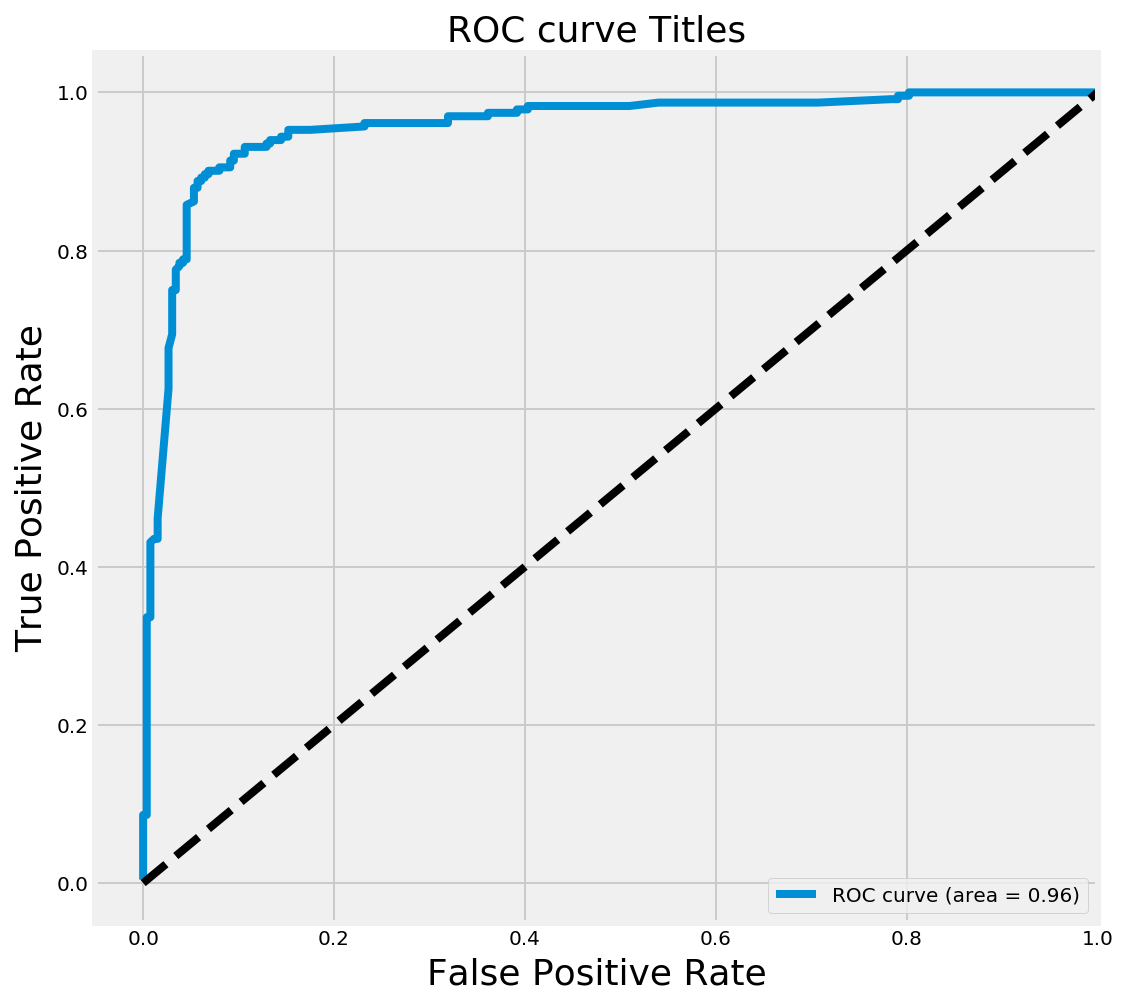

In [32]:
fpr, tpr, _ = roc_curve(ytest_title, etat_pp_title[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve Titles', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### TODO: TP FP TN FN

### Optimizing a model - Summary

In [33]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer


# Parameters List to fine tune
parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C': np.logspace(-5, 0, 100)    
}

# TODO: Initialize the classifier
clf = LogisticRegression(random_state = 42)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        #scoring=f1_score,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(Xtrain_summary ,ytrain_summary)

In [34]:
#Prints our the best parameters
print(grid_obj.best_estimator_)

LogisticRegression(C=0.31257158496882353, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [35]:
grid_obj.best_score_

0.8928571428571429

In [36]:
best_lr = grid_obj.best_estimator_

In [37]:
train_predict(best_lr, Xtrain_summary, ytrain_summary, Xtest_summary, ytest_summary)
print ('')

Training a LogisticRegression using a training set size of 1484. . .
Trained model in 0.0647 seconds
Made predictions in 0.0170 seconds.
F1 score and accuracy score for training set: 0.9967 , 0.9966.
Made predictions in 0.0050 seconds.
F1 score and accuracy score for test set: 0.8722 , 0.8828.
-----------------------------------------------------------------------



#### Probability of words in summaries given "Pay"

Has to be using Naive Bayes, defined as clf_B

In [38]:
cv_summary = CountVectorizer(ngram_range=(2,3),
                     max_features=2500,
                     stop_words='english',
                     tokenizer=LemmaTokenizer(),
                     binary = True)

words_summary = cv_summary.fit_transform(data_scientist_global.summary)
words_summary = pd.DataFrame(words_summary.todense(), columns=cv_summary.get_feature_names())

feat_lp = clf_B_summary.feature_log_prob_

high_p = np.exp(feat_lp[1])

low_p = np.exp(feat_lp[0])

In [39]:
feat_probs = pd.DataFrame({'high_p':high_p, 'low_p':low_p, 'feature':words_summary.columns.values})

feat_probs['pay_diff'] = feat_probs.high_p - feat_probs.low_p

feat_probs.sort_values('pay_diff', ascending=False, inplace=True)
feat_probs.head(20)

feature    high_p     low_p  pay_diff
577                data report  0.675000  0.098901  0.576099
1299     location united state  0.678947  0.119505  0.559442
436            complex project  0.586842  0.163462  0.423381
569              data pipeline  0.476316  0.078297  0.398019
233                 basis race  0.364474  0.048077  0.316397
549             data including  0.290789  0.074176  0.216614
1773               race gender  0.234211  0.038462  0.195749
885        experience applying  0.246053  0.059066  0.186987
584       data science machine  0.278947  0.098901  0.180046
526                 data asset  0.223684  0.043956  0.179728
515           data acquisition  0.226316  0.065934  0.160382
1236        large complex data  0.218421  0.059066  0.159355
618        database experience  0.178947  0.026099  0.152848
1682  project management skill  0.213158  0.070055  0.143103
291      business intelligence  0.163158  0.021978  0.141180
940         experience related  0.286842  0.159341  0.127501
55    additional qualification  0.139474  0.013736  0.125737
1270          learning natural  0.134211  0.009615  0.124595
586      data science solution  0.176316  0.056319  0.119997
821         engineering physic  0.122368  0.005495  0.116874

In [40]:
feat_probs.sort_values('pay_diff', ascending=True, inplace=True)
feat_probs.head(20)

feature    high_p     low_p  pay_diff
27               ability required  0.147368  0.317308 -0.169939
1869              research center  0.014474  0.182692 -0.168219
208                    b computer  0.207895  0.346154 -0.138259
2027           skill demonstrated  0.171053  0.307692 -0.136640
1891           research statistic  0.031579  0.148352 -0.116773
1810            related technical  0.190789  0.304945 -0.114156
758                         e g r  0.046053  0.157967 -0.111914
744                driven insight  0.011842  0.112637 -0.100795
2423         work experience year  0.063158  0.157967 -0.094809
474        consulting engineering  0.014474  0.108516 -0.094043
1386              microsoft excel  0.015789  0.107143 -0.091353
1216               knowledge data  0.040789  0.131868 -0.091079
2202             subject security  0.064474  0.155220 -0.090746
61                advanced degree  0.077632  0.167582 -0.089951
1217         knowledge experience  0.014474  0.104396 -0.089922
1845       required qualification  0.031579  0.118132 -0.086553
399   communication interpersonal  0.351316  0.428571 -0.077256
847        equivalent combination  0.017105  0.093407 -0.076301
1513              orientation age  0.027632  0.103022 -0.075390
29                    ability use  0.036842  0.108516 -0.071674

#### Roc - Auc Curve summaries

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import interp

In [42]:
etat = grid_obj.predict(Xtest_summary)
etat_pp = grid_obj.predict_proba(Xtest_summary)

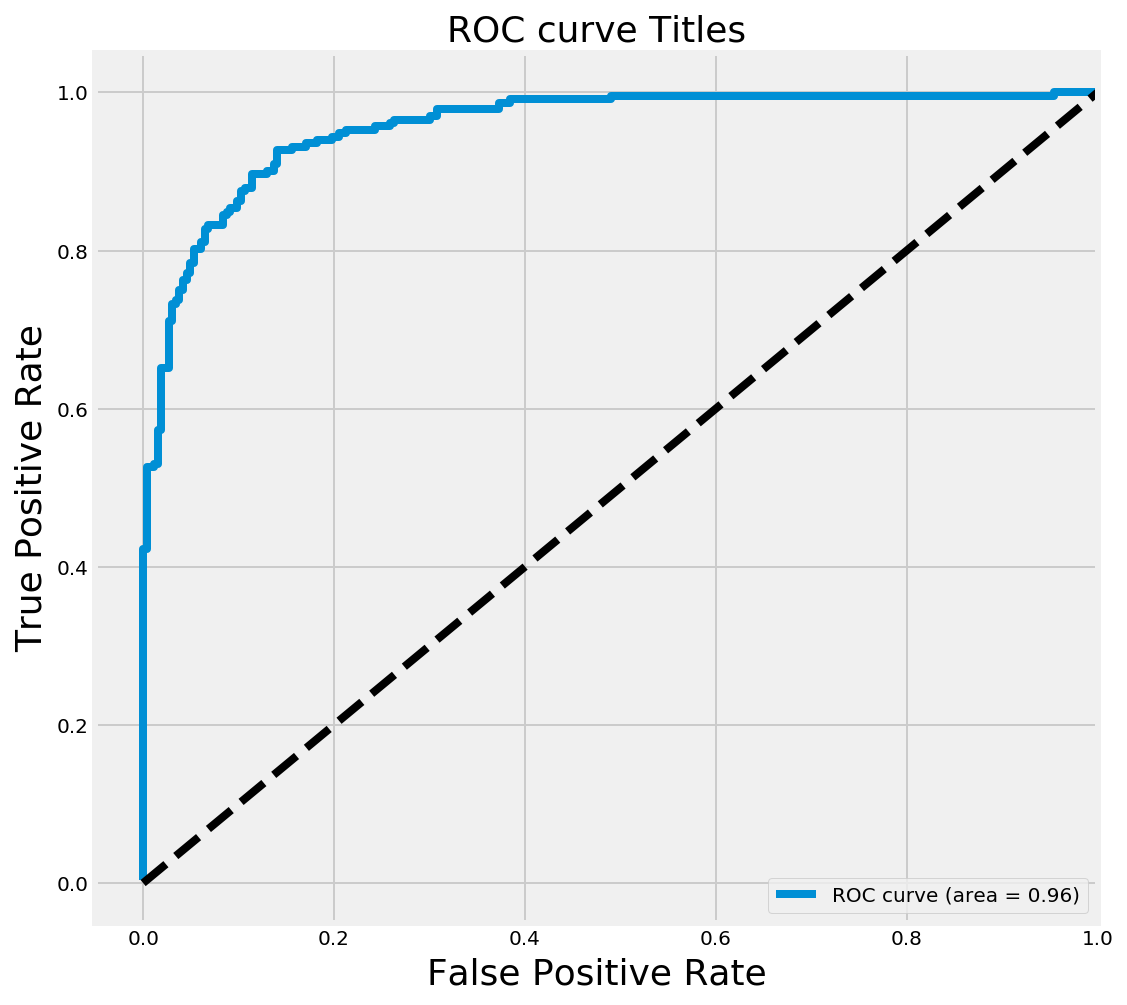

In [43]:
fpr, tpr, _ = roc_curve(ytest_summary, etat_pp[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve Titles', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### N-grams that provide a high pay from Job Summary

In [44]:
high_pay = data_scientist_global[data_scientist_global.pay == 1]["summary"]

cv = CountVectorizer(ngram_range=(2,3),
                     max_features=2500,
                     stop_words='english',
                     tokenizer=LemmaTokenizer(),
                     binary = True)

words_summary = cv.fit_transform(high_pay)
words_summary = pd.DataFrame(words_summary.todense(), columns=cv.get_feature_names())

In [45]:
X_train = pd.DataFrame(cv.transform(high_pay).todense(),
                      columns = cv.get_feature_names())

In [46]:
words_counts = X_train.sum(axis=0)
words_counts.sort_values(ascending = False).head(20)

data scientist                677
machine learning              660
computer science              585
data science                  471
year experience               416
big data                      359
communication skill           352
equal opportunity             292
e g                           290
data analysis                 284
data mining                   280
data set                      276
sexual orientation            264
opportunity employer          260
experience working            260
national origin               256
veteran status                251
experience data               241
equal opportunity employer    238
gender identity               223
dtype: int64

In [47]:
low_pay = data_scientist_global[data_scientist_global.pay == 0]["summary"]

cv = CountVectorizer(ngram_range=(2,3),
                     max_features=2500,
                     stop_words='english',
                     tokenizer=LemmaTokenizer())

words = cv.fit_transform(low_pay)
words = pd.DataFrame(words.todense(), columns=cv.get_feature_names())

In [48]:
X_train = pd.DataFrame(cv.transform(low_pay).todense(),
                      columns = cv.get_feature_names())

In [49]:
words_counts = X_train.sum(axis=0)
words_counts.sort_values(ascending = False).head(20)

data analysis           478
communication skill     442
skill ability           420
year experience         416
bachelor degree         404
ability work            397
equal opportunity       351
related field           342
research analyst        300
sexual orientation      291
master degree           288
national origin         285
e g                     281
machine learning        262
gender identity         255
race color              239
veteran status          238
statistical analysis    232
computer science        229
problem solving         218
dtype: int64

### N-grams that provide a high pay from Job Title

In [50]:
high_pay_title = data_scientist_global[data_scientist_global.pay == 1]["title"]

cv = CountVectorizer(ngram_range=(2,3),
                     max_features=2500,
                     stop_words='english',
                     tokenizer=LemmaTokenizer())

words = cv.fit_transform(high_pay_title)
words = pd.DataFrame(words.todense(), columns=cv.get_feature_names())

In [51]:
X_train = pd.DataFrame(cv.transform(high_pay_title).todense(),
                      columns = cv.get_feature_names())

In [60]:
words_counts = X_train.sum(axis=0)
words_counts.sort_values(ascending = False).head(20)

data scientist                602
senior data                   103
senior data scientist          94
data science                   77
machine learning               76
data engineer                  52
sr data                        44
sr data scientist              38
principal data                 37
research scientist             33
principal data scientist       32
scientist machine              26
lead data                      25
scientist machine learning     25
quantitative analyst           23
lead data scientist            23
data scientist machine         22
software engineer              19
research analyst               19
big data                       17
dtype: int64

## Finding relevant skills

In [53]:
cv_summary = CountVectorizer(ngram_range=(1,2),
                     max_features=2500,
                     stop_words='english',
                     tokenizer=LemmaTokenizer(),
                     binary = True)

words_summary = cv_summary.fit_transform(data_scientist_global.summary)
words_summary = pd.DataFrame(words_summary.todense(), columns=cv_summary.get_feature_names())

In [54]:
skills_list = ["python", "hadoop", "r", "big data", "sql", "nlp", "excel", "deep learning"]
skill_freq = {}

for i in skills_list:
    print("{} appears in {:.2f}% of documents!".format(i, words_summary[i].sum()/len(words_summary)))
    skill_freq[i] = str(round(words_summary[i].sum()/len(words_summary),4)) + "%"

python appears in 0.46% of documents!
hadoop appears in 0.21% of documents!
r appears in 0.45% of documents!
big data appears in 0.21% of documents!
sql appears in 0.31% of documents!
nlp appears in 0.05% of documents!
excel appears in 0.18% of documents!
deep learning appears in 0.10% of documents!


In [55]:
skill_freq = pd.DataFrame.from_dict(skill_freq, orient='index')

In [56]:
skill_freq.columns = ["frequency"]
skill_freq.sort_values(by="frequency", ascending=False)

frequency
python          0.4598%
r               0.4533%
sql             0.3108%
big data        0.2067%
hadoop          0.2052%
excel           0.1774%
deep learning   0.0995%
nlp             0.0536%

In [57]:
high = data_scientist_global[data_scientist_global['pay'] == 1]
low = data_scientist_global[data_scientist_global['pay'] == 0]

In [58]:
words_summary_high = cv_summary.fit_transform(high.summary)
words_summary_high = pd.DataFrame(words_summary_high.todense(), columns=cv_summary.get_feature_names())


skills_list = ["python", "hadoop", "r", "big data", "sql", "nlp", "excel", "deep learning", "phd", "mongodb",
              "cassandra"]
skill_freq = {}

for i in skills_list:
    print("{} appears in {:.2f}% of documents!".format(i, words_summary_high[i].sum()/len(words_summary_high)*100))
    skill_freq[i] = str(round(words_summary_high[i].sum()/len(words_summary_high)*100,4)) + "%"
    
skill_freq = pd.DataFrame.from_dict(skill_freq, orient='index')
skill_freq.columns = ["frequency"]
skill_freq.sort_values(by="frequency", ascending=False)

python appears in 75.25% of documents!
hadoop appears in 39.60% of documents!
r appears in 62.22% of documents!
big data appears in 36.26% of documents!
sql appears in 46.67% of documents!
nlp appears in 10.00% of documents!
excel appears in 6.97% of documents!
deep learning appears in 17.47% of documents!
phd appears in 33.94% of documents!
mongodb appears in 4.55% of documents!
cassandra appears in 4.75% of documents!


frequency
python         75.2525%
r              62.2222%
excel           6.9697%
sql            46.6667%
cassandra       4.7475%
mongodb         4.5455%
hadoop          39.596%
big data       36.2626%
phd            33.9394%
deep learning  17.4747%
nlp               10.0%

In [59]:
words_summary_low = cv_summary.fit_transform(low.summary)
words_summary_low = pd.DataFrame(words_summary_low.todense(), columns=cv_summary.get_feature_names())

skills_list = ["python", "hadoop", "r", "big data", "sql", "nlp", "excel", "deep learning", "phd", "mongodb",
              "cassandra"]
skill_freq = {}

for i in skills_list:
    try:
        print("{} appears in {:.2f}% of documents!".format(i, words_summary_low[i].sum()/len(words_summary_low)))
        skill_freq[i] = str(round(words_summary_low[i].sum()/len(words_summary_low),4)) + "%"
    except KeyError:
        print("{} appears in {:.2f}% of documents!".format(i, 0))
        skill_freq[i] = "0%"
    
skill_freq = pd.DataFrame.from_dict(skill_freq, orient='index')
skill_freq.columns = ["frequency"]
skill_freq.sort_values(by="frequency", ascending=False)

python appears in 0.17% of documents!
hadoop appears in 0.00% of documents!
r appears in 0.28% of documents!
big data appears in 0.05% of documents!
sql appears in 0.15% of documents!
nlp appears in 0.00% of documents!
excel appears in 0.29% of documents!
deep learning appears in 0.02% of documents!
phd appears in 0.16% of documents!
mongodb appears in 0.00% of documents!
cassandra appears in 0.00% of documents!


frequency
excel           0.2851%
r               0.2841%
python          0.1668%
phd             0.1618%
sql             0.1547%
big data        0.0506%
deep learning   0.0243%
hadoop               0%
nlp                  0%
mongodb              0%
cassandra            0%

### TODO:

Confusion matrix

Location